In [1]:
import os, glob
import xarray as xr

#from datatree import DataTree
#import multiprocessing as mp

import metpy.calc as mpcalc
from metpy.units import units

import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import ks_2samp

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

import matplotlib.ticker as ticker

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from uviz.plotting.processing import ModelData
from uviz.plotting.utils import SaffirSimpson, basin_bboxes, geog_features
from uviz.tempest_extremes.processing import TempestExtremes

In [2]:
def get_subset_idx(ds, bbox, overland=True):
    
    # Retrieves bounding box coordinates
    if isinstance(bbox, (dict, str)):
        lons, lats = basin_bboxes(bbox)
    else:
        lons, lats = bbox
        
    # Gets indices to feed to ncol (for plotting)
    if 'ncol' in ds.dims:
        # Retrieves subset but leaves nans in place
        sub_ds = ds.where((ds['lon'] >= lons[0]) & (ds['lon'] <= lons[1]) &
                          (ds['lat'] >= lats[0]) & (ds['lat'] <= lats[1]))
        
        # Retrieves latitude and longitude values
        sub_lons = sub_ds.lon.values
        sub_lats = sub_ds.lat.values
        
        # Gets ncol indices of non-nan values
        lon_idx = np.argwhere(~np.isnan(sub_lons)).flatten()
        lat_idx = np.argwhere(~np.isnan(sub_lats)).flatten()
        
        # Gets union of both indices
        sub_idx = np.intersect1d(lon_idx, lat_idx)
        
        if overland == True:
            # Masks out land values
            land_idx = mask_land(ds, return_idx=True)[1]
            
            # Also gets union of subset indices and landmask indices
            idx = np.intersect1d(sub_idx, land_idx)
        else:
            idx = sub_idx
                
        return idx
    
    # Add else clause here + error message for regridded data
    
def mask_land(ds, return_idx=False):
    
    # Checks if MPAS or CAM based on number of grid cells
    if len(ds.ncol) == 835586:
        model = 'MPAS'
    else:
        model = 'CAM'
        
    # Masks out land grid cells
    if model == 'MPAS':
        idx = mpas_idx
    elif model == 'CAM':
        if len(ds.ncol) == 155981:
            idx = ext_idx
        elif len(ds.ncol) == 119603:
            idx = ref_idx
        elif len(ds.ncol) == 69653:
            idx = wat_idx
            
    # Selects by land indices
    ds = ds.isel(ncol=idx)
    
    # Returns indices if requested
    if return_idx == True:
        return ds, idx
    else:
        return ds

In [3]:
def get_ddf_bbox(ds, variable, distance=100):
    
    # Masks land values
    ds = mask_land(ds)
    
    # Subsets by mainland/peninsular Florida bounding box first
    florida_zoomed = ((np.mod(-83, 360), np.mod(-80, 360)), (24.5, 30))
    ds = spatial_subset(ds, florida_zoomed)
    
    # Finds grid cell with maximum value
    if variable == 'PRECT':
        coords = ds.where(ds['PRECT_TOT'] == ds['PRECT_TOT'].max())
        
    elif variable == 'U10':
        coords = ds.where(ds['U10_MAX'] == ds['U10_MAX'].max())
        
    # Returns grid cell center coordinates
    center_lat = np.nanmin(coords['lat'].values)
    center_lon = np.nanmin(coords['lon'].values)
    
    # Creates bounding box around center coordinates
    bbox = basin_bboxes({'center_coords':(center_lat, center_lon), 'unit': 'km', 'distance':distance})
    
    return bbox

def calc_ddf(data, variable, bbox, rolling_windows, percentiles=[5, 50, 95], overland=True):
    
    """
    Parameters
    ---------------------
    data            :: xr.Dataset
    variable        :: str, target variable from data. 
                        Only 'PRECT' or 'U10' allowed.
    bbox            :: str or dict, feed to basin_bboxes
    rolling_windows :: list of rolling windows
    percentiles     :: list (int), list of percentiles to calculate.
    """
    
    # Gets indices to subset data by based on bbox and overland params
    sub_idx = get_subset_idx(data, bbox, overland)
    
    # Subsets data by above indices
    subset = data.isel(ncol=sub_idx)
        
    # Converts units
    if variable == 'PRECT':
        units = 'in/hour'
    elif variable == 'U10':
        units = 'mph'
        rolling_windows = [int(round(x/3, 0)) for x in rolling_windows] 
    else:
        raise ValueError("Only 'PRECT' or 'U10' allowed as options.")
        
    # Creates DataFrame from array of values
    da = subset[variable].metpy.convert_units(units)
    arr = da.values
    df = pd.DataFrame(arr)

    # Creates new DataFrame for maximum sums or minimum maxima
    if variable == 'PRECT':
        metric_df = pd.DataFrame({f'sum_{i}': df.rolling(i).sum().max() for i in rolling_windows}).T
    elif variable == 'U10':
        metric_df = pd.DataFrame({f'max_{i*3}': df.rolling(i).min().max() for i in rolling_windows}).T

    # Extracts into numpy array for faster calculation
    metric_arr = metric_df.values
    
    # Takes percentiles
    percentile_arr = list(np.nanpercentile(metric_arr, percentiles, axis=1))
    
    # Takes maxima
    max_arr = np.nanmax(metric_arr, axis=1)
    
    return max_arr, percentile_arr

In [4]:
def spatial_subset(ds, bbox, overland=False):
    
    # Masks out land values if True
    if overland == True:
        ds = mask_land(ds)

    # Retrieves bounding box coordinates
    if isinstance(bbox, (dict, str)):
        lons, lats = basin_bboxes(bbox)
    else:
        lons, lats = bbox

    # Subsets data spatially (for regridded data)
    if 'lon' in ds.dims:
        ds = ds.sel(lon=slice(lons[0], lons[1]), lat=slice(lats[0], lats[1]))

    # For native data
    elif 'ncol' in ds.dims:
        # Retrieves subset with nans dropped
        ds = ds.where((ds['lon'] >= lons[0]) & (ds['lon'] <= lons[1]) & 
                      (ds['lat'] >= lats[0]) & (ds['lat'] <= lats[1]), drop=True)

    return ds

def nexrad_ddf(ds, bbox, rolling_windows, percentiles=[5, 50, 95]):
    
    # Converts longitude to [0, 360]
    ds['lon'] = np.mod(ds['lon'] + 180, 360) + 180
    
    # Subsets data by bbox
    subset = spatial_subset(ds, bbox)
    
    # Converts to numpy array for easier calculations
    arr = subset['rain_hourly'].values
    
    # Reshapes into (time, ncol)
    ncols = len(subset['lon'])*len(subset['lat'])
    arr = arr.T.reshape(ncols, len(subset['time']))
    
    # Creates DataFrame from array of values
    df = pd.DataFrame(arr)
    
    # Transposes DataFrame (for... some reason...)
    df = df.T
    
    # Creates new DataFrame for maximum sums
    metric_df = pd.DataFrame({f'sum_{i}': df.rolling(i, min_periods=1).sum().max() for i in rolling_windows}).T

    # Extracts into numpy array for faster calculation
    metric_arr = metric_df.values
    
    # Takes percentiles, ignoring any NaNs
    percentile_arr = list(np.nanpercentile(metric_arr, percentiles, axis=1))
    
    # Takes maxima, ignorning any NaNs
    max_arr = np.nanmax(metric_arr, axis=1)
    
    return max_arr, percentile_arr

In [5]:
from scipy.stats import gaussian_kde, skew
from sklearn.neighbors import KernelDensity

class Statistics():

    def calc_gauss(self, arr, eval_pts, method='scipy', **kwargs):
        """
        Function to manually calculate Gaussian PDF
        for plotting histograms with MPL. Default 
        method is 'scipy', which is what seaborn uses.
        
        Parameters
        -----------------
        data     :: np.ndarray, 1-D array of values
        eval_pts :: np.ndarray, 1-D array of values 
        method   :: str (opt), default='scipy', method
                        of calculating gaussians.
                        Options are 'scipy' or 'sklearn'.
                        
        Optional kwargs
        ------------------
        kde_kw   :: kwargs to pass to scipy.gaussian_kde or
                        sklearn.neighbors.KernelDensity
        """
        
        # Converts to array
        if isinstance(arr, list):
            arr = np.array(arr)

        # Retrieves KDE calculation kwargs
        kde_kw = kwargs.get('kde_kw', {})

        if method == 'scipy':
            # Calculates KDE
            kde = gaussian_kde(arr, **kde_kw)
            
            # Fits KDE to Gaussian PDF
            gauss = kde.pdf(eval_pts)

        elif method == 'sklearn':
            # Unpacks kwargs
            kde_kw = {'bandwidth':1, 'kernel':'gaussian', **kde_kw}
            
            # Calculates KDE
            kde = KernelDensity(**kde_kw).fit(arr.reshape([-1, 1]))
            
            # Fits KDE to Gaussian PDF
            gauss = np.exp(kde.score_samples(eval_pts.reshape([-1, 1])))
            
        else:
            raise ValueError("`method` not in acceptable values: 'scipy', 'sklearn'.")

        return gauss
    
    def fit_gauss(self, x):
        # x = np.sort(x)
        # k, loc, scale = scipy.stats.exponnorm.fit(np.sort(x))
        # gauss_pdf = scipy.stats.exponnorm.pdf(np.sort(x), k, loc, scale)
        gauss_pdf = gaussian_kde(x).pdf(np.sort(x))

        return gauss_pdf

    def get_hist_metrics(self, ds, variable, bbox):

        subset_idx = get_subset_idx(ds, bbox)
        subset_ds = ds.isel(ncol=subset_idx)
        arr = subset_ds[variable].values.flatten()
        bins = np.histogram_bin_edges(arr, bins='auto')
        gauss = self.fit_gauss(np.sort(arr))

        return arr, bins, gauss

    def nexrad_hist_metrics(self, ds, variable, bbox):

        # Converts longitude to [0, 360]
        ds['lon'] = np.mod(ds['lon'] + 180, 360) + 180
        subset_ds = spatial_subset(ds, bbox, False)
        arr = subset_ds['rain_hourly'].values
        arr = arr[:, ~np.isnan(arr).all(axis=0)]

        if variable == 'PRECT_TOT':
            arr = np.nansum(arr, axis=0)
        elif variable == 'PRECT_MAX':
            arr = np.nanmax(arr, axis=0)

        bins = np.histogram_bin_edges(arr, bins='auto')
        gauss = self.fit_gauss(np.sort(arr))

        return arr, bins, gauss
    
#     def calc_skew(self, arr):
        
#         skewness = 

In [6]:
tracks_dir = r"/gpfs/group/cmz5202/default/cnd5285/synth_events"
track_folders = glob.glob(os.path.join(tracks_dir, '*storm*'))
parent_folders = [os.path.join(folder, '28km') for folder in track_folders]
child_folders = [os.path.join(folder, '3km') for folder in track_folders]

In [7]:
%%time
all_storms = ModelData(tracks_dir, regridded=False).storms

Opening data files.
Opening grid files.
Matching grid files with data files.
CPU times: user 52.9 s, sys: 4.14 s, total: 57 s
Wall time: 1min 35s


In [8]:
irma_ds = xr.open_dataset('../data/irma_nexrad.nc')
ian_ds = xr.open_dataset('../data/ian_nexrad.nc')
charley_ds = xr.open_dataset('../data/charley_nexrad.nc')
isaac_ds = xr.open_dataset('../data/isaac_nexrad.nc')
fay_ds = xr.open_dataset('../data/fay_nexrad.nc')

In [9]:
# Ensures nexrad data timesteps == model data timesteps
ian_ds = ian_ds.sel(time=all_storms['Ian']['h4cn_ds'].time.astype('datetime64[ns]'))
irma_ds = irma_ds.sel(time=all_storms['Irma']['h4cn_ds'].time.astype('datetime64[ns]'))
charley_ds = charley_ds.sel(time=all_storms['Charley']['h4cn_ds'].time.astype('datetime64[ns]'))
isaac_ds = isaac_ds.sel(time=all_storms['Isaac']['h4cn_ds'].time.astype('datetime64[ns]'))
fay_ds = fay_ds.sel(time=all_storms['Fay']['h4cn_ds'].time.astype('datetime64[ns]'))

In [10]:
storms = all_storms.keys()
storms

dict_keys(['Ian', 'Irma', 'storm_0236', 'storm_0755', 'Charley', 'storm_0528', 'storm_1048', 'storm_1521', 'Fay', 'Isaac', 'storm_1354', 'storm_1307', 'storm_0310', 'storm_1279'])

In [8]:
%%time
# Reads in landmask datasets
landmask_dir = r'/gpfs/group/cmz5202/default/cnd5285/landmasks'

mpas_land_ds = xr.open_dataset(os.path.join(landmask_dir, 'MPAS.VR3_landmask.nc'))
ext_land_ds = xr.open_dataset(os.path.join(landmask_dir, 'SE.VR28.NATL.EXT_landmask.nc'))
ref_land_ds = xr.open_dataset(os.path.join(landmask_dir, 'SE.VR28.NATL.REF_landmask.nc'))
wat_land_ds = xr.open_dataset(os.path.join(landmask_dir, 'SE.VR28.NATL.WAT_landmask.nc'))

CPU times: user 16.4 ms, sys: 3.04 ms, total: 19.4 ms
Wall time: 112 ms


In [9]:
# Gets indices of overland masks
mpas_idx = np.where(mpas_land_ds['LANDFRAC'] >= 0.5)[0]
ext_idx = np.where(ext_land_ds['LANDFRAC'] >= 0.5)[0]
ref_idx = np.where(ref_land_ds['LANDFRAC'] >= 0.5)[0]
wat_idx = np.where(wat_land_ds['LANDFRAC'] >= 0.5)[0]

# Synthetic Storms

In [10]:
storm_0236_bbox = basin_bboxes({'west_coord':-82.733860, 'east_coord':-80.036716, 'south_coord':25.121120, 'north_coord':27.495256})
storm_0755_bbox = basin_bboxes({'west_coord':-82.733860, 'east_coord':-80.036716, 'south_coord':25.348799, 'north_coord':27.777070})
storm_0528_bbox = basin_bboxes({'west_coord':-82.733860, 'east_coord':-80.036716, 'south_coord':25.121120, 'north_coord':27.495256})
storm_1048_bbox = basin_bboxes({'west_coord':-82.858682, 'east_coord':-80.036716, 'south_coord':25.629735, 'north_coord':28.508998})
storm_1521_bbox = basin_bboxes({'west_coord':-82.733860, 'east_coord':-80.036716, 'south_coord':25.121120, 'north_coord':27.946685})
storm_1354_bbox = basin_bboxes({'west_coord':-81.992647, 'east_coord':-80.036716, 'south_coord':25.121120, 'north_coord':26.700814})
storm_1307_bbox = basin_bboxes({'west_coord':-82.515101, 'east_coord':-80.036716, 'south_coord':25.121120, 'north_coord':27.210623})
storm_0310_bbox = basin_bboxes({'west_coord':-82.861571, 'east_coord':-80.036716, 'south_coord':25.659481, 'north_coord':28.412060})
storm_1279_bbox = basin_bboxes({'west_coord':-82.733860, 'east_coord':-80.036716, 'south_coord':25.121120, 'north_coord':27.357253})

storm_name = [x for x in all_storms.keys() if x not in ['Ian', 'Irma', 'Charley', 'Isaac', 'Fay']]
bboxes = [storm_0236_bbox, storm_0755_bbox, storm_0528_bbox, 
          storm_1048_bbox, storm_1521_bbox, storm_1354_bbox, 
          storm_1307_bbox, storm_0310_bbox, storm_1279_bbox]

In [17]:
ds_arr=['h4pn_ds', 'h4cn_ds']
storm_name = [x for x in all_storms.keys() if x not in ['Ian', 'Irma', 'Charley', 'Isaac', 'Fay']]
variable = 'PRECT'
rolling_windows = [1, 3, 6, 12, 24, 36, 48, 72, 96, 120]

# Packs target datasets into list
storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_name))

# Retrieves maximum and percentile arrays
# max_arrs, percentile_arrs = zip(*map(lambda x: zip(*map(calc_ddf, x, 
#                                                         [variable]*len(ds_arr), 
#                                                         bboxes, 
#                                                         [rolling_windows]*len(ds_arr))), 
#                                      storm_list))

max_arrs = []
percentile_arrs = []

for i, storm in enumerate(storm_list):
    marr = []
    parr = []
    for ds in storm:
        max_arr, perc_arr = calc_ddf(ds, variable, bboxes[i], rolling_windows)
        marr.append(max_arr)
        parr.append(perc_arr)
    max_arrs.append(marr)
    percentile_arrs.append(parr)

#max_arrs, percentile_arrs = zip([lambda x: calc_ddf(x, variable, bboxes[i], rolling_windows) for i, storm in enumerate(storm_list)])

# Takes median, 5th-, and 95th- percentiles
percentile_arrs = np.array(percentile_arrs)
p5 = percentile_arrs[:, :, 0]
medians = percentile_arrs[:, :, 1]
p95 = percentile_arrs[:, :, 2]

# Converts max_arrs to numpy array
max_arrs = np.array(max_arrs)

In [19]:
storm_name

['storm_0236',
 'storm_0755',
 'storm_0528',
 'storm_1048',
 'storm_1521',
 'storm_1354',
 'storm_1307',
 'storm_0310',
 'storm_1279']

In [24]:
storm_name = [x for x in all_storms.keys() if x not in ['Ian', 'Irma', 'Charley', 'Isaac', 'Fay']]

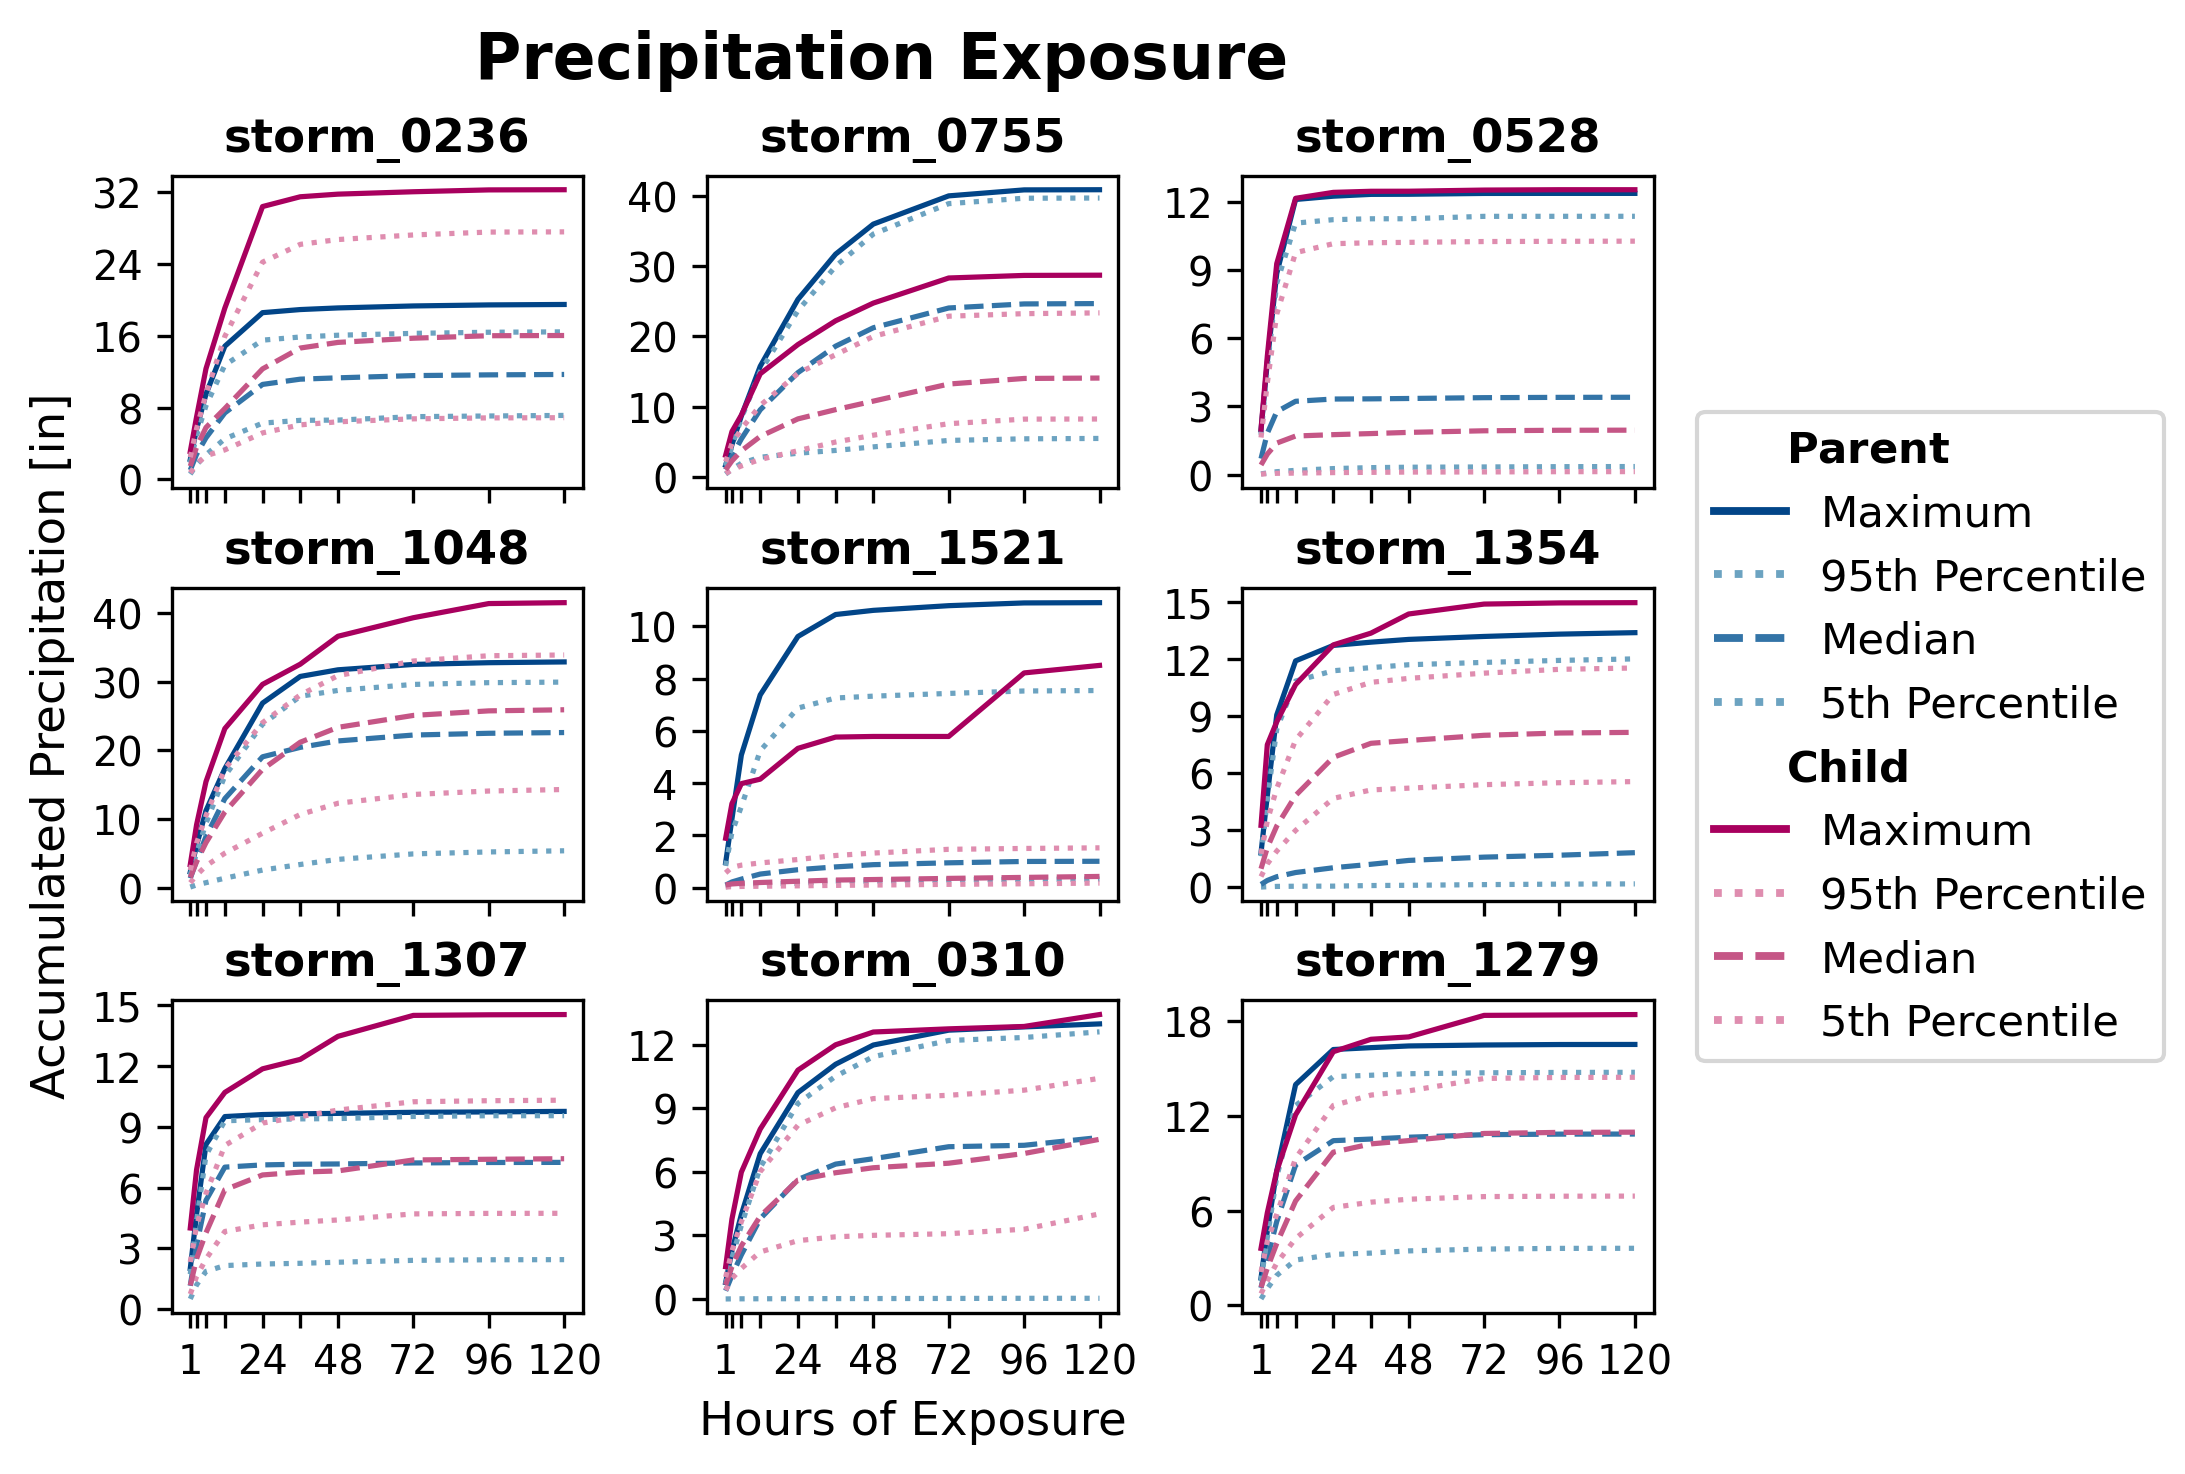

In [26]:
# Declares if figure is for paper or for presentation
#output = 'paper'
output = 'presentation'

plot_kw = {'lw':1.0, 'ylabel':'Accumulated Precipitation [in]', 
           'xlabel':'Hours of Exposure', 'figtitle':'Precipitation Exposure'}
fig_kw = {'ncols': 3, 'nrows': 3, 'figsize': (6.2, 7), 'dpi':300, 'layout':'constrained', 'sharex':True}
cam_colors = ['#024588', '#6ca3c1', '#3374a7', '#6ca3c1']

# Old, non-colorblind safe
# mpas_colors = ['#bd0086', '#e892c4', '#d45ca5', '#e892c4']

# Hopefully colorblind safe
mpas_colors = ['#a8005e', '#df8daf', '#c55686', '#df8daf']

if output == 'paper':
    fig_kw['figsize'] = (6.2, 7)
    font_kw = {'labels':11, 'titles':12, 'ticks':9, 'legend':11, 'figtitle':14}
elif output == 'presentation':
    #fig_kw['figsize'] = (8, 6)
    #font_kw = {'labels':10.5, 'titles':12, 'ticks':7.5, 'legend':10}
    
    fig_kw['figsize'] = (7.2, 4.8) #(9, 6)
    plot_kw['lw'] = 1.25 #1.5
    font_kw = {'labels':11.2, 'titles':11.2, 'ticks':9.6, 'legend':10.4, 'figtitle':15.2}
    #font_kw = {'labels':14, 'titles':14, 'ticks':12, 'legend':13}

# Fishes out number of storms and number of ds based on max_arrs dims
nstorms = max_arrs.shape[0]
nds = max_arrs.shape[1]

labs = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)']
labs = labs[:nstorms]
labs_dict = dict(facecolor='white', edgecolor='k')

# if output == 'presentation':
#     storm_name = [f'{l} {s}' for l, s in zip(labs, storm_name)]

# Plots output
fig, axs = plt.subplots(**fig_kw)

x_axis = rolling_windows
lcolor = [cam_colors, mpas_colors]
if len(x_axis) == 10:
    if output == 'presentation':
        xlabs = [1, '', '', '', 24, '', 48, 72, 96, 120]
    elif output == 'paper':
        xlabs = [1, '', '', '', 24, '', 48, 72, 96, 120]
elif len(x_axis) == 9:
    xlabs = [3, '', 12, 24, 36, 48, 72, 96, 120]
    
for i, ax in enumerate(axs.ravel()):

    if nds == 2:
        for j in range(nds):
            ax.plot(x_axis, max_arrs[i][j].flatten(), label='Maximum', c=lcolor[j][0], lw=plot_kw['lw'])
            ax.plot(x_axis, p5[i][j].flatten(), label='5th Percentile', ls=':', c=lcolor[j][1], lw=plot_kw['lw'])
            ax.plot(x_axis, medians[i][j].flatten(), label='Median', ls='--', c=lcolor[j][2], lw=plot_kw['lw'])
            ax.plot(x_axis, p95[i][j].flatten(), label='95th Percentile', ls=':', c=lcolor[j][3], lw=plot_kw['lw'])

    ax.set_title(f'{storm_name[i]}', fontsize=font_kw['titles'], fontweight='heavy')

    #ax.set_xticks([3, 6, 12, 36], [3, 6, 12, 36], minor=True)
    ax.set_xticks(x_axis, xlabs, minor=False)
    
    ax.tick_params(axis='both', which='major', labelsize=font_kw['ticks'])
    ax.tick_params(axis='x', which='minor', labelsize=font_kw['ticks']-4)
    
    #ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
    
    text_kw = dict(verticalalignment='top', transform=ax.transAxes, fontsize=10, fontweight='bold', bbox=labs_dict, zorder=100)
    
    # if output == 'presentation':
    #     text_kw['fontsize'] = 12
    
    # Adds labels
    if output == 'paper':
        ax.text(0.075, 0.925, labs[i], **text_kw)
    elif output == 'presentation':
        ax.text(0.075, 0.90, labs[i], **text_kw)

    if output == 'paper':
        if i == 3:
            ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'])
        if i == 7:
            ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'])
            
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
        
        if i == 8:
            ax.yaxis.set_ticks(np.arange(0, 19, 6))
        elif i in [2, 7]:
            ax.yaxis.set_ticks(np.arange(0, 13, 3))

    elif output == 'presentation':
        start, end = ax.get_ylim()
        #end = int(np.ceil(end))

        # Formats y-labels to stop being annoying
        if end < 12:
            ax.yaxis.set_ticks(np.arange(0, end, 2))
        elif np.logical_and(end > 12, end < 18):
            ax.yaxis.set_ticks(np.arange(0, end, 3))
        elif np.logical_and(end >= 18, end < 30):
            ax.yaxis.set_ticks(np.arange(0, end, 6))
        elif np.logical_and(end >= 30, end < 35):
            ax.yaxis.set_ticks(np.arange(0, end, 8))
        elif end > 35:
            ax.yaxis.set_ticks(np.arange(0, end, 10))
        
        if i == 3:
            ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'])
        if i == 7:
            ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'])
        # if len(x_axis) == 10:
        #     xlabs = [1, '', '', '', 24, '', 48, 72, 96, 120]
        # elif len(x_axis) == 9:
        #     xlabs = [3, '', 12, 24, 36, 48, 72, 96, 120]

if output == 'paper':
    figtitle_x = 0.5
elif output == 'presentation':
    figtitle_x = 0.4
    
fig.suptitle(plot_kw['figtitle'], fontsize=font_kw['figtitle'], fontweight='bold', x=figtitle_x)

lmetrics = ['Maximum', '95th Percentile', 'Median', '5th Percentile']
llabels = [r'$\bf{CAM5-SE}$', *lmetrics, r'$\bf{CAM5-MPAS}$', *lmetrics]

if output == 'presentation':
    llabels = [r'$\bf{Parent}$', *lmetrics, r'$\bf{Child}$', *lmetrics]

lcolors = ['none', *cam_colors, 'none', *mpas_colors]
lstyles = ['none', '-', ':', '--', ':', 'none', '-', ':', '--', ':']
style_dict = {'xdata': [], 'ydata': [], 'lw': plot_kw['lw']*1.5}
handles = [mlines.Line2D(label=l, color=c, ls=ls, **style_dict) for (l, c, ls) in 
           zip(llabels, lcolors, lstyles)]

if output == 'paper':
    leg = fig.legend(handles=handles, fontsize=font_kw['legend'], loc='outside lower center', 
              ncols=2, handlelength=1.65)
elif output == 'presentation':
    leg = fig.legend(handles=handles, fontsize=font_kw['legend'], loc='outside right center', 
              ncols=1, handlelength=1.65)    

for i, (item, label) in enumerate(zip(leg.legend_handles, leg.get_texts())):
    if label._text in [llabels[0], llabels[5]]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha('left')
        label.set_position((-2*width, 0))

plt.show()
plt.close()

In [32]:
%%time
ds_arr=['h4pn_ds', 'h4cn_ds']
variable = 'PRECT_TOT'
storm_name = [x for x in all_storms.keys() if x not in ['Ian', 'Irma', 'Charley', 'Isaac', 'Fay']]
bboxes = [storm_0236_bbox, storm_0755_bbox, storm_0528_bbox, 
          storm_1048_bbox, storm_1521_bbox, storm_1354_bbox, 
          storm_1307_bbox, storm_0310_bbox, storm_1279_bbox]

# Packs target datasets into list
storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_name))
cam_ds_list = [x[0] for x in storm_list]
mpas_ds_list = [x[1] for x in storm_list]

cam_arr, cam_bins, cam_gauss = zip(*map(get_hist_metrics, cam_ds_list, [variable]*len(cam_ds_list), bboxes))
mpas_arr, mpas_bins, mpas_gauss = zip(*map(get_hist_metrics, mpas_ds_list, [variable]*len(mpas_ds_list), bboxes))

CPU times: user 1min 2s, sys: 30.3 s, total: 1min 32s
Wall time: 1min 24s


In [73]:
cam_skew = [skew_metrics(x, variable)[0] for x in cam_arr]
cam_yki = [skew_metrics(x, variable)[1] for x in cam_arr]

mpas_skew = [skew_metrics(x, variable)[0] for x in mpas_arr]
mpas_yki = [skew_metrics(x, variable)[1] for x in mpas_arr]

skew_df = pd.DataFrame({'cam_skew':cam_skew, 'cam_yki':cam_yki, 'mpas_skew':mpas_skew, 'mpas_yki':mpas_yki}, index=storm_name)

print('Total Precipitation')
skew_df

Total Precipitation


cam_skew   cam_yki  mpas_skew  mpas_yki
storm_0236 -0.399444 -0.126320   0.225462 -0.220238
storm_0755 -0.399763 -0.170232   0.322973  0.027846
storm_0528  0.292355  0.438969   0.786876  0.572381
storm_1048 -0.710349 -0.472231  -0.689655 -0.155287
storm_1521  1.826832  0.509069   2.999412  0.309874
storm_1354  1.161527  0.704185  -0.490182  0.038356
storm_1307 -0.460155 -0.422340  -0.382934  0.043963
storm_0310 -0.350503  0.029842  -0.367228  0.075039
storm_1279 -0.548555 -0.247680  -0.837815 -0.001464

In [74]:
%%time
ds_arr=['h4pn_ds', 'h4cn_ds']
variable = 'PRECT_MAX'
storm_name = [x for x in all_storms.keys() if x not in ['Ian', 'Irma', 'Charley', 'Isaac', 'Fay']]
bboxes = [storm_0236_bbox, storm_0755_bbox, storm_0528_bbox, 
          storm_1048_bbox, storm_1521_bbox, storm_1354_bbox, 
          storm_1307_bbox, storm_0310_bbox, storm_1279_bbox]

# Packs target datasets into list
storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_name))
cam_ds_list = [x[0] for x in storm_list]
mpas_ds_list = [x[1] for x in storm_list]

cam_arr, cam_bins, cam_gauss = zip(*map(get_hist_metrics, cam_ds_list, [variable]*len(cam_ds_list), bboxes))
mpas_arr, mpas_bins, mpas_gauss = zip(*map(get_hist_metrics, mpas_ds_list, [variable]*len(mpas_ds_list), bboxes))

cam_skew = [skew_metrics(x, variable)[0] for x in cam_arr]
cam_yki = [skew_metrics(x, variable)[1] for x in cam_arr]

mpas_skew = [skew_metrics(x, variable)[0] for x in mpas_arr]
mpas_yki = [skew_metrics(x, variable)[1] for x in mpas_arr]

skew_df = pd.DataFrame({'cam_skew':cam_skew, 'cam_yki':cam_yki, 'mpas_skew':mpas_skew, 'mpas_yki':mpas_yki}, index=storm_name)

print('Maximum Hourly Precipitation')
skew_df

Maximum Hourly Precipitation
CPU times: user 55.3 s, sys: 10.1 s, total: 1min 5s
Wall time: 58.9 s


cam_skew   cam_yki  mpas_skew  mpas_yki
storm_0236  0.100029  0.209730   0.299108  0.064981
storm_0755 -0.567485 -0.034784   0.724637  0.179389
storm_0528  0.163204  0.190330   0.655457  0.444711
storm_1048 -0.701090 -0.465900   0.438628  0.027515
storm_1521  1.409467  0.596146   2.818307  0.289008
storm_1354  1.433068  0.441457   1.419697  0.174349
storm_1307 -0.128866 -0.238499   1.402437  0.241013
storm_0310 -0.218994 -0.053075   0.407375  0.125960
storm_1279 -0.445838 -0.109641   1.598235  0.128337

In [64]:
skew_df.describe()

cam_skew   cam_yki  mpas_skew  mpas_yki
count  9.000000  9.000000   9.000000  9.000000
mean   0.115944  0.529765   1.084876  0.593070
std    0.793161  0.166638   0.813136  0.063107
min   -0.701090  0.267050   0.299108  0.513757
25%   -0.445838  0.445180   0.438628  0.562980
50%   -0.128866  0.482608   0.724637  0.587175
75%    0.163204  0.604865   1.419697  0.620507
max    1.433068  0.798073   2.818307  0.722356

In [59]:
def make_histograms(storm_names, variable, ds_arr, bboxes, output='paper', **kwargs):

    #font_kw = {'labels':9, 'titles':12, 'ticks':7, 'legend':10}
    
    plot_kw = {'lw':1.0, 'ylabel':'Density', 
               'xlabel':'Accumulated Precipitation [in]'}
    if variable == 'PRECT_TOT':
        plot_kw['figtitle'] = 'Total Precipitation'
    elif variable == 'PRECT_MAX':
        plot_kw['figtitle'] = 'Maximum Hourly Precipitation Rate'
    else:
        raise ValueError("Only 'PRECT_TOT' and 'PRECT_MAX' are acceptable values for `variable`.")
    fig_kw = {'ncols': 3, 'nrows': 3, 'figsize': (6.2, 6.2), 'dpi':300, 'layout':'constrained'}
    hist_kw = {'histtype':'step', 'density':True, 'lw':0.5}
    gauss_kw = {'ls':'--', 'lw':0.5}
    
    if output == 'paper':
        #font_kw = {'labels':8, 'titles':11, 'ticks':7, 'legend':10, 'figtitle':15}
        font_kw = {'labels':11, 'titles':12, 'ticks':9, 'legend':11, 'figtitle':14}

    elif output == 'presentation':
        fig_kw['figsize'] = (6.625, 6.2)
        font_kw = {'labels':14.5, 'titles':14, 'ticks':12, 'legend':10, 'figtitle':19}
        hist_kw['lw'] = 0.5
        gauss_kw['lw'] = 0.5

    cam_colors = ['#024588', '#6ca3c1', '#3374a7', '#6ca3c1']
    #mpas_colors = ['#bd0086', '#e892c4', '#d45ca5', '#e892c4']
    mpas_colors = ['#a8005e', '#df8daf', '#c55686', '#df8daf']
    colors = [cam_colors[0], mpas_colors[0]]
    
    labs = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)']
    labs = labs[:nstorms]
    labs_dict = dict(facecolor='white', edgecolor='k')
    
    # Packs target datasets into list
    storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_names))
    cam_ds_list = [x[0] for x in storm_list]
    mpas_ds_list = [x[1] for x in storm_list]

    cam_arr, cam_bins, cam_gauss = zip(*map(Statistics().get_hist_metrics, cam_ds_list, [variable]*len(cam_ds_list), bboxes))
    mpas_arr, mpas_bins, mpas_gauss = zip(*map(Statistics().get_hist_metrics, mpas_ds_list, [variable]*len(mpas_ds_list), bboxes))
    
    fig, axs = plt.subplots(**fig_kw)
    
    # Sets up legend
    llabels = ['CAM5-SE', 'CAM5-MPAS']
    if output == 'presentation':
        llabels = ['Parent', 'Child']
    lcolors = colors
    lstyles = ['-', '-']
    style_dict = {'xdata': [], 'ydata': [], 'lw': 1.5}
    handles = [mlines.Line2D(label=l, color=c, ls=ls, **style_dict) for (l, c, ls) in 
               zip(llabels, lcolors, lstyles)]


    for i, ax in enumerate(axs.ravel()):
        ax.hist(cam_arr[i], color=cam_colors[0], bins=cam_bins[i], **hist_kw)
        ax.plot(np.sort(cam_arr[i]), cam_gauss[i], c=cam_colors[0], **gauss_kw)

        ax.hist(mpas_arr[i], color=mpas_colors[0], bins=mpas_bins[i], **hist_kw)
        ax.plot(np.sort(mpas_arr[i]), mpas_gauss[i], c=mpas_colors[0], **gauss_kw)

        if i in [0, 3, 6]:
            ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'])
            
        if i == 7:
            ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'])

        ax.set_title(f'{storm_name[i]}', fontsize=font_kw['titles'], fontweight='bold')

        ax.tick_params(axis='both', which='major', labelsize=font_kw['ticks'])
        
        if variable == 'PRECT_TOT':
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
        elif variable == 'PRECT_MAX':
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
        
        if output == 'presentation':
            # if i == 2:
            #     ax.legend(handles=handles, fontsize=font_kw['legend'], 
            #               loc='upper right', handlelength=1.0)
                
            start, end = ax.get_xlim()
            #end = int(np.ceil(end))

            if variable == 'PRECT_TOT':
                # Formats x-labels to stop being annoying
                if end < 12:
                    ax.xaxis.set_ticks(np.arange(0, end, 2))
                elif np.logical_and(end > 12, end < 18):
                    ax.xaxis.set_ticks(np.arange(0, end, 3))
                elif np.logical_and(end >= 18, end < 30):
                    ax.xaxis.set_ticks(np.arange(0, end, 6))
                elif np.logical_and(end >= 30, end < 35):
                    ax.xaxis.set_ticks(np.arange(0, end, 8))
                elif end > 35:
                    ax.xaxis.set_ticks(np.arange(0, end, 10))
                
                if i == 4:
                    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
            elif variable == 'PRECT_MAX':
                if i in [0, 1, 3, 5, 8]:
                    ax.xaxis.set_ticks([0, 1, 2, 3], [0, 1, 2, 3])
                if i in [2, 4]:
                    ax.xaxis.set_ticks([0, 1, 2], [0, 1, 2])
                elif i == 7:
                    ax.xaxis.set_ticks([0.0, 0.5, 1.0, 1.5], [0, 0.5, 1.0, 1.5])
        elif output == 'paper':
            if variable == 'PRECT_TOT':
                if i == 0:
                    ax.xaxis.set_ticks([0, 10, 20, 30], [0, 10, 20, 30])
                elif i == 1:
                    ax.xaxis.set_ticks([0, 10, 20, 30, 40], [0, 10, 20, 30, 40])
                elif i == 2:
                    ax.xaxis.set_ticks([0, 4, 8, 12], [0, 4, 8, 12])
                elif i == 3:
                    ax.xaxis.set_ticks([0, 10, 20, 30, 40], [0, 10, 20, 30, 40])
                elif i == 4:
                    ax.yaxis.set_ticks([0.0, 0.5, 1.0, 1.5, 2.0], [0.0, 0.5, 1.0, 1.5, 2.0])
                    ax.xaxis.set_ticks([0, 3, 6, 9, 12], [0, 3, 6, 9, 12])
                elif i == 5:
                    ax.yaxis.set_ticks([0.00, 0.06, 0.12, 0.18, 0.24, 0.30], [0.00, 0.06, 0.12, 0.18, 0.24, 0.30])
                    ax.xaxis.set_ticks([0, 5, 10, 15], [0, 5, 10, 15])
                elif i == 6:
                    ax.xaxis.set_ticks([0, 5, 10, 15], [0, 5, 10, 15])
                    ax.yaxis.set_ticks([0.00, 0.05, 0.10, 0.15, 0.20, 0.25], [0.00, 0.05, 0.10, 0.15, 0.20, 0.25])
                elif i == 7:
                    ax.xaxis.set_ticks([0, 5, 10, 15], [0, 5, 10, 15])
                    ax.yaxis.set_ticks([0.0, 0.1, 0.2, 0.3], [0.0, 0.1, 0.2, 0.3])
                elif i == 8:
                    ax.xaxis.set_ticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20])
                    ax.yaxis.set_ticks([0.00, 0.05, 0.10, 0.15, 0.20, 0.25], [0.00, 0.05, 0.10, 0.15, 0.20, 0.25])
                ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
                    
            elif variable == 'PRECT_MAX':
                if i in [1, 6, 8]:
                    ax.yaxis.set_ticks([0.0, 0.5, 1.0, 1.5], [0.0, 0.5, 1.0, 1.5])
                elif i == 4:
                    ax.xaxis.set_ticks([0, 1, 2, 3], [0, 1, 2, 3])
                if i in [3, 6, 8]:
                    ax.xaxis.set_ticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4])
                    
               
                

                
            #     # Formats x-labels to stop being annoying
            #     if end < 12:
            #         ax.xaxis.set_ticks(np.arange(0, end, 2))
            #     elif np.logical_and(end > 12, end < 18):
            #         ax.xaxis.set_ticks(np.arange(0, end, 3))
            #     elif np.logical_and(end >= 18, end < 30):
            #         ax.xaxis.set_ticks(np.arange(0, end, 6))
            #     elif np.logical_and(end >= 30, end < 35):
            #         ax.xaxis.set_ticks(np.arange(0, end, 8))
            #     elif end > 35:
            #         ax.xaxis.set_ticks(np.arange(0, end, 10))
        
        #if output == 'paper':
        if output == 'paper':
            if variable == 'PRECT_TOT':
                if i == 2:
                    x = 0.88
                elif i == 5:
                    x = 0.89
                elif i == 8:
                    x = 0.89
                else:
                    x = 0.875
            elif variable == 'PRECT_MAX':
                if i == 8:
                    x = 0.9
                elif i == 5:
                    x = 0.89
                else:
                    x = 0.88
        elif output == 'presentation':
            if variable == 'PRECT_TOT':
                if i == 2:
                    x = 0.87
                elif i == 5:
                    x = 0.88
                elif i == 8:
                    x = 0.88
                else:
                    x = 0.85
            elif variable == 'PRECT_MAX':
                if i == 8:
                    x = 0.89
                elif i == 5:
                    x = 0.88
                else:
                    x = 0.87
                    
        # Adds labels #0.925 #0.875 for paper
        ax.text(x, 0.85, labs[i], va='center', ha='center', transform=ax.transAxes, fontsize=14, fontweight='bold', bbox=labs_dict, zorder=100)


    fig.suptitle(plot_kw['figtitle'], fontsize=font_kw['figtitle'], fontweight='bold')

    if output == 'paper':
        fig.legend(handles=handles, fontsize=font_kw['legend'], loc='outside lower center', 
                   ncols=2, handlelength=1.65)

    plt.show()
    plt.close()

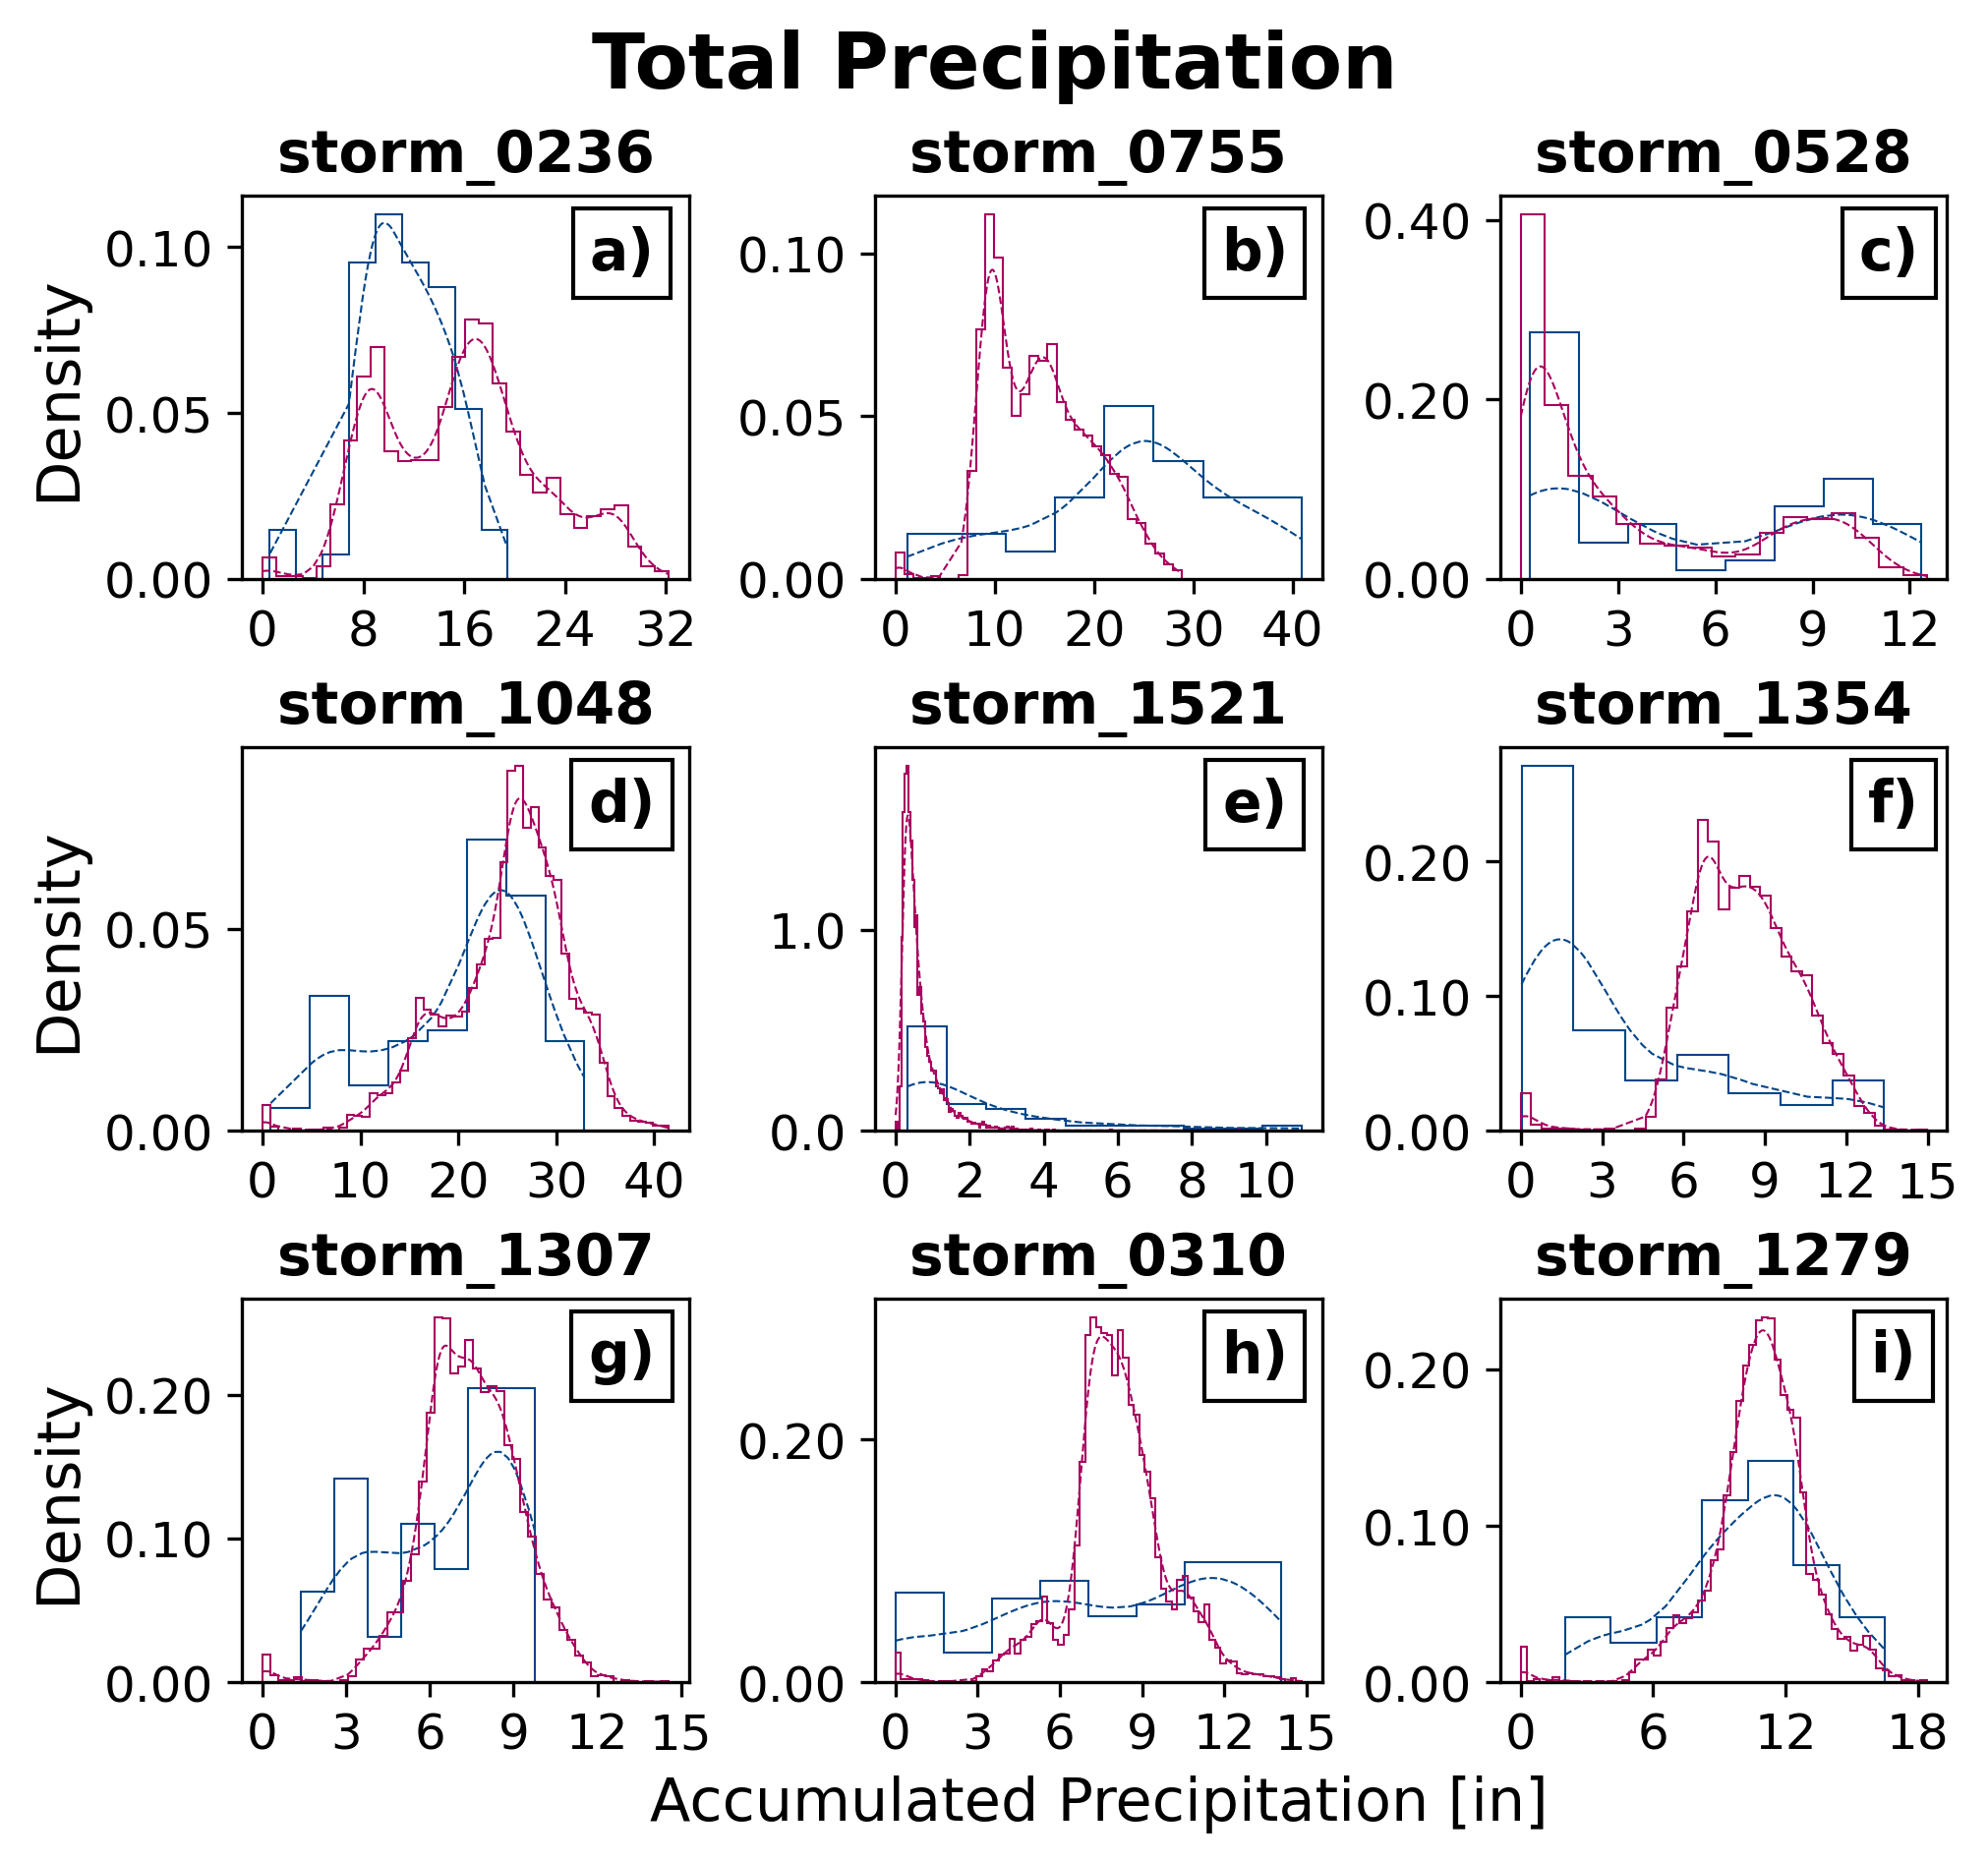

In [57]:
ds_arr=['h4pn_ds', 'h4cn_ds']
variable = 'PRECT_TOT'
storm_name = [x for x in all_storms.keys() if x not in ['Ian', 'Irma', 'Charley', 'Isaac', 'Fay']]
bboxes = [storm_0236_bbox, storm_0755_bbox, storm_0528_bbox, 
          storm_1048_bbox, storm_1521_bbox, storm_1354_bbox, 
          storm_1307_bbox, storm_0310_bbox, storm_1279_bbox]

make_histograms(storm_name, variable, ds_arr, bboxes, 'presentation')

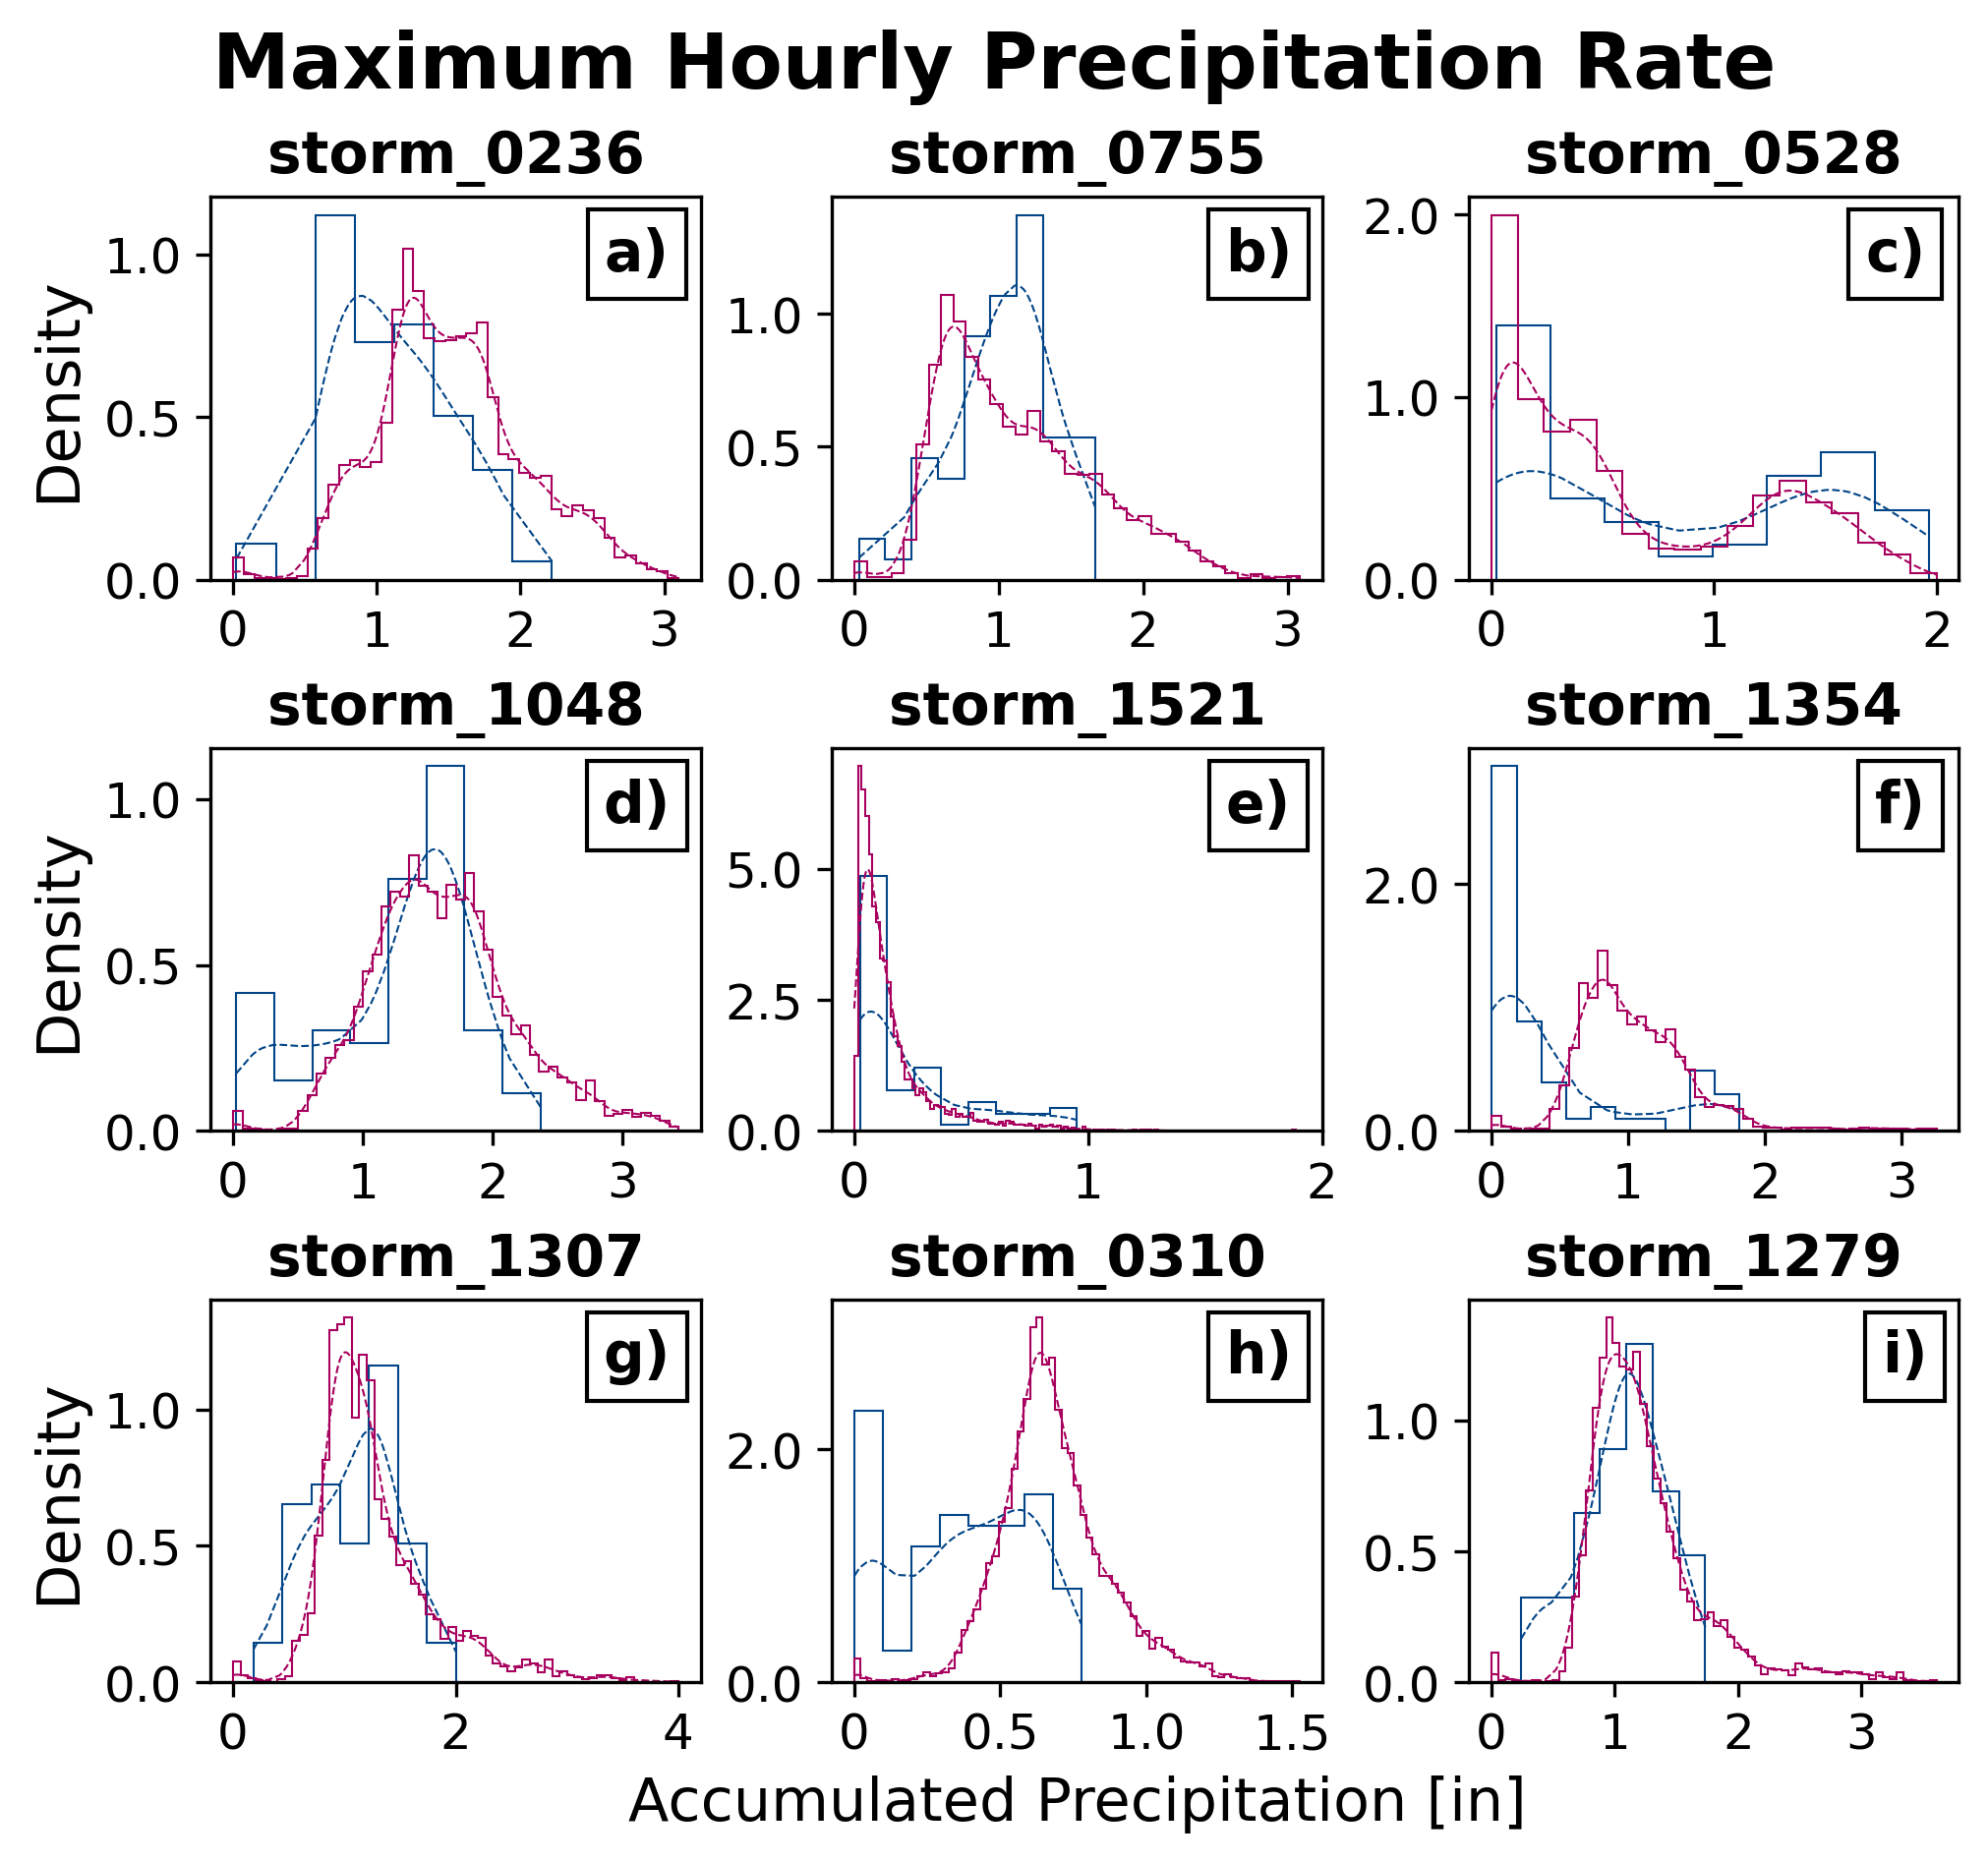

In [60]:
ds_arr=['h4pn_ds', 'h4cn_ds']
variable = 'PRECT_MAX'
storm_name = [x for x in all_storms.keys() if x not in ['Ian', 'Irma', 'Charley', 'Isaac', 'Fay']]
bboxes = [storm_0236_bbox, storm_0755_bbox, storm_0528_bbox, 
          storm_1048_bbox, storm_1521_bbox, storm_1354_bbox, 
          storm_1307_bbox, storm_0310_bbox, storm_1279_bbox]

make_histograms(storm_name, variable, ds_arr, bboxes, 'presentation')

In [ ]:
plot_kw = {'lw':1.0, 'ylabel':'Density', 
               'xlabel':'Accumulated Precipitation [in]'}
if variable == 'PRECT_TOT':
    plot_kw['figtitle'] = 'Total Precipitation'
elif variable == 'PRECT_MAX':
    plot_kw['figtitle'] = 'Maximum Hourly Precipitation'
else:
    raise ValueError("Only 'PRECT_TOT' and 'PRECT_MAX' are acceptable values for `variable`.")
fig_kw = {'ncols': 3, 'nrows': 3, 'figsize': (6.2, 6.2), 'dpi':300, 'layout':'constrained'}
hist_kw = {'histtype':'step', 'density':True, 'lw':0.5}
gauss_kw = {'ls':'--', 'lw':0.5}

if output == 'paper':
    font_kw = {'labels':8, 'titles':11, 'ticks':7, 'legend':10}

elif output == 'presentation':
    fig_kw['figsize'] = (6.625, 6.2)
    font_kw = {'labels':14, 'titles':14, 'ticks':11, 'legend':10}
    hist_kw['lw'] = 0.75
    gauss_kw['lw'] = 0.75

cam_colors = ['#024588', '#6ca3c1', '#3374a7', '#6ca3c1']
#mpas_colors = ['#bd0086', '#e892c4', '#d45ca5', '#e892c4']
mpas_colors = ['#a8005e', '#df8daf', '#c55686', '#df8daf']
colors = [cam_colors[0], mpas_colors[0]]

# Packs target datasets into list
storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_names))
cam_ds_list = [x[0] for x in storm_list]
mpas_ds_list = [x[1] for x in storm_list]

cam_arr, cam_bins, cam_gauss = zip(*map(Statistics().get_hist_metrics, cam_ds_list, [variable]*len(cam_ds_list), bboxes))
mpas_arr, mpas_bins, mpas_gauss = zip(*map(Statistics().get_hist_metrics, mpas_ds_list, [variable]*len(mpas_ds_list), bboxes))

fig, axs = plt.subplots(**fig_kw)

# Sets up legend
llabels = ['CAM5-SE', 'CAM5-MPAS']
lcolors = colors
lstyles = ['-', '-']
style_dict = {'xdata': [], 'ydata': [], 'lw': 1.5}
handles = [mlines.Line2D(label=l, color=c, ls=ls, **style_dict) for (l, c, ls) in 
           zip(llabels, lcolors, lstyles)]


for i, ax in enumerate(axs.ravel()):
    ax.hist(cam_arr[i], color=cam_colors[0], bins=cam_bins[i], **hist_kw)
    ax.plot(np.sort(cam_arr[i]), cam_gauss[i], c=cam_colors[0], **gauss_kw)

    ax.hist(mpas_arr[i], color=mpas_colors[0], bins=mpas_bins[i], **hist_kw)
    ax.plot(np.sort(mpas_arr[i]), mpas_gauss[i], c=mpas_colors[0], **gauss_kw)

In [14]:
def calc_cdf(x):
    x = np.sort(x)
    cdf = 1*(np.arange(x.shape[0])/(x.shape[0]-1))
    
    return cdf

def lognorm_cdf(x):
    x = np.sort(x)
    shape, loc, scale = scipy.stats.lognorm.fit(x)
    cdf = scipy.stats.lognorm.cdf(x, shape, loc, scale)
    
    return cdf

def plot_cdf(storm_names, variable, ds_arr, bboxes, method=2, output='paper'):
    
    # Sets up plot
    plot_kw = {'lw':1.0, 'xlabel':'Accumulated Precipitation [in]'}
    fig_kw = {'ncols': 3, 'nrows': 3, 'figsize': (8, 8), 'dpi':300, 'layout':'constrained', 'sharey':True}
    line_kw = {'ls':'-', 'lw':1.25}
    
    if variable == 'PRECT_TOT':
        if output == 'paper':
            plot_kw['figtitle'] = 'Total Precipitation Cumulative Distribution'
        elif output == 'presentation':
            plot_kw['figtitle'] = 'Total Precipitation CDF'
    elif variable == 'PRECT_MAX':
        if output == 'paper':
            plot_kw['figtitle'] = 'Maximum Hourly Precipitation Rate Cumulative Distribution'
        elif output == 'presentation':
            plot_kw['figtitle'] = 'Maximum Hourly Precipitation Rate CDF'
    else:
        raise ValueError("Only 'PRECT_TOT' and 'PRECT_MAX' are acceptable values for `variable`.")
        
    if output == 'paper':
        #font_kw = {'labels':8, 'titles':11, 'ticks':7, 'legend':10, 'figtitle':15}
        font_kw = {'labels':11, 'titles':12, 'ticks':9, 'legend':11, 'figtitle':14}
        fig_kw['figsize'] = (6.2, 6.8)
        if variable == 'PRECT_MAX':
            font_kw['figtitle'] = 13
    elif output == 'presentation':
        font_kw = {'labels':17, 'titles':19, 'ticks':13, 'legend':10, 'figtitle':22}
        #font_kw = {'labels':12, 'titles':14, 'ticks':11, 'legend':10, 'figtitle':19}

    cam_colors = ['#024588', '#6ca3c1', '#3374a7', '#6ca3c1']
    #mpas_colors = ['#bd0086', '#e892c4', '#d45ca5', '#e892c4']
    mpas_colors = ['#a8005e', '#df8daf', '#c55686', '#df8daf']
    colors = [cam_colors[0], mpas_colors[0]]
    
    # Packs target datasets into list
    storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_names))
    cam_ds_list = [x[0] for x in storm_list]
    mpas_ds_list = [x[1] for x in storm_list]

    cam_arr = [get_hist_metrics(x, variable, bboxes[i])[0] for i, x in enumerate(cam_ds_list)]
    mpas_arr = [get_hist_metrics(x, variable, bboxes[i])[0] for i, x in enumerate(mpas_ds_list)]
    
    nstorms = len(cam_arr)
    
    labs = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)']
    labs = labs[:nstorms]
    labs_dict = dict(facecolor='white', edgecolor='k')
    
    # # Calculates mean and std
    cam_xbar = ['%.2f' % x.mean() for x in cam_arr]
    cam_s = ['%.2f' % x.std() for x in cam_arr]
    mpas_xbar = ['%.2f' % x.mean() for x in mpas_arr]
    mpas_s = ['%.2f' % x.std() for x in mpas_arr]
    
    # Calculates cdfs
    if method == 1:
        cam_cdfs = [scipy.stats.norm(loc=x.mean(), scale=x.std()).cdf(np.sort(x)) for x in cam_arr]
        mpas_cdfs = [scipy.stats.norm(loc=x.mean(), scale=x.std()).cdf(np.sort(x)) for x in mpas_arr]
    elif method == 2:
        cam_cdfs = [calc_cdf(x) for x in cam_arr]
        mpas_cdfs = [calc_cdf(x) for x in mpas_arr]
    elif method == 3:
        cam_cdfs = [scipy.stats.norm(loc=x.mean()).cdf(np.sort(x)) for x in cam_arr]
        mpas_cdfs = [scipy.stats.norm(loc=x.mean()).cdf(np.sort(x)) for x in mpas_arr]
    elif method == 4:
        cam_cdfs = [lognorm_cdf(x) for x in cam_arr]
        mpas_cdfs = [lognorm_cdf(x) for x in mpas_arr]
    
    # Plots results
    fig, axs = plt.subplots(**fig_kw)
    
    for i, ax in enumerate(axs.ravel()):
        ax.plot(np.sort(cam_arr[i]), cam_cdfs[i], c=colors[0], **line_kw)
        ax.plot(np.sort(mpas_arr[i]), mpas_cdfs[i], c=colors[1], **line_kw)
        
        if i == 7:
            ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'])
        ax.tick_params(axis='both', which='major', labelsize=font_kw['ticks'])
        ax.set_title(f'{storm_names[i]}', fontsize=font_kw['titles'], fontweight='bold')
        
        if output == 'paper':
            ax.text(0.075, 0.925, labs[i], verticalalignment='top', transform=ax.transAxes, fontsize=10, fontweight='bold', bbox=labs_dict, zorder=100)
        if output == 'presentation':
            ax.text(0.05, 0.95, labs[i], verticalalignment='top', transform=ax.transAxes, fontsize=18, fontweight='bold', bbox=labs_dict, zorder=100)
        
        if output in ['paper', 'presentation']:
            if variable == 'PRECT_TOT':
                if i in [1, 3]:
                    ax.xaxis.set_ticks([0, 10, 20, 30, 40], [0, 10, 20, 30, 40])
                elif i == 2:
                    ax.xaxis.set_ticks([0, 4, 8, 12], [0, 4, 8, 12])
                elif i == 4:
                    ax.xaxis.set_ticks([0, 3, 6, 9, 12], [0, 3, 6, 9, 12])
                elif i == 8:
                    ax.xaxis.set_ticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20])
            elif variable == 'PRECT_MAX':
                if i in [3, 6, 8]:
                    ax.xaxis.set_ticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4])
                elif i == 4:
                    ax.xaxis.set_ticks([0, 1, 2, 3], [0, 1, 2, 3])
        
        # Sets up legend (per ax)
        llabs = [r'$\bar{x}$'+f' = {cam_xbar[i]}',
                 r'$\bar{x}$'+f' = {mpas_xbar[i]}']
        
        lcs = colors
        lss = ['-', '-', '-']
        ldict = {'xdata': [], 'ydata': [], 'lw': 1.5}
        lhands = [mlines.Line2D(label=l, color=c, ls=ls, **ldict) for (l, c, ls) in 
           zip(llabs, lcs, lss)]
        if output == 'paper':
            #ax.legend(handles=lhands, fontsize=font_kw['legend']-1, loc='lower right', handlelength=1.65)
            ax.legend(handles=lhands, fontsize=font_kw['legend']-4, loc='lower right', handlelength=1.65)
    
    fig.suptitle(plot_kw['figtitle'], fontsize=font_kw['figtitle'], fontweight='bold')

    if output == 'paper':
        llabels = ['CAM5-SE', 'CAM5-MPAS']
        lcolors = colors
        lstyles = ['-', '-']
        style_dict = {'xdata': [], 'ydata': [], 'lw': 1.5}
        handles = [mlines.Line2D(label=l, color=c, ls=ls, **style_dict) for (l, c, ls) in 
                   zip(llabels, lcolors, lstyles)]
        leg = fig.legend(handles=handles, fontsize=font_kw['legend'], loc='outside lower center', 
                  ncols=3, handlelength=1.65)

    plt.show()
    plt.close()      

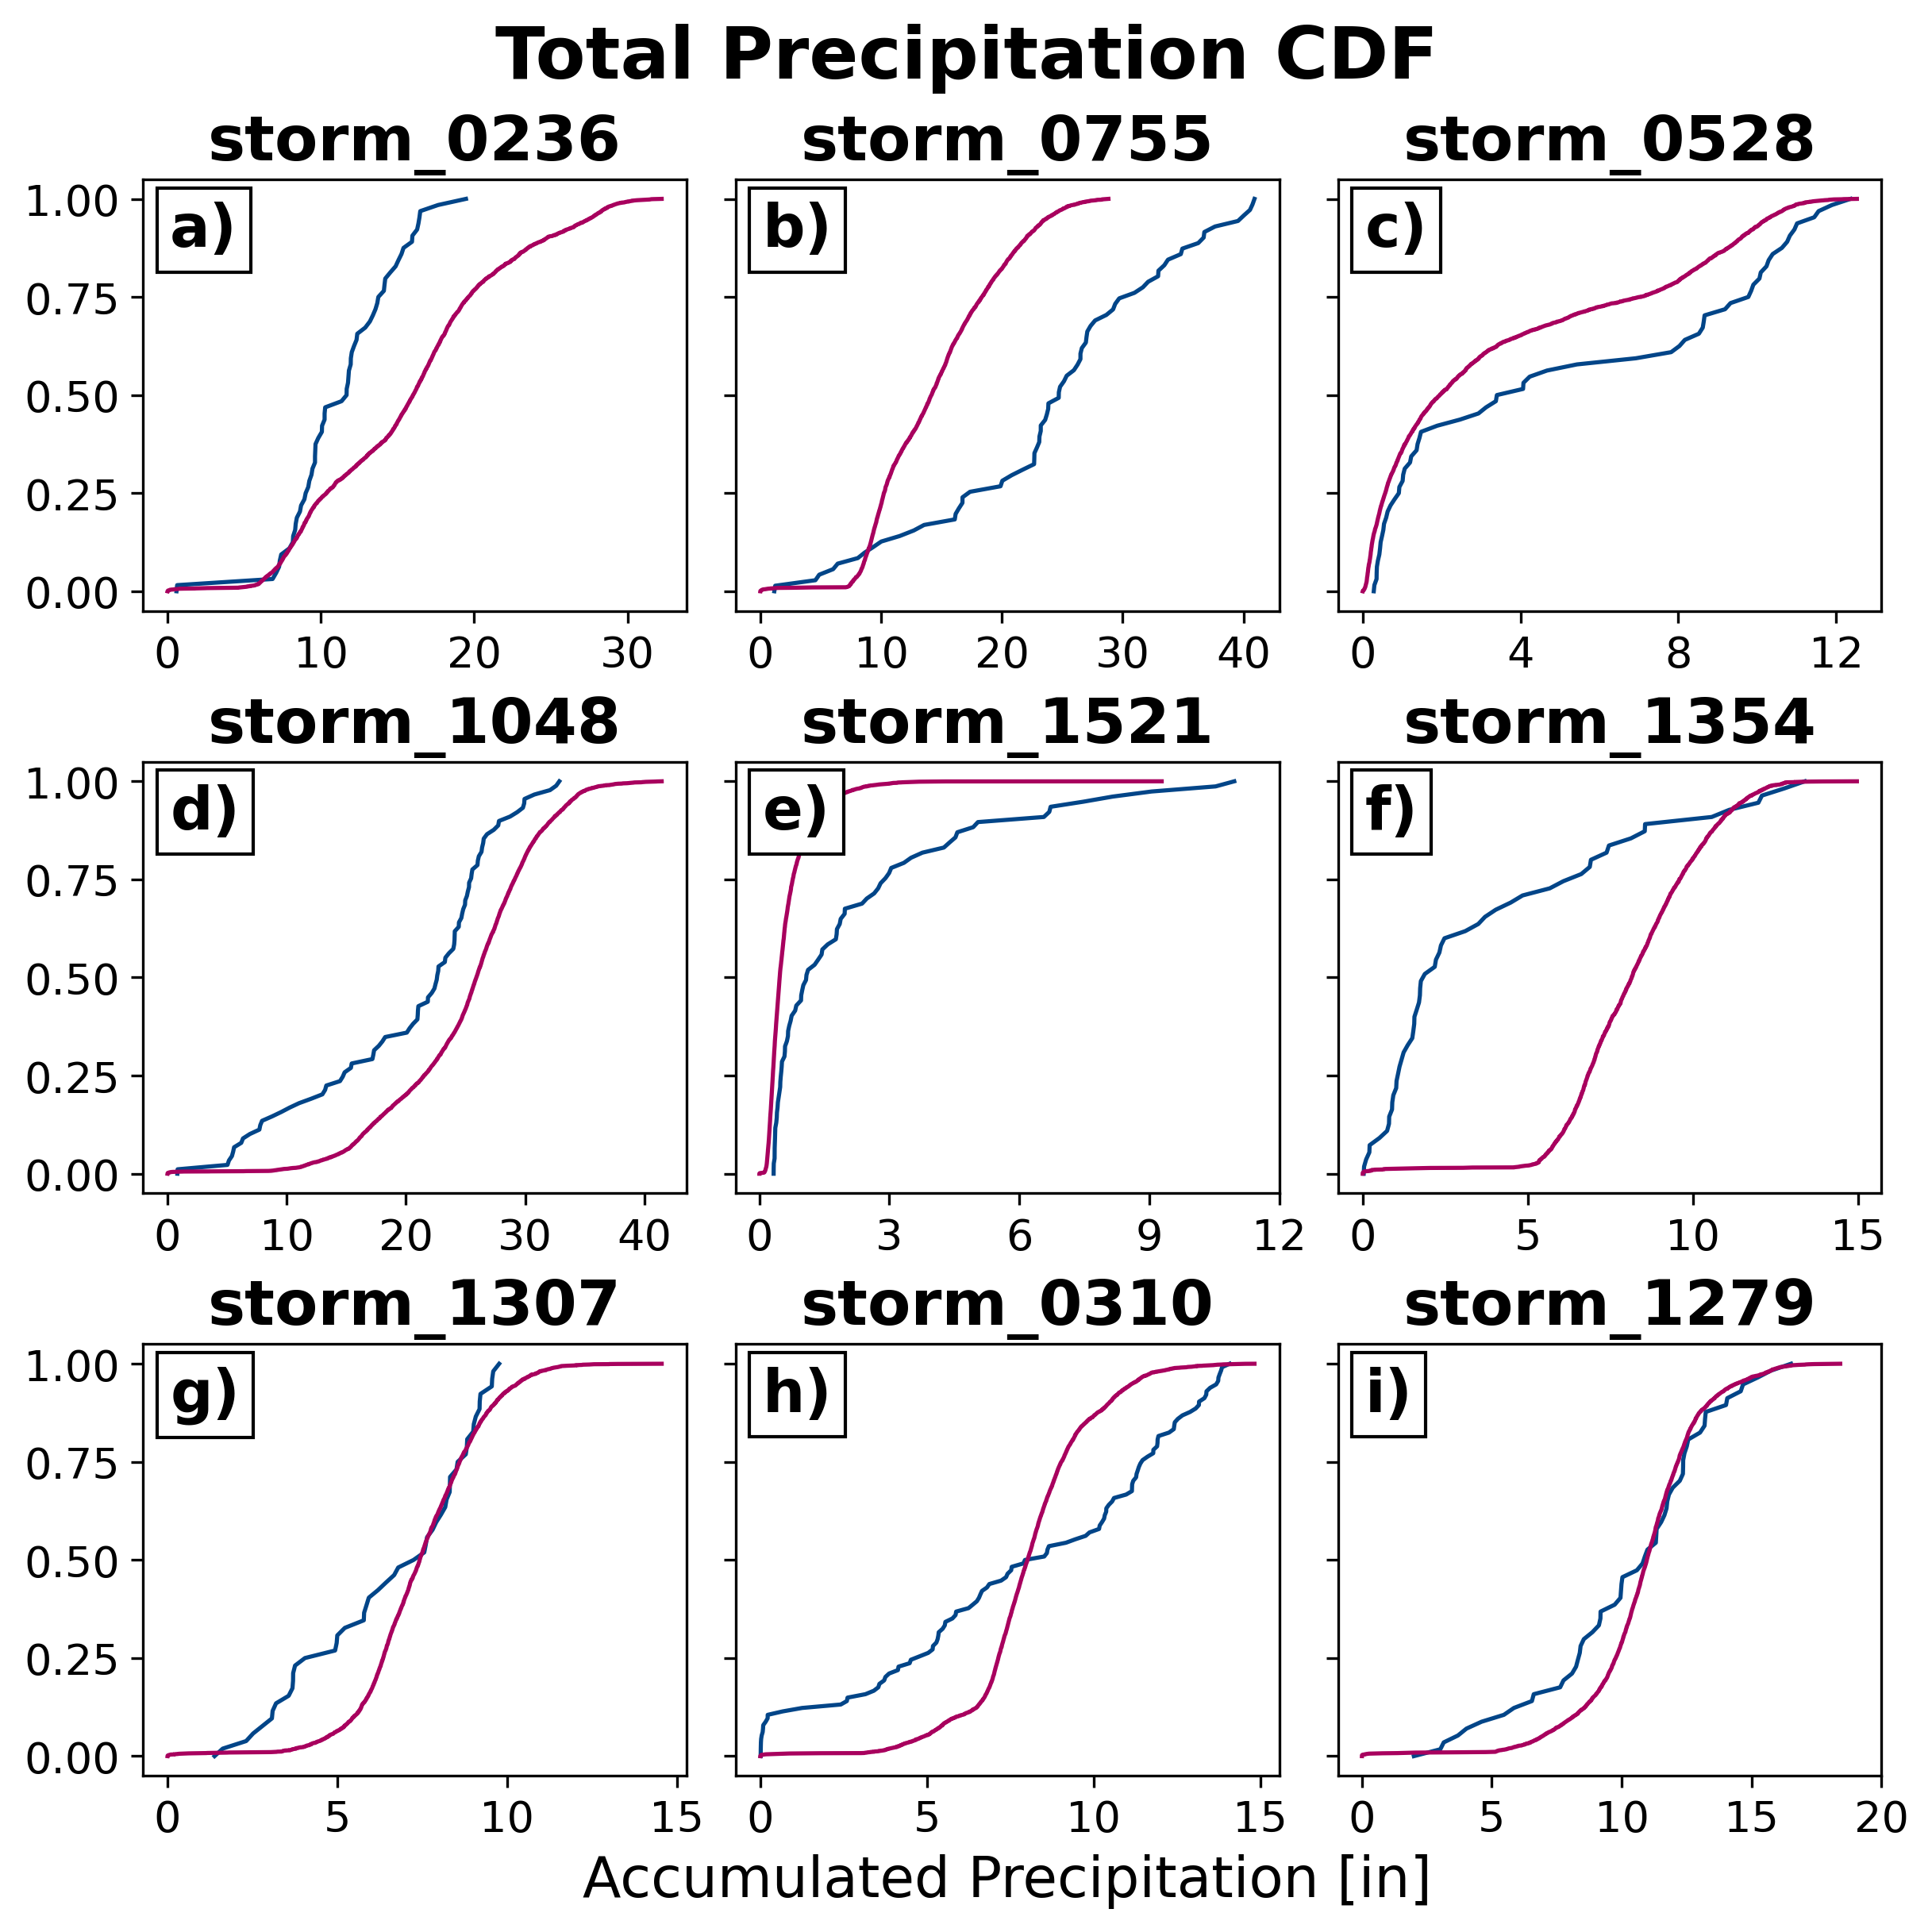

In [15]:
ds_arr=['h4pn_ds', 'h4cn_ds']
variable = 'PRECT_TOT'
storm_names = [x for x in all_storms.keys() if x not in ['Ian', 'Irma', 'Charley', 'Isaac', 'Fay']]
bboxes = [storm_0236_bbox, storm_0755_bbox, storm_0528_bbox, 
          storm_1048_bbox, storm_1521_bbox, storm_1354_bbox, 
          storm_1307_bbox, storm_0310_bbox, storm_1279_bbox]

plot_cdf(storm_names, variable, ds_arr, bboxes, output='presentation')

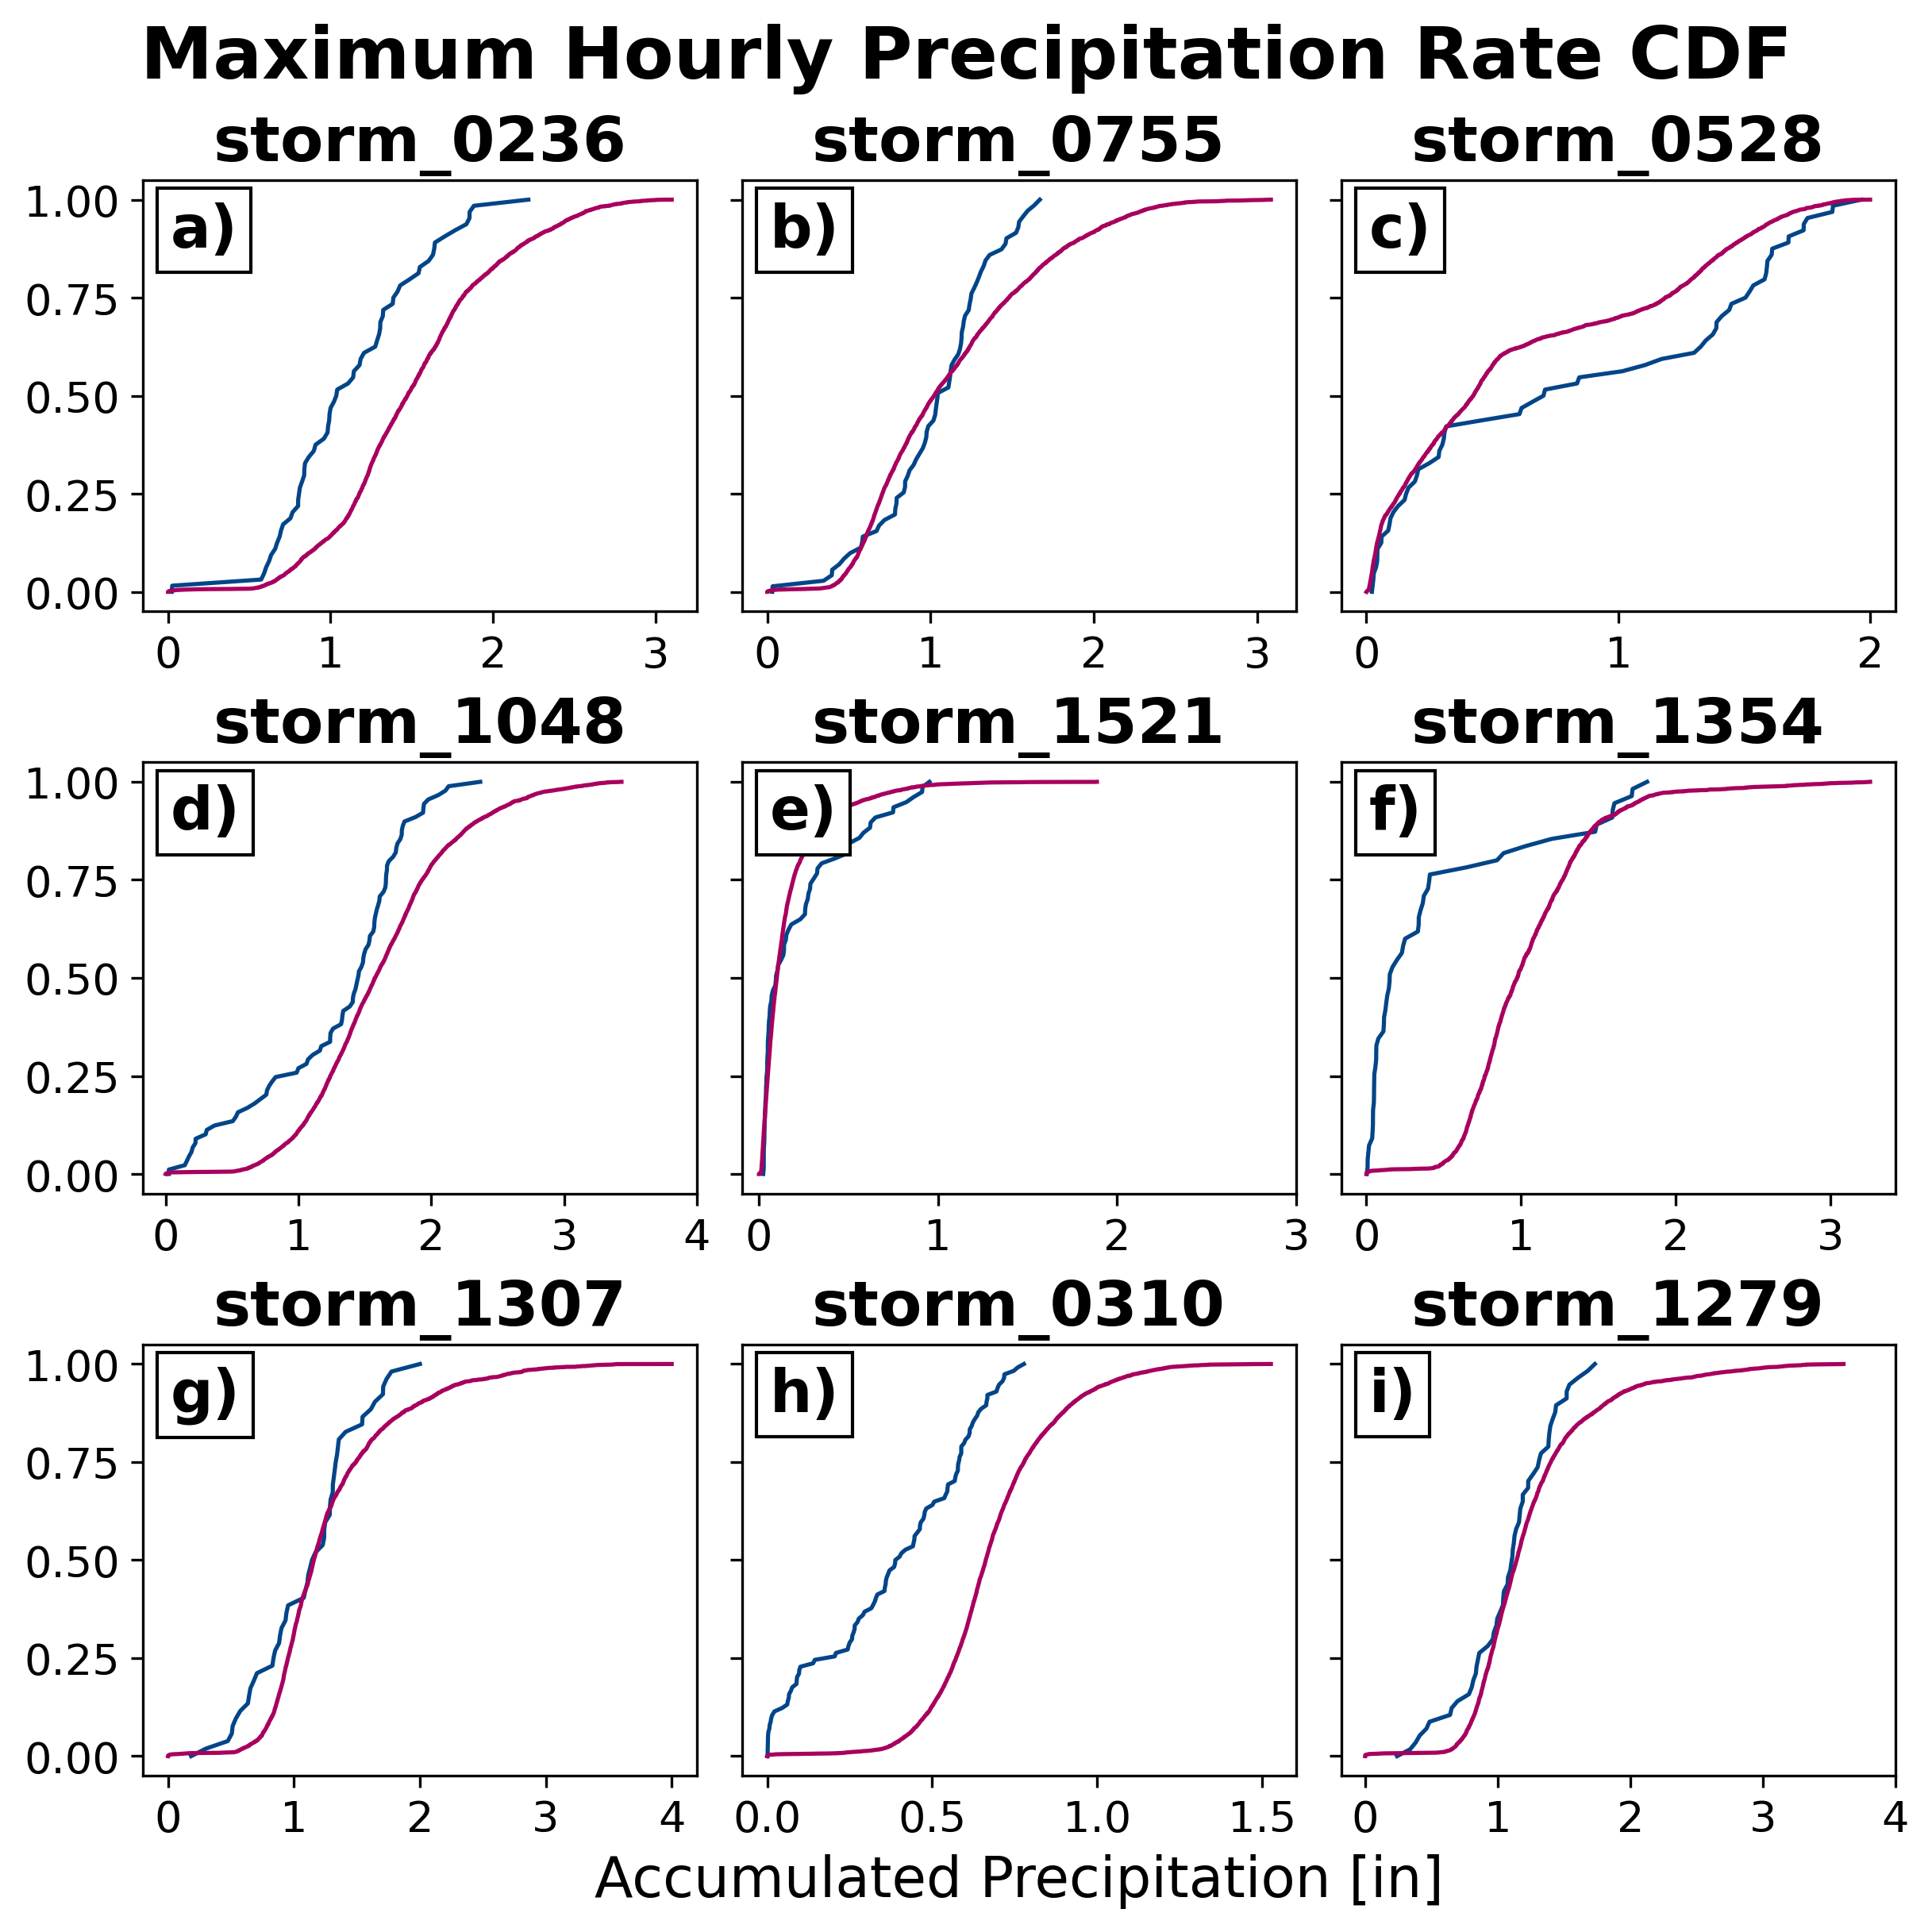

In [16]:
ds_arr=['h4pn_ds', 'h4cn_ds']
variable = 'PRECT_MAX'
storm_names = [x for x in all_storms.keys() if x not in ['Ian', 'Irma', 'Charley', 'Isaac', 'Fay']]
bboxes = [storm_0236_bbox, storm_0755_bbox, storm_0528_bbox, 
          storm_1048_bbox, storm_1521_bbox, storm_1354_bbox, 
          storm_1307_bbox, storm_0310_bbox, storm_1279_bbox]

plot_cdf(storm_names, variable, ds_arr, bboxes, output='presentation')

# Historical Storms

In [5]:
from sklearn.neighbors import KDTree

def kd_tree(locations1, locations2, metric='euclidean', neighbors=1):
    kd = KDTree(locations1, metric=metric)
    dists, idx = kd.query(locations2, k=neighbors)
    
    return idx

def get_landmask(ds, topo_ds):
    
    # Finds landmask indices
    land_lat_idx, land_lon_idx = np.where(topo_ds['LANDFRAC'].values > 0.5)

    # Finds landmask coordinates
    land_lats = topo_ds.lat.values[land_lat_idx]
    land_lons = topo_ds.lon.values[land_lon_idx]
    
    # Data coordinates
    lons = ds['lon'].isel(time=0).values
    lats = ds['lat'].isel(time=0).values
    
    # Reshapes coordinates into proper format
    ds_coords = np.dstack([lats, np.mod(lons, 180) - 180]).reshape(-1, 2)
    land_coords = np.dstack([land_lats, np.mod(land_lons, 180) - 180]).reshape(-1, 2)
    
    # Gets nearest neighbor indices
    nn_idx = kd_tree(ds_coords, land_coords)
    
    # Gets unique values and flattens array
    idx = np.unique(nn_idx.flatten())
    
    return idx

## DDF

In [40]:
%%time
# Retrieves ddf boxes of all parent storms
parent_ddf_bboxes = list(map(lambda x: get_ddf_bbox(all_storms[x]['h4pn_ds'], 'PRECT'), storms))

# Retrieves ddf boxes for real case studies
real_ddf_bboxes = [parent_ddf_bboxes[0], parent_ddf_bboxes[1], parent_ddf_bboxes[4]]

CPU times: user 43.6 s, sys: 8.59 s, total: 52.2 s
Wall time: 42 s


In [12]:
# # Colin defined bounding boxes
# irma_charley_bbox = basin_bboxes({'west_coord':-82.335520, 'east_coord':-80.042506, 'north_coord':26.919435, 'south_coord':25.137884})
# #ian_bbox = basin_bboxes({'west_coord':-81.966989, 'east_coord':-80.904318, 'north_coord':28.319877, 'south_coord':27.662304})
# #isaac_fay_bbox = (basin_bboxes({'west_coord':-82.335520, 'east_coord':-80.042506,'north_coord':26.919435, 'south_coord':25.137884}))

# isaac_bbox = (basin_bboxes({'west_coord':-82.335520, 'east_coord':-80.042506,'north_coord':26.919435, 'south_coord':25.137884}))
# fay_bbox = (basin_bboxes({'west_coord':-81.717809, 'east_coord':-80.096434,'north_coord':28.686758, 'south_coord':27.039041}))
# ian_bbox = basin_bboxes({'west_coord':-82.857622, 'east_coord':-81.090739, 'north_coord':27.921146, 'south_coord':26.627882})

In [86]:
# Corrine defined bounding boxes
irma_bbox = basin_bboxes({'west_coord':-82.335520, 'east_coord':-80.042506, 'south_coord':25.137884, 'north_coord':26.919435})
charley_bbox = basin_bboxes({'west_coord':-82.857622, 'east_coord':-80.096434, 'south_coord':26.124555, 'north_coord':28.716921})
isaac_bbox = basin_bboxes({'west_coord':-82.335520, 'east_coord':-80.042506, 'south_coord':25.137884, 'north_coord':26.919435})
fay_bbox = irma_bbox
#fay_bbox = basin_bboxes({'west_coord':-81.717809, 'east_coord':-80.096434, 'south_coord':26.610566, 'north_coord':29.191563})
ian_bbox = basin_bboxes({'west_coord':-82.857622, 'east_coord':-81.090739, 'south_coord':26.426490, 'north_coord':28.165928})

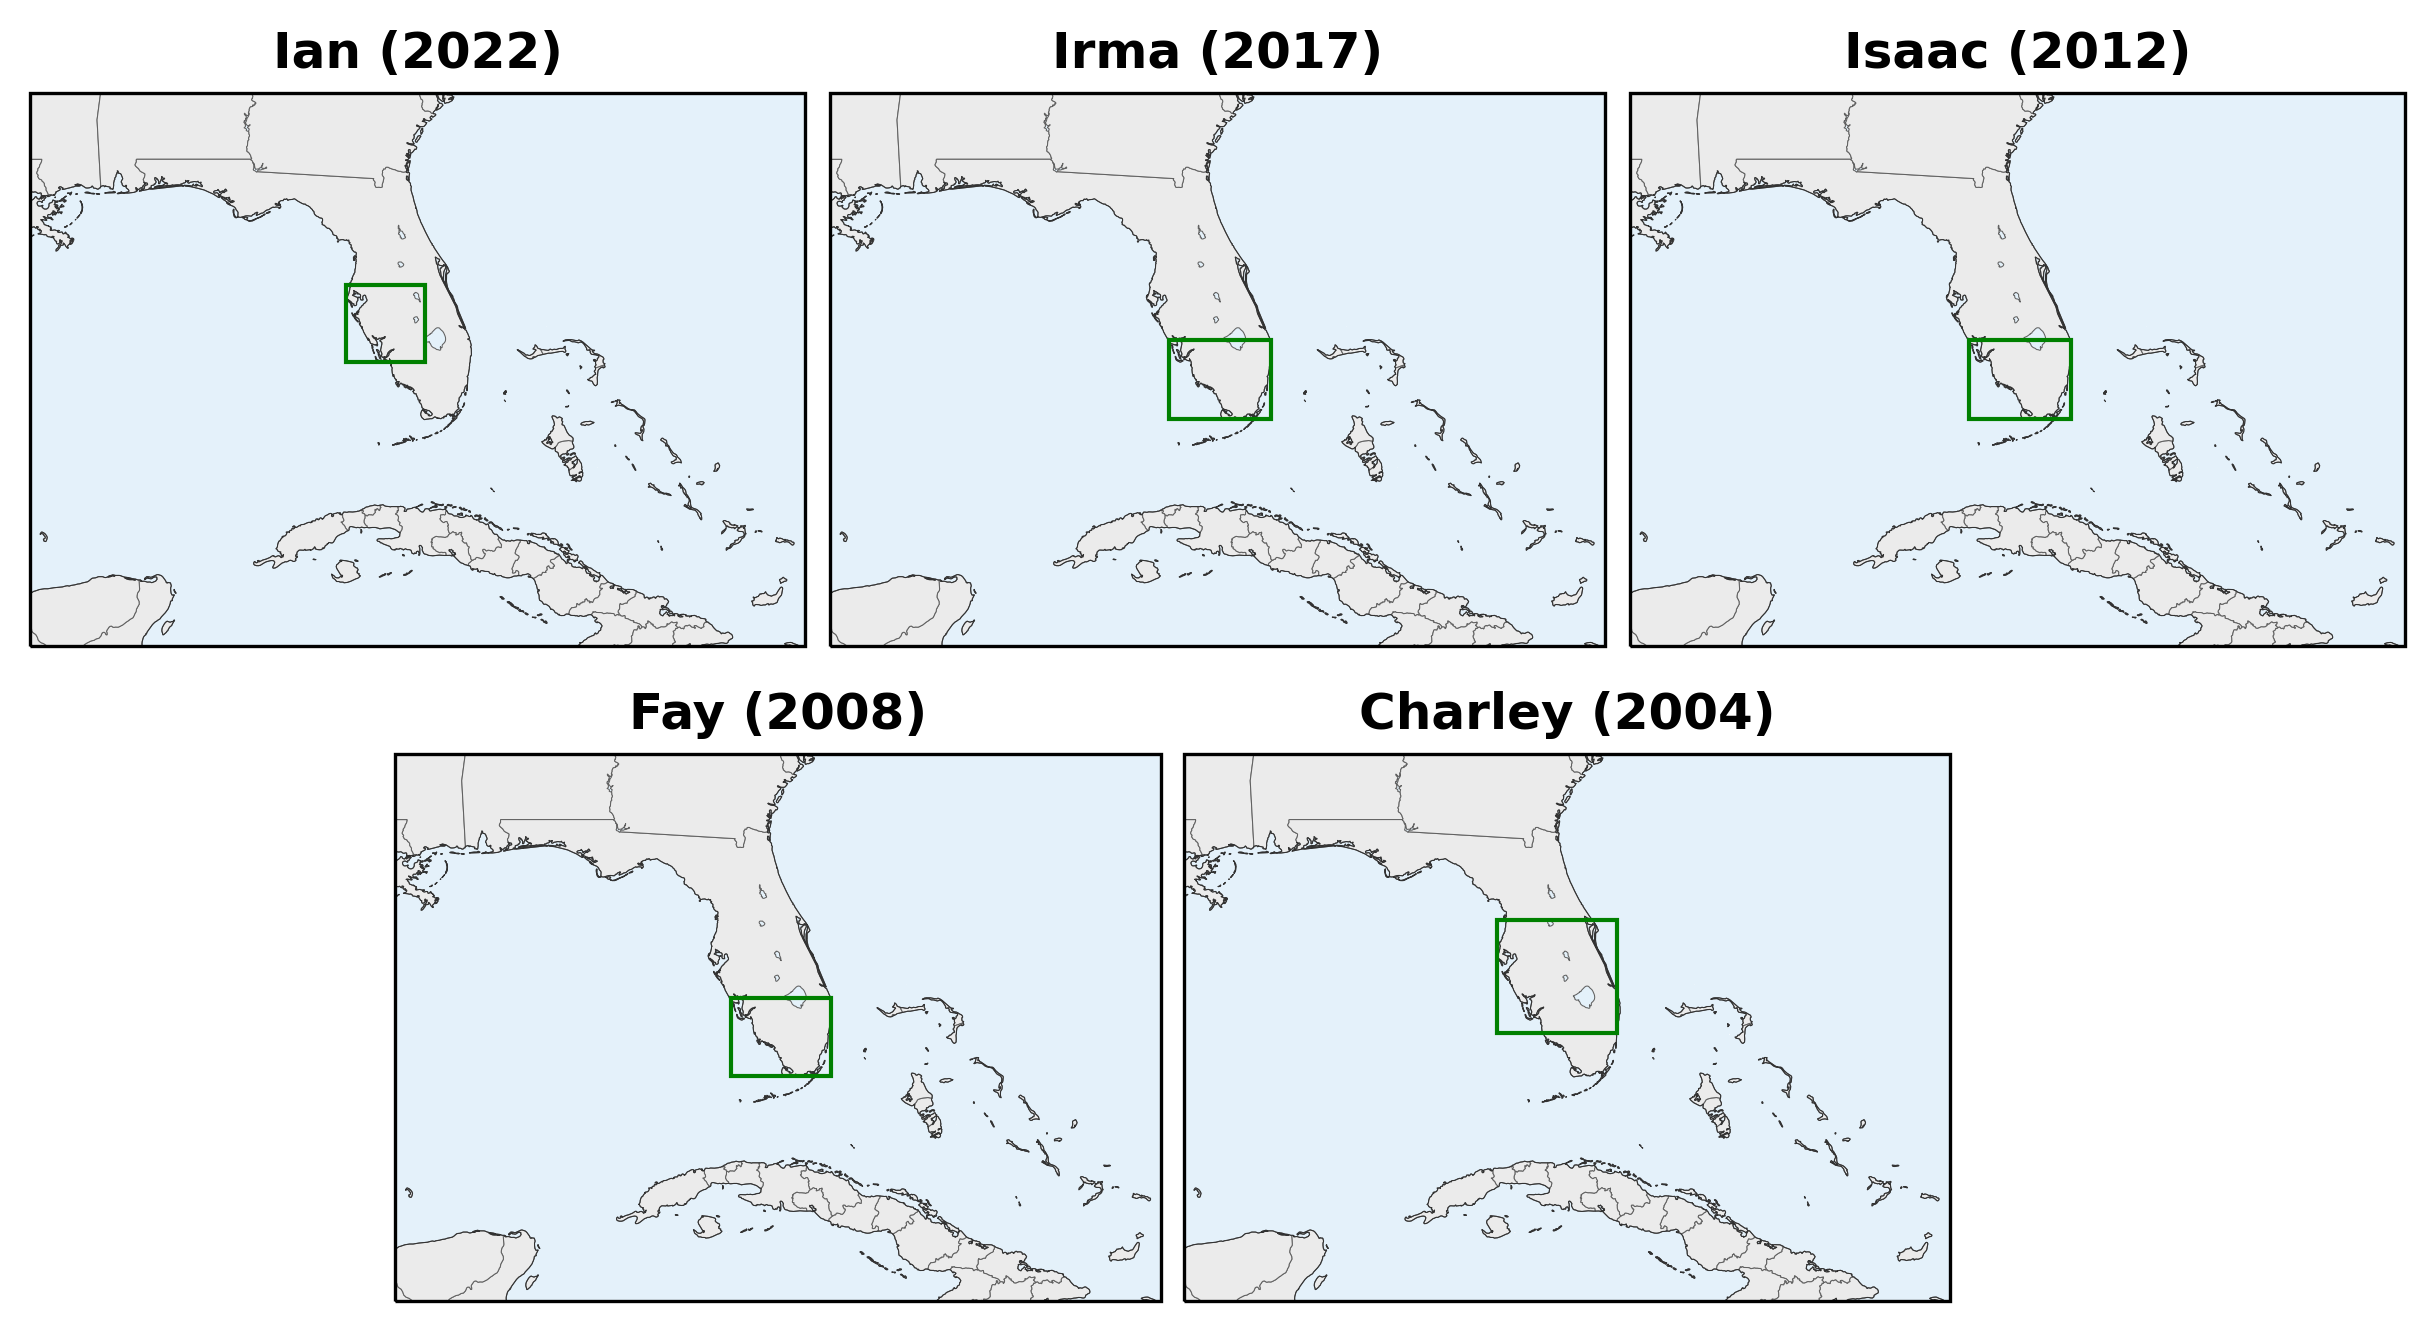

In [13]:
import matplotlib.patches as patches
# Plots for defining histogram and ddf curve spatial bbox

storm_name = ['Ian', 'Irma', 'Isaac', 'Fay', 'Charley']
storm_yrs = [2022, 2017, 2012, 2008, 2004]

# First up, DDF curve spatial plot
bbox = 'florida'
proj = ccrs.PlateCarree()
res='10m'

fig, axs = plt.subplots(2, 3, dpi=300, figsize=(8, 5.5), subplot_kw=dict(projection=proj), layout='constrained')

# Removes a subplot to center bottom two plots in 5-panel subplot
axs[1][2].set_visible(False)

# Gets bottom two plots' original positions
_, _, w, h = axs[0][0].get_position().bounds
left1, bot1, width1, height1 = axs[1][0].get_position().bounds
left2, bot2, width1, height2 = axs[1][1].get_position().bounds

# Moves bottom two subplots to center them
mult = 1.4
axs[1][0].set_position([left1+0.0325, bot1, w*mult, h*mult])
axs[1][1].set_position([left2+0.0875, bot2, w*mult, h*mult])

# Sets up plotting spatial bounds
if bbox != None:
    lons, lats = basin_bboxes(bbox)
    
for i, ax in enumerate(axs.ravel()):
    #ax.set_extent([np.mod(-83, 360), np.mod(-80, 360), 24.5, 30])
    try:
        ax.set_extent([lons[0], lons[1], lats[0], lats[1]], crs=proj)

        # Plots geographic features
        ax.add_feature(cfeature.COASTLINE.with_scale(res), linewidth=0.25, edgecolor='#323232', zorder=1.3)
        ax.add_feature(cfeature.STATES.with_scale(res), linewidth=0.25, facecolor='#EBEBEB', edgecolor='#616161', zorder=1.2)
        ax.add_feature(cfeature.LAKES.with_scale(res), linewidth=0.25, facecolor='#e4f1fa', edgecolor='#616161', zorder=1.2)
        ax.add_feature(cfeature.OCEAN.with_scale(res), facecolor='#e4f1fa', edgecolor='face', zorder=1.1)

        # Plots squares
        if i == 0:
            rect_bbox = ian_bbox
        elif i == 1:
            rect_bbox = irma_bbox
        elif i == 2:
            rect_bbox = isaac_bbox
        elif i == 3:
            rect_bbox = fay_bbox
        elif i == 4:
            rect_bbox = charley_bbox
        rect_lon = rect_bbox[0][0]
        rect_lat = rect_bbox[1][0]
        x_dist = rect_bbox[0][1] - rect_bbox[0][0]
        y_dist = rect_bbox[1][1] - rect_bbox[1][0]
        rect = patches.Rectangle(xy=[rect_lon, rect_lat], width=x_dist, height=y_dist, transform=proj, 
                                 zorder=10, facecolor='none', edgecolor='green')
        ax.add_patch(rect)

        ax.set_title(f'{storm_name[i]} ({storm_yrs[i]})', fontweight='bold')
    except:
        continue

plt.show()
plt.close()

In [108]:
ds_arr=['h4pn_ds', 'h4cn_ds']
storm_name = ['Ian', 'Irma', 'Isaac', 'Fay']
variable = 'PRECT'
rolling_windows = [1, 3, 6, 12, 24, 36, 48, 72, 96, 120]
bboxes = [ian_bbox, irma_bbox, isaac_bbox, fay_bbox]

# Packs target datasets into list
storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_name))

# Retrieves maximum and percentile arrays
# max_arrs, percentile_arrs = zip(*map(lambda x: zip(*map(calc_ddf, x, 
#                                                         [variable]*len(ds_arr), 
#                                                         bboxes, 
#                                                         [rolling_windows]*len(ds_arr))), 
#                                      storm_list))

max_arrs = []
percentile_arrs = []

for i, storm in enumerate(storm_list):
    marr = []
    parr = []
    for ds in storm:
        max_arr, perc_arr = calc_ddf(ds, variable, bboxes[i], rolling_windows)
        marr.append(max_arr)
        parr.append(perc_arr)
    max_arrs.append(marr)
    percentile_arrs.append(parr)

#max_arrs, percentile_arrs = zip([lambda x: calc_ddf(x, variable, bboxes[i], rolling_windows) for i, storm in enumerate(storm_list)])

# Takes median, 5th-, and 95th- percentiles
percentile_arrs = np.array(percentile_arrs)
p5 = percentile_arrs[:, :, 0]
medians = percentile_arrs[:, :, 1]
p95 = percentile_arrs[:, :, 2]

# Converts max_arrs to numpy array
max_arrs = np.array(max_arrs)

In [102]:
irma_max_arr, irma_percs = nexrad_ddf(irma_ds, irma_bbox, rolling_windows)
ian_max_arr, ian_percs = nexrad_ddf(ian_ds, ian_bbox, rolling_windows)
isaac_max_arr, isaac_percs = nexrad_ddf(isaac_ds, isaac_bbox, rolling_windows)
fay_max_arr, fay_percs = nexrad_ddf(fay_ds, fay_bbox, rolling_windows)
#charley_max_arr, charley_percs = nexrad_ddf(charley_ds, charley_bbox, rolling_windows)

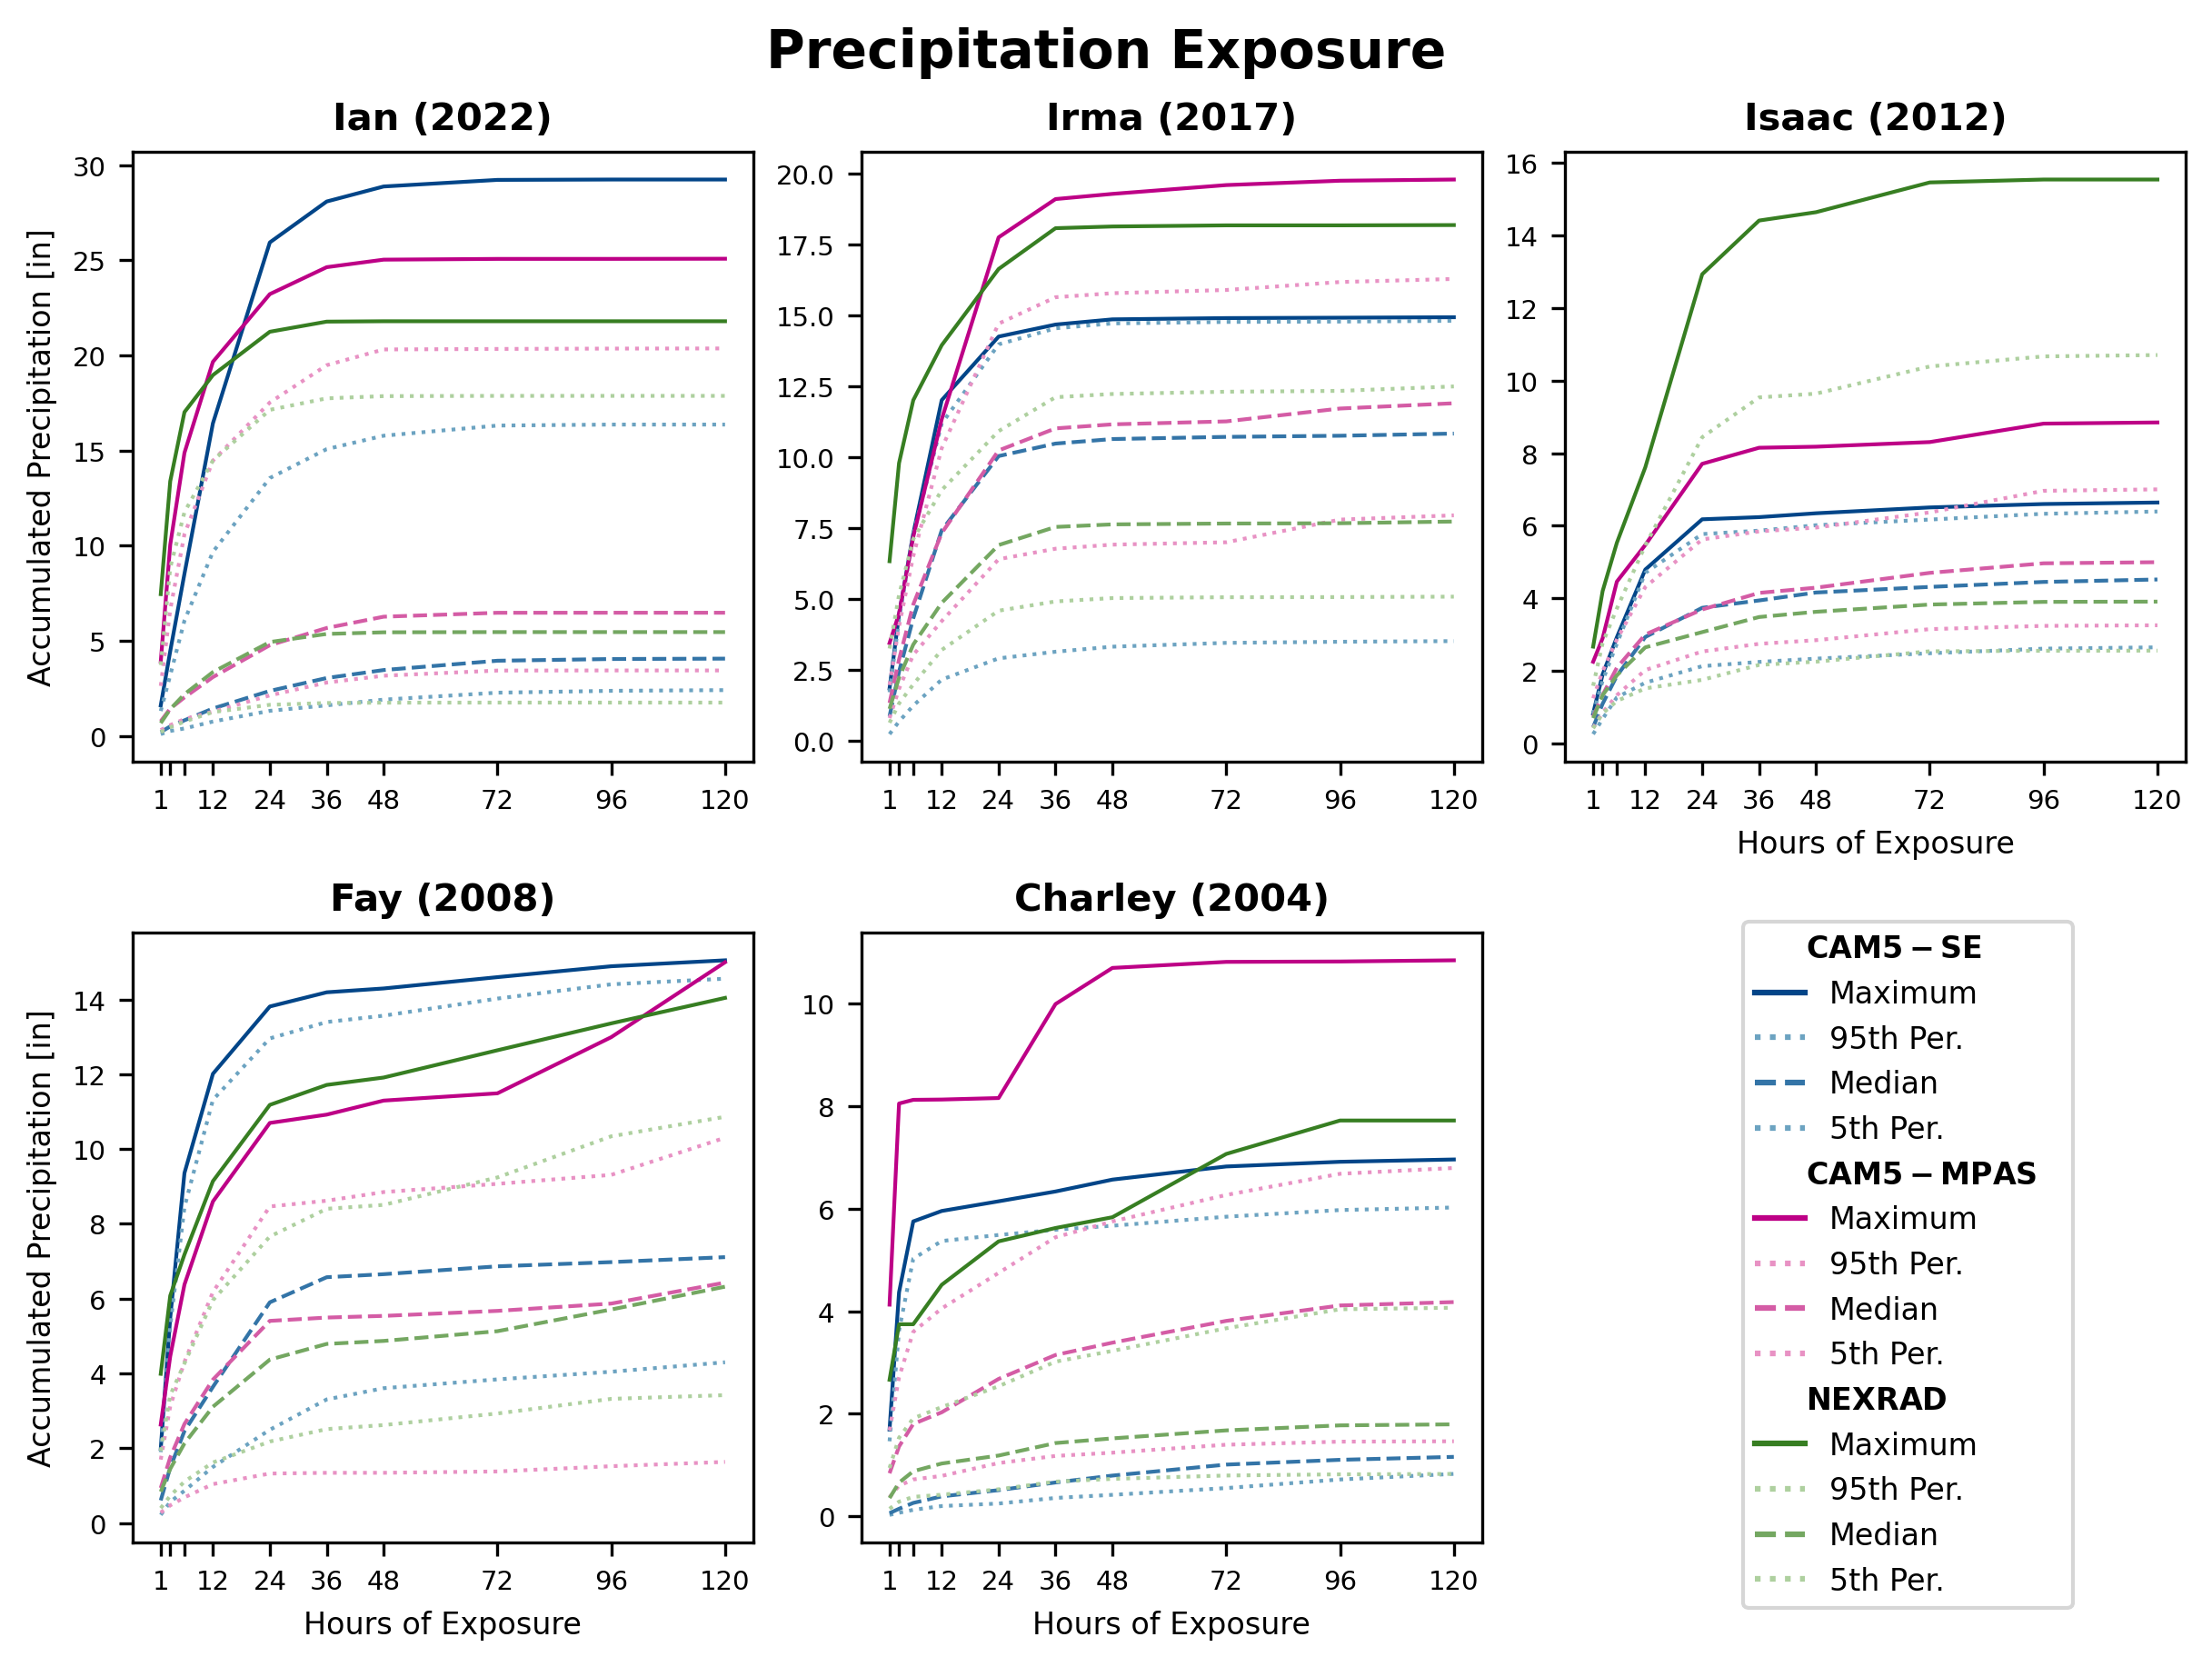

In [17]:
font_kw = {'labels':8, 'titles':10, 'ticks':7, 'legend':8}
plot_kw = {'lw':1.0, 'ylabel':'Accumulated Precipitation [in]', 
           'xlabel':'Hours of Exposure', 'figtitle':'Precipitation Exposure'}
fig_kw = {'ncols': 3, 'nrows': 2, 'figsize': (8, 6), 'dpi':300, 'layout':'constrained'}
cam_colors = ['#024588', '#6ca3c1', '#3374a7', '#6ca3c1']
mpas_colors = ['#bd0086', '#e892c4', '#d45ca5', '#e892c4']
nexrad_colors = ['#377E22', '#aed09f', '#74a761', '#aed09f']

storm_yrs = [2022, 2017, 2012, 2008, 2004]

# Fishes out number of storms and number of ds based on max_arrs dims
nstorms = max_arrs.shape[0]
nds = max_arrs.shape[1]

# Plots output
fig, axs = plt.subplots(**fig_kw)

# Removes a subplot to center bottom two plots in 5-panel subplot
axs[1][2].set_visible(False)

# Packs nexrad max_arrs and percs_arrs into lists
max_arrs_nexrad = [ian_max_arr, irma_max_arr, isaac_max_arr, fay_max_arr, charley_max_arr]
percs_5_arrs_nexrad = [ian_percs[0].flatten(), irma_percs[0].flatten(), 
                       isaac_percs[0].flatten(), fay_percs[0].flatten(), charley_percs[0].flatten()]
percs_med_arrs_nexrad = [ian_percs[1].flatten(), irma_percs[1].flatten(), 
                       isaac_percs[1].flatten(), fay_percs[1].flatten(), charley_percs[1].flatten()]
percs_95_arrs_nexrad = [ian_percs[2].flatten(), irma_percs[2].flatten(), 
                       isaac_percs[2].flatten(), fay_percs[2].flatten(), charley_percs[2].flatten()]

for i, ax in enumerate(axs.ravel()):
    
    x_axis = rolling_windows
    
    lcolor = [cam_colors, mpas_colors]
    try:
        if nds == 2:
            for j in range(nds):
                ax.plot(x_axis, max_arrs[i][j].flatten(), label='Maximum', c=lcolor[j][0], lw=plot_kw['lw'])
                ax.plot(x_axis, p5[i][j].flatten(), label='5th Percentile', ls=':', c=lcolor[j][1], lw=plot_kw['lw'])
                ax.plot(x_axis, medians[i][j].flatten(), label='Median', ls='--', c=lcolor[j][2], lw=plot_kw['lw'])
                ax.plot(x_axis, p95[i][j].flatten(), label='95th Percentile', ls=':', c=lcolor[j][3], lw=plot_kw['lw'])

            ax.plot(x_axis, max_arrs_nexrad[i], c=nexrad_colors[0], lw=plot_kw['lw'])
            ax.plot(x_axis, percs_5_arrs_nexrad[i], 
                    ls=':', c=nexrad_colors[1], lw=plot_kw['lw'])
            ax.plot(x_axis, percs_med_arrs_nexrad[i], 
                    ls='--', c=nexrad_colors[2], lw=plot_kw['lw'])
            ax.plot(x_axis, percs_95_arrs_nexrad[i], 
                    ls=':', c=nexrad_colors[3], lw=plot_kw['lw'])

        ax.set_title(f'{storm_name[i]} ({storm_yrs[i]})', fontsize=font_kw['titles'], fontweight='heavy')

        ax.tick_params(axis='both', labelsize=font_kw['ticks'])

        if i in [0, 1, 2, 3, 4]:
            if len(x_axis) == 10:
                xlabs = [1, '', '', 12, 24, 36, 48, 72, 96, 120]
            elif len(x_axis) == 9:
                xlabs = [3, '', 12, 24, 36, 48, 72, 96, 120]
            ax.set_xticks(x_axis, xlabs)

        if i in [2, 3, 4]:
            ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'])

        if i in [0, 3]:
            ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'])
    except:
        continue

fig.suptitle(plot_kw['figtitle'], fontsize=font_kw['titles']+4, fontweight='bold')

llabels = [r'$\bf{CAM5-SE}$', 'Maximum', '95th Per.', 'Median', '5th Per.', 
           r'$\bf{CAM5-MPAS}$', 'Maximum', '95th Per.', 'Median', '5th Per.', 
           r'$\bf{NEXRAD}$', 'Maximum', '95th Per.', 'Median', '5th Per.']
lcolors = ['none', *cam_colors, 'none', *mpas_colors, 'none', *nexrad_colors]
lstyles = ['none', '-', ':', '--', ':', 'none', '-', ':', '--', ':', 'none', '-', ':', '--', ':']
style_dict = {'xdata': [], 'ydata': [], 'lw': 1.5}
handles = [mlines.Line2D(label=l, color=c, ls=ls, **style_dict) for (l, c, ls) in 
           zip(llabels, lcolors, lstyles)]
leg = fig.legend(handles=handles, fontsize=font_kw['legend'], alignment='center', 
          ncols=1, handlelength=1.65, bbox_to_anchor=(0.95, 0.455))

for i, (item, label) in enumerate(zip(leg.legend_handles, leg.get_texts())):
    if label._text in [llabels[0], llabels[5], llabels[10]]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha('left')
        label.set_position((-2*width, 0))

plt.show()
plt.close()

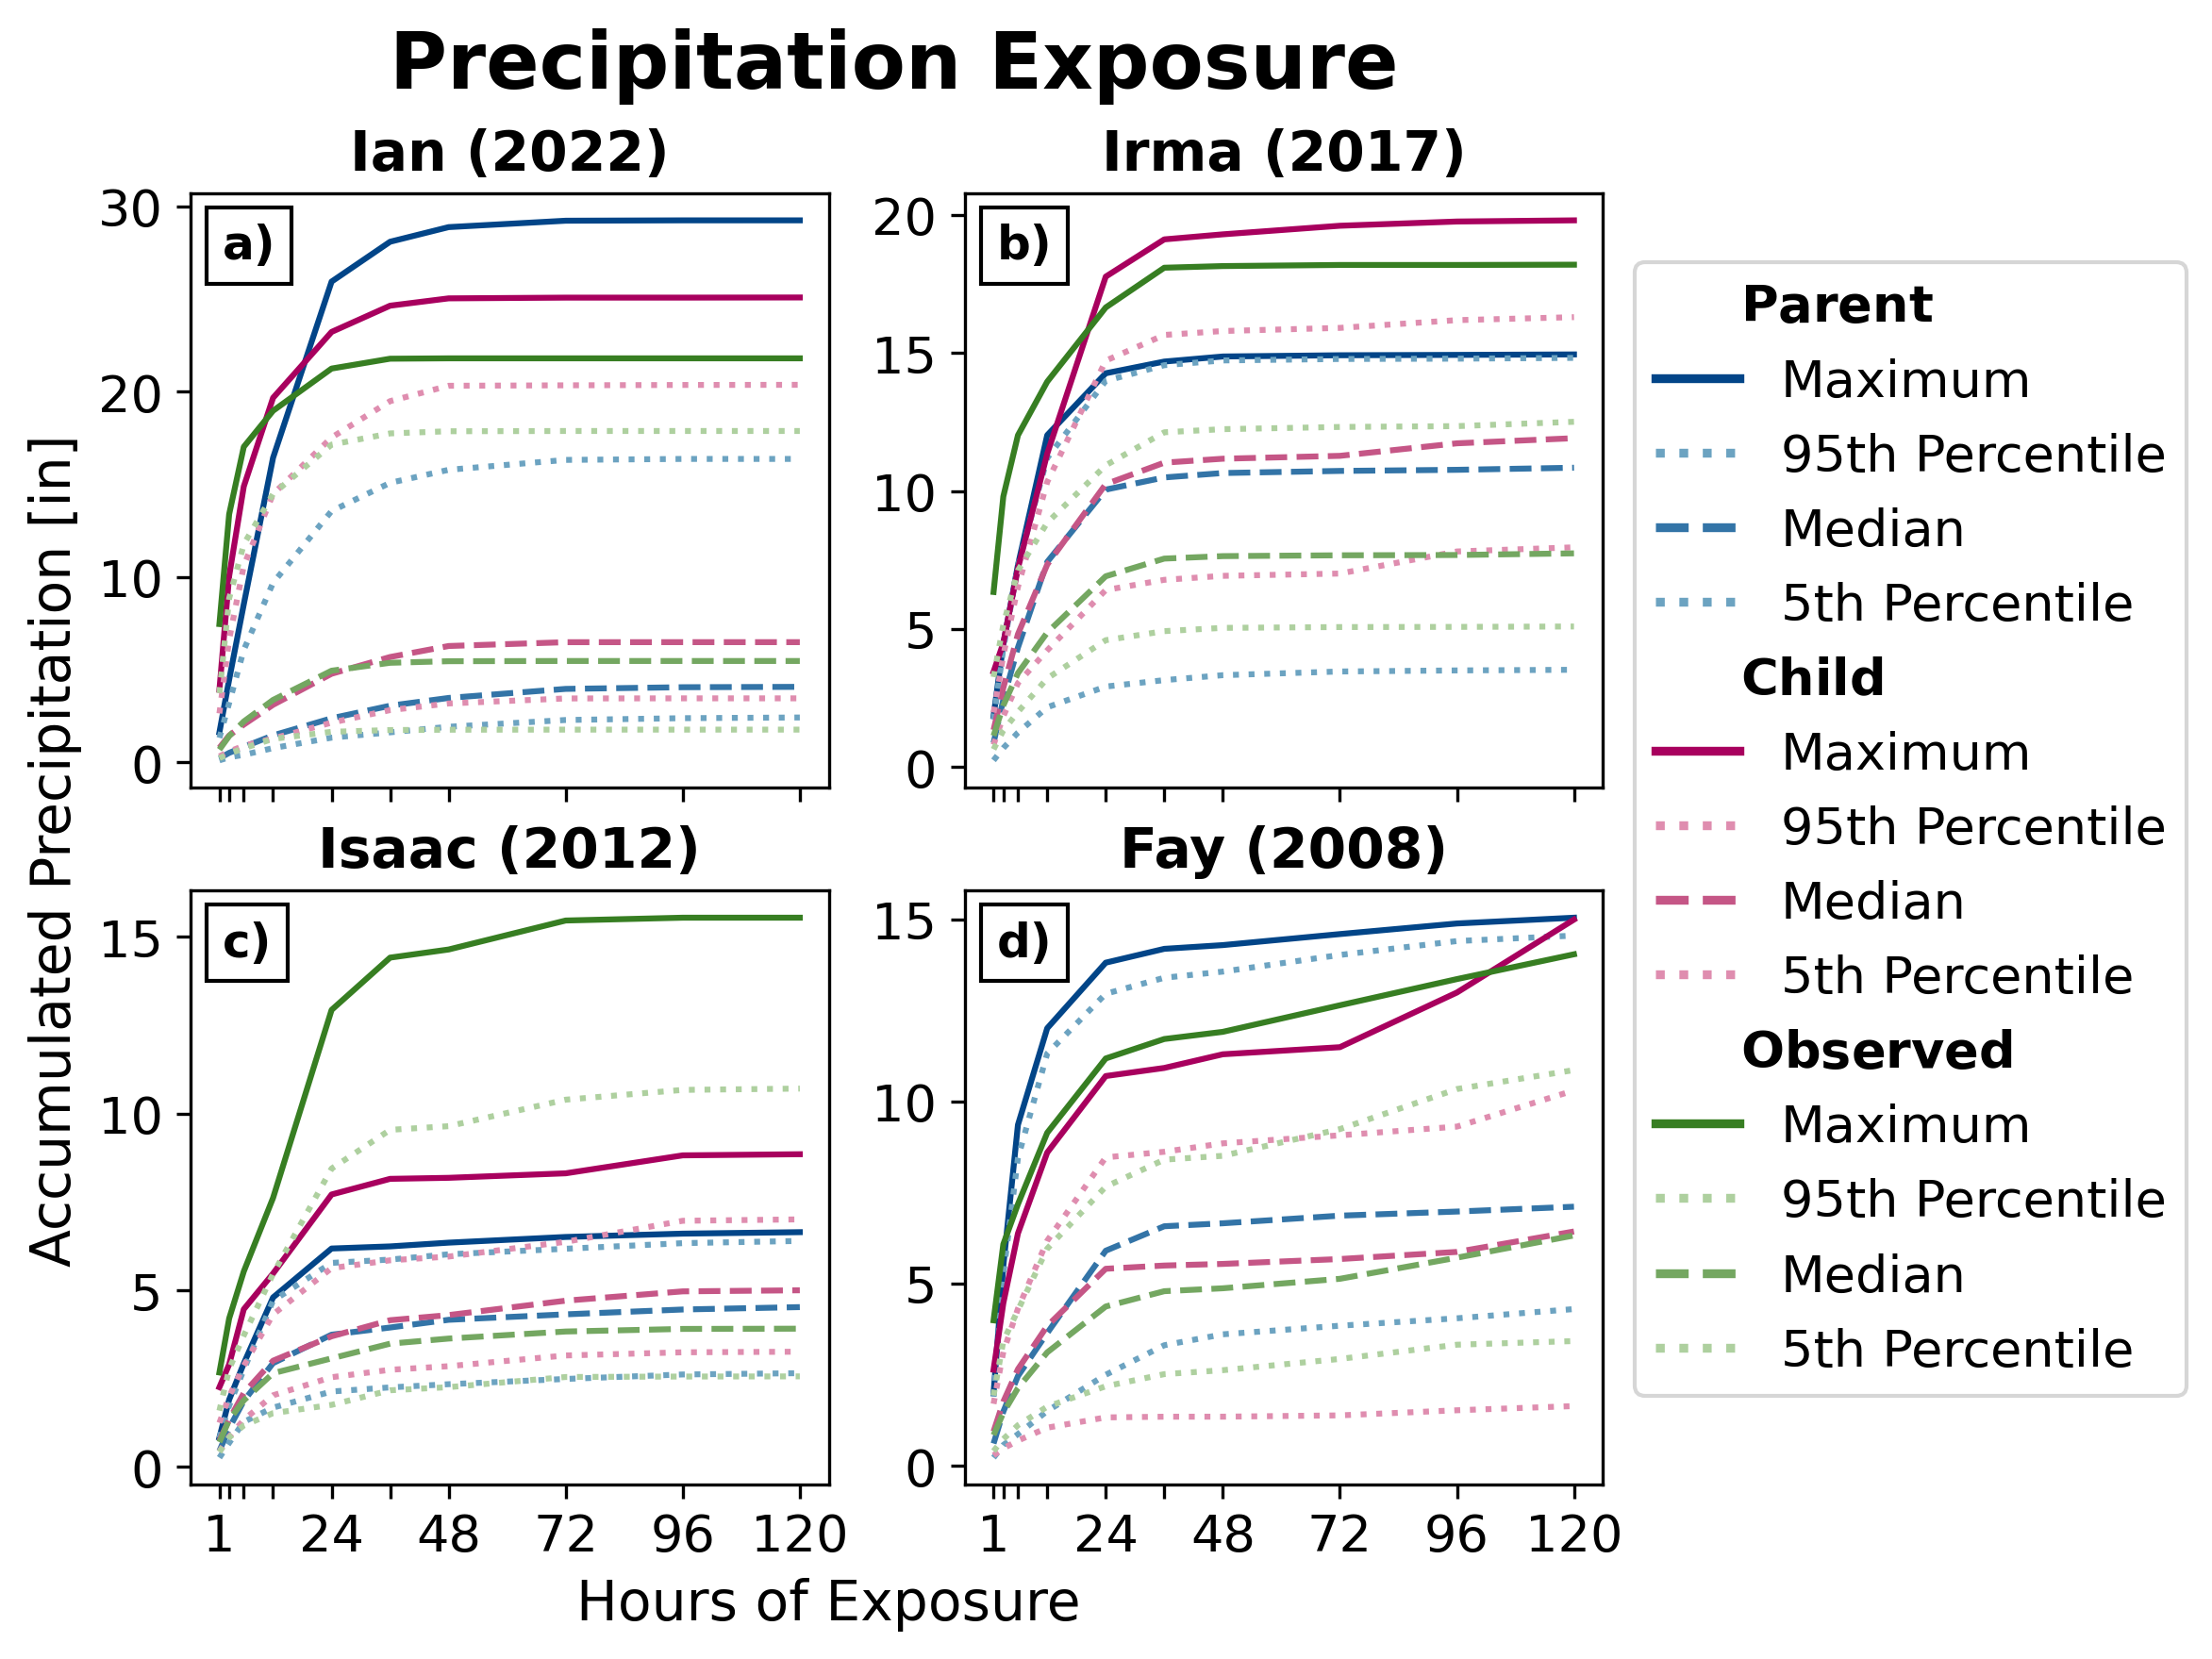

In [109]:
#output = 'paper'
output = 'presentation'

plot_kw = {'lw':1.25, 'ylabel':'Accumulated Precipitation [in]', 
           'xlabel':'Hours of Exposure', 'figtitle':'Precipitation Exposure'}

if output == 'paper':
    font_kw = {'labels':11, 'titles':12, 'ticks':10, 'legend':11, 'figtitle':14}
elif output == 'presentation':
    font_kw = {'labels':14, 'titles':14, 'ticks':13, 'legend':13, 'figtitle':20}
    plot_kw['lw'] = 1.5
    
fig_kw = {'ncols': 2, 'nrows': 2, 'figsize': (6.2, 7.44), 'dpi':300, 'layout':'constrained', 'sharex':True}

if output == 'presentation':
    fig_kw['figsize'] = (7.75, 5.75)

cam_colors = ['#024588', '#6ca3c1', '#3374a7', '#6ca3c1']
#mpas_colors = ['#bd0086', '#e892c4', '#d45ca5', '#e892c4']
mpas_colors = ['#a8005e', '#df8daf', '#c55686', '#df8daf']
nexrad_colors = ['#377E22', '#aed09f', '#74a761', '#aed09f']

storm_name = ['Ian', 'Irma', 'Isaac', 'Fay']
storm_yrs = [2022, 2017, 2012, 2008]

labs = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)']
labs = labs[:len(storm_name)]
labs_dict = dict(facecolor='white', edgecolor='k')

# Fishes out number of storms and number of ds based on max_arrs dims
nstorms = max_arrs.shape[0]
nds = max_arrs.shape[1]

# Plots output
fig, axs = plt.subplots(**fig_kw)

# Packs nexrad max_arrs and percs_arrs into lists
max_arrs_nexrad = [ian_max_arr, irma_max_arr, isaac_max_arr, fay_max_arr]
percs_5_arrs_nexrad = [ian_percs[0].flatten(), irma_percs[0].flatten(), 
                       isaac_percs[0].flatten(), fay_percs[0].flatten()]
percs_med_arrs_nexrad = [ian_percs[1].flatten(), irma_percs[1].flatten(), 
                       isaac_percs[1].flatten(), fay_percs[1].flatten()]
percs_95_arrs_nexrad = [ian_percs[2].flatten(), irma_percs[2].flatten(), 
                       isaac_percs[2].flatten(), fay_percs[2].flatten()]

for i, ax in enumerate(axs.ravel()):
    
    x_axis = rolling_windows
    
    lcolor = [cam_colors, mpas_colors]
    if nds == 2:
        for j in range(nds):
            ax.plot(x_axis, max_arrs[i][j].flatten(), label='Maximum', c=lcolor[j][0], lw=plot_kw['lw'])
            ax.plot(x_axis, p5[i][j].flatten(), label='5th Percentile', ls=':', c=lcolor[j][1], lw=plot_kw['lw'])
            ax.plot(x_axis, medians[i][j].flatten(), label='Median', ls='--', c=lcolor[j][2], lw=plot_kw['lw'])
            ax.plot(x_axis, p95[i][j].flatten(), label='95th Percentile', ls=':', c=lcolor[j][3], lw=plot_kw['lw'])

        ax.plot(x_axis, max_arrs_nexrad[i], c=nexrad_colors[0], lw=plot_kw['lw'])
        ax.plot(x_axis, percs_5_arrs_nexrad[i], 
                ls=':', c=nexrad_colors[1], lw=plot_kw['lw'])
        ax.plot(x_axis, percs_med_arrs_nexrad[i], 
                ls='--', c=nexrad_colors[2], lw=plot_kw['lw'])
        ax.plot(x_axis, percs_95_arrs_nexrad[i], 
                ls=':', c=nexrad_colors[3], lw=plot_kw['lw'])

    ax.set_title(f'{storm_name[i]} ({storm_yrs[i]})', fontsize=font_kw['titles'], fontweight='heavy')
        
    if output == 'paper':
        # if i in [0, 2]:
        #     ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'])
        # if i in [2, 3]:
        #     ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'])
        if i == 2:
            ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'], y=1.07)
            ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'], x=1.0)
        xlabs = [1, '', '', 12, 24, 36, 48, 72, 96, 120]
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
        
    elif output == 'presentation':
        if i == 2:
            ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'], y=1.07)
            ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'], x=1.00)
        xlabs = [1, '', '', '', 24, '', 48, 72, 96, 120]
                
    ax.set_xticks(x_axis, xlabs)
    #ax.set_xticklabels(xlabs, rotation = 30, ha="center")
    ax.tick_params(axis='both', labelsize=font_kw['ticks'])
    
    # Adds labels
    text_kw = dict(verticalalignment='top', transform=ax.transAxes, fontsize=10, fontweight='bold', bbox=labs_dict, zorder=100)
    if output== 'presentation':
        text_kw['fontsize'] = 12
    ax.text(0.05, 0.95, labs[i], **text_kw)
                
if output == 'paper':
    figtitle_x = 0.5
elif output == 'presentation':
    figtitle_x = 0.4
    
fig.suptitle(plot_kw['figtitle'], fontsize=font_kw['figtitle'], fontweight='bold',  x=figtitle_x)

stats_labs = ['Maximum', '95th Percentile', 'Median', '5th Percentile']
llabels = [r'$\bf{CAM5-SE}$', *stats_labs, 
           r'$\bf{CAM5-MPAS}$', *stats_labs, 
           r'$\bf{NEXRAD}$', *stats_labs]
if output == 'presentation':
    llabels = [r'$\bf{Parent}$', *stats_labs, 
           r'$\bf{Child}$', *stats_labs, 
           r'$\bf{Observed}$', *stats_labs]

lcolors = ['none', *cam_colors, 'none', *mpas_colors, 'none', *nexrad_colors]
lstyles = ['none', '-', ':', '--', ':', 'none', '-', ':', '--', ':', 'none', '-', ':', '--', ':']
style_dict = {'xdata': [], 'ydata': [], 'lw': plot_kw['lw']*1.5}
handles = [mlines.Line2D(label=l, color=c, ls=ls, **style_dict) for (l, c, ls) in 
           zip(llabels, lcolors, lstyles)]

legend_kw = dict(handles=handles, fontsize=font_kw['legend'], loc='outside lower center', 
          ncols=3, handlelength=1.65)

if output == 'presentation':
    legend_kw['ncols'] = 1
    legend_kw['loc'] = 'outside right center'
    #legend_kw['columnspacing'] = 1.0
# elif output == 'paper':
#     legend_kw['bbox_to_anchor'] = (0.525, -0.25)
    
    
leg = fig.legend(**legend_kw)

for i, (item, label) in enumerate(zip(leg.legend_handles, leg.get_texts())):
    if label._text in [llabels[0], llabels[5], llabels[10]]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha('left')
        label.set_position((-2*width, 0))

plt.show()
plt.close()

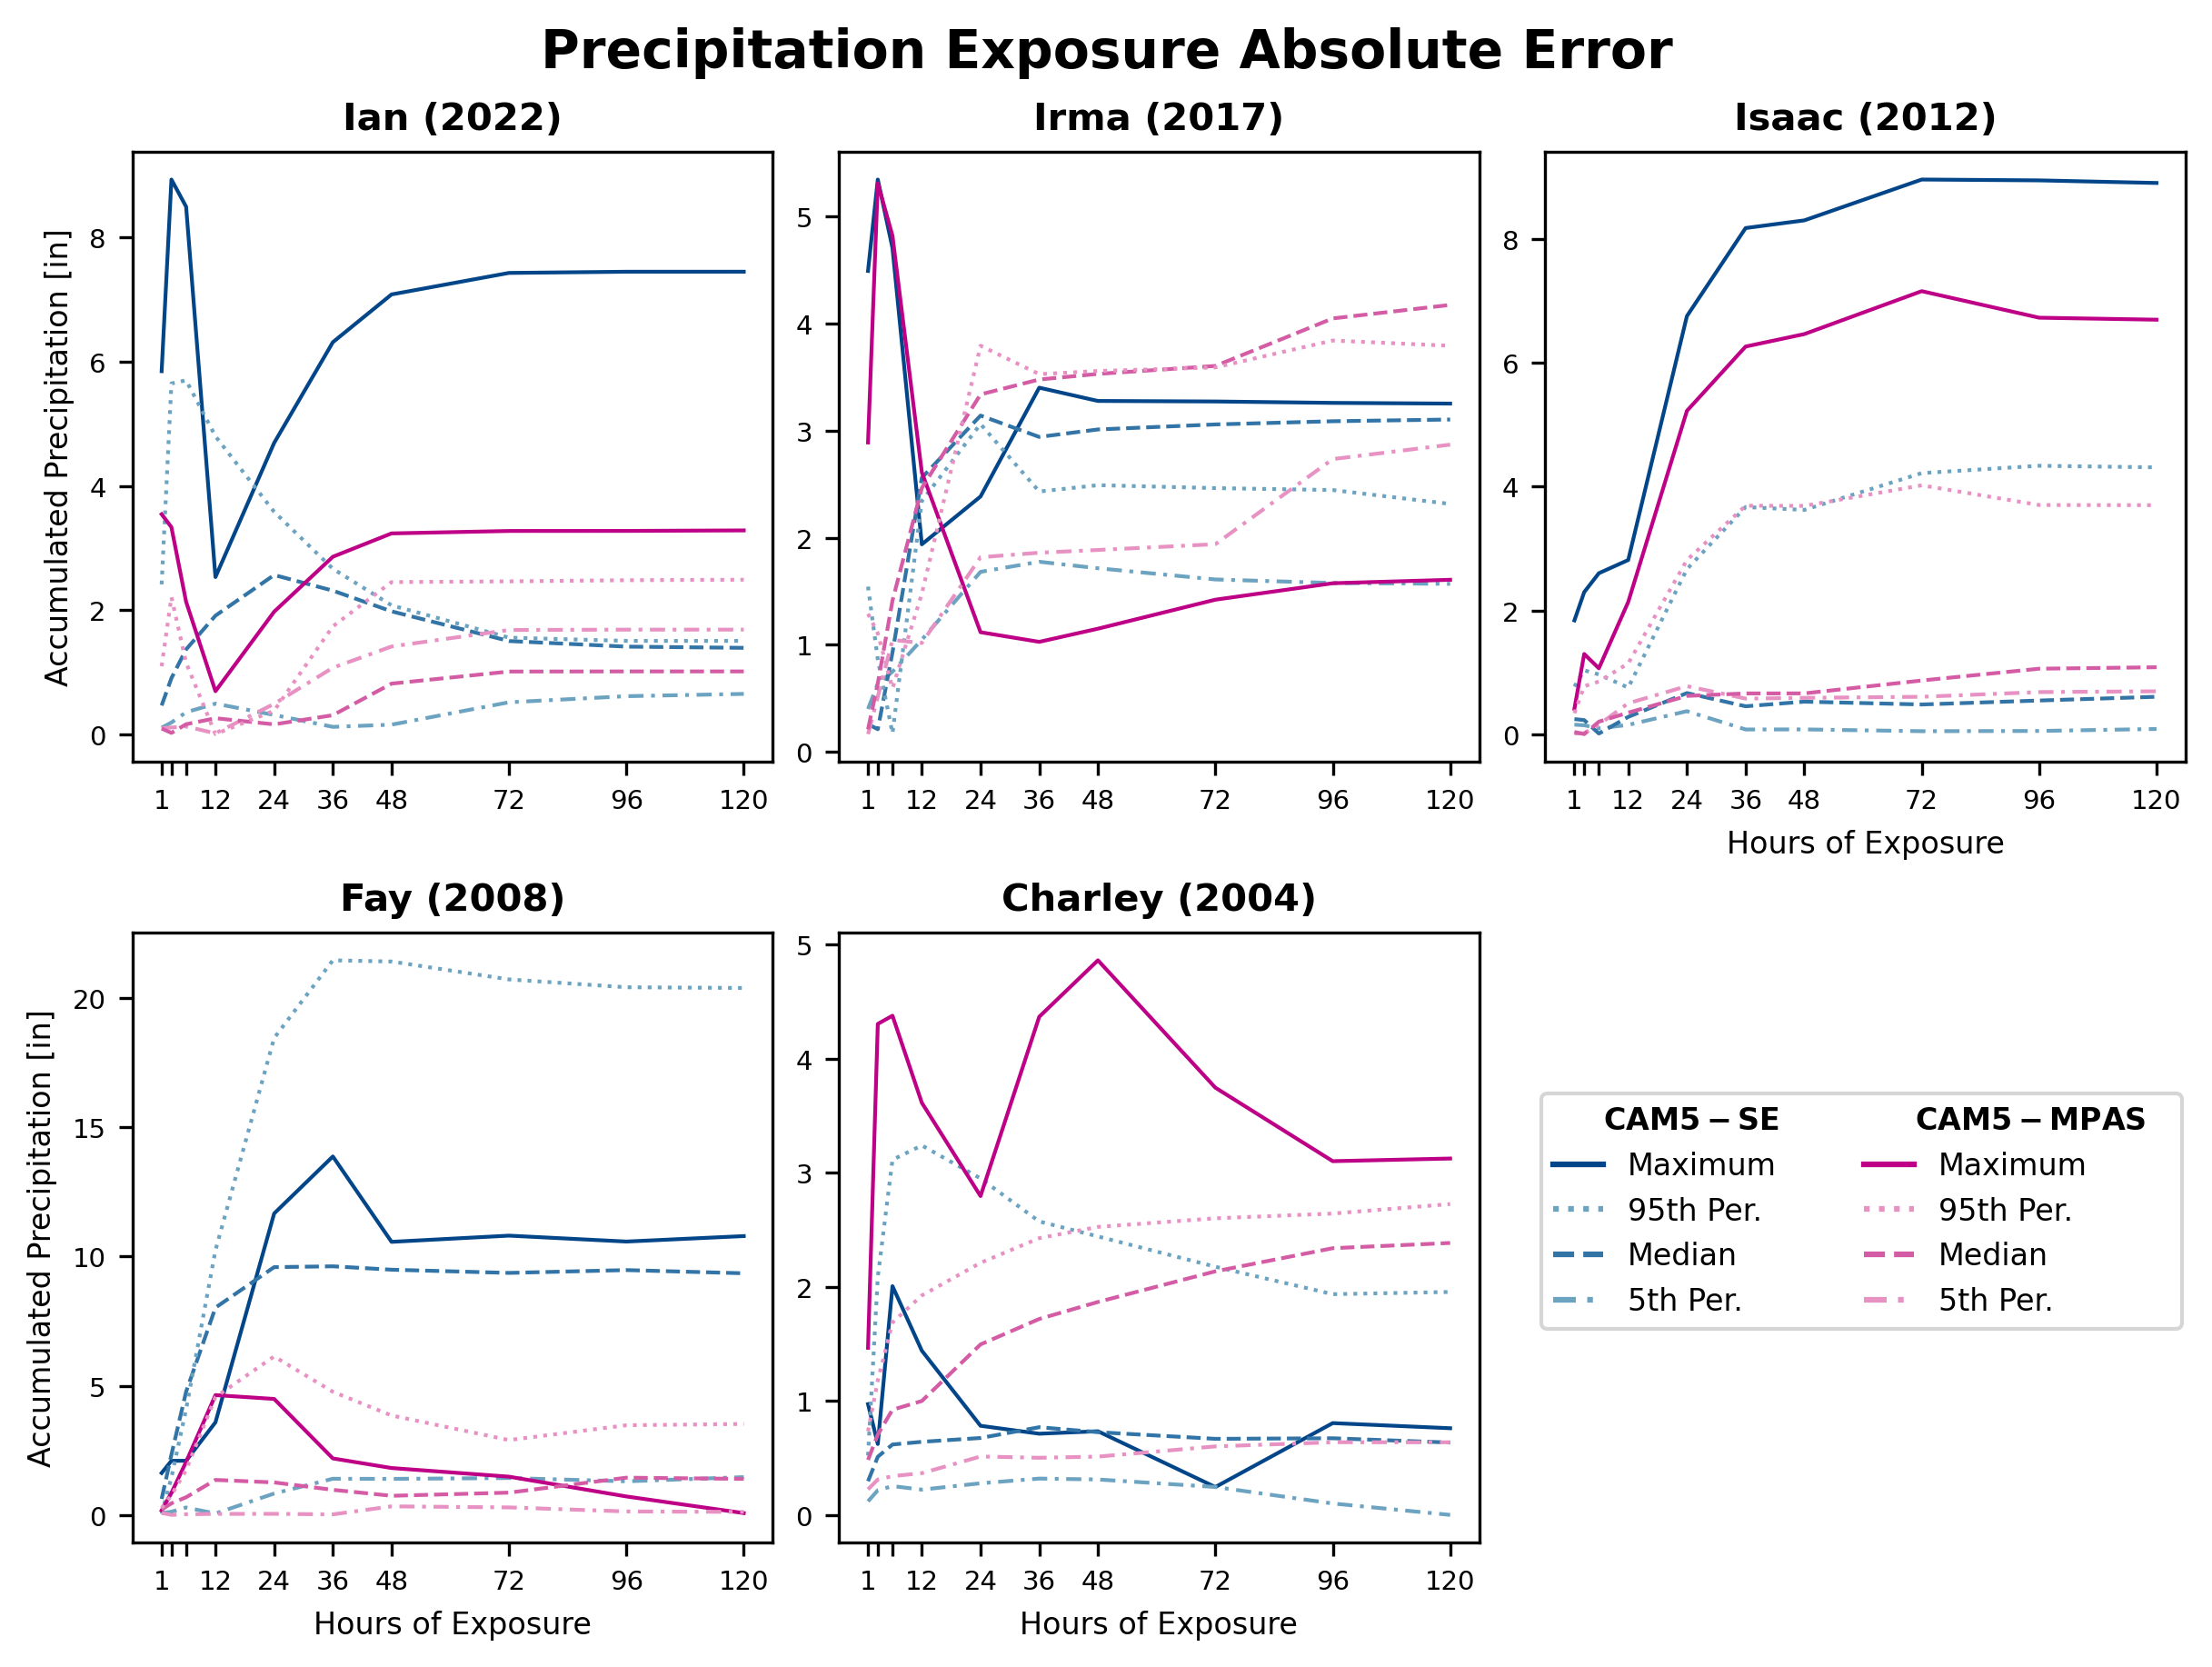

In [20]:
font_kw = {'labels':8, 'titles':10, 'ticks':7, 'legend':8}
plot_kw = {'lw':1.0, 'ylabel':'Accumulated Precipitation [in]', 
           'xlabel':'Hours of Exposure', 'figtitle':'Precipitation Exposure Absolute Error'}
fig_kw = {'ncols': 3, 'nrows': 2, 'figsize': (8, 6), 'dpi':300, 'layout':'constrained'}
cam_colors = ['#024588', '#6ca3c1', '#3374a7', '#6ca3c1']
mpas_colors = ['#bd0086', '#e892c4', '#d45ca5', '#e892c4']
#nexrad_colors = ['#377E22', '#aed09f', '#74a761', '#aed09f']

storm_yrs = [2022, 2017, 2012, 2008, 2004]

# Fishes out number of storms and number of ds based on max_arrs dims
nstorms = max_arrs.shape[0]
nds = max_arrs.shape[1]

# Packs nexrad max_arrs and percs_arrs into lists
max_arrs_nexrad = [ian_max_arr, irma_max_arr, isaac_max_arr, fay_max_arr, charley_max_arr]
percs_5_arrs_nexrad = [ian_percs[0].flatten(), irma_percs[0].flatten(), 
                       isaac_percs[0].flatten(), fay_percs[0].flatten(), charley_percs[0].flatten()]
percs_med_arrs_nexrad = [ian_percs[1].flatten(), irma_percs[1].flatten(), 
                       isaac_percs[1].flatten(), fay_percs[1].flatten(), charley_percs[1].flatten()]
percs_95_arrs_nexrad = [ian_percs[2].flatten(), irma_percs[2].flatten(), 
                       isaac_percs[2].flatten(), fay_percs[2].flatten(), charley_percs[2].flatten()]

# Plots output
fig, axs = plt.subplots(**fig_kw)

# Removes a subplot to center bottom two plots in 5-panel subplot
axs[1][2].set_visible(False)

for i, ax in enumerate(axs.ravel()):
    
    x_axis = rolling_windows
    
    lcolor = [cam_colors, mpas_colors]
    try:
        if nds == 2:
            for j in range(nds):
                max_err = np.abs(max_arrs[i][j].flatten()-max_arrs_nexrad[i])
                p5_err = np.abs(p5[i][j].flatten()-percs_5_arrs_nexrad[i])
                median_err = np.abs(medians[i][j].flatten()-percs_med_arrs_nexrad[i])
                p95_err = np.abs(p95[i][j].flatten()-percs_95_arrs_nexrad[i])
                
                ax.plot(x_axis, max_err, label='Maximum Error', c=lcolor[j][0], lw=plot_kw['lw'])
                ax.plot(x_axis, p5_err, label='5th Percentile Error', ls=(0, (4, 2, 1, 2)), c=lcolor[j][1], lw=plot_kw['lw'])
                ax.plot(x_axis, median_err, label='Median Error', ls='--', c=lcolor[j][2], lw=plot_kw['lw'])
                ax.plot(x_axis, p95_err, label='95th Percentile Error', ls=':', c=lcolor[j][3], lw=plot_kw['lw'])

        ax.set_title(f'{storm_name[i]} ({storm_yrs[i]})', fontsize=font_kw['titles'], fontweight='heavy')

        ax.tick_params(axis='both', labelsize=font_kw['ticks'])

        if i in [0, 1, 2, 3, 4]:
            if len(x_axis) == 10:
                xlabs = [1, '', '', 12, 24, 36, 48, 72, 96, 120]
            elif len(x_axis) == 9:
                xlabs = [3, '', 12, 24, 36, 48, 72, 96, 120]
            ax.set_xticks(x_axis, xlabs)

        if i in [2, 3, 4]:
            ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'])

        if i in [0, 3]:
            ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'])
    except:
        continue
        
fig.suptitle(plot_kw['figtitle'], fontsize=font_kw['titles']+4, fontweight='bold')
        
llabels = [r'$\bf{CAM5-SE}$', 'Maximum', '95th Per.', 'Median', '5th Per.', 
           r'$\bf{CAM5-MPAS}$', 'Maximum', '95th Per.', 'Median', '5th Per.']
lcolors = ['none', *cam_colors, 'none', *mpas_colors, 'none', *nexrad_colors]
lstyles = ['none', '-', ':', '--', (0, (4, 2, 1, 2)), 'none', '-', ':', '--', (0, (4, 2, 1, 2))]
style_dict = {'xdata': [], 'ydata': [], 'lw': 1.5}
handles = [mlines.Line2D(label=l, color=c, ls=ls, **style_dict) for (l, c, ls) in 
           zip(llabels, lcolors, lstyles)]
leg = fig.legend(handles=handles, fontsize=font_kw['legend'], alignment='center', 
          ncols=2, handlelength=1.65, bbox_to_anchor=(1, 0.35))

for i, (item, label) in enumerate(zip(leg.legend_handles, leg.get_texts())):
    if label._text in [llabels[0], llabels[5]]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha('left')
        label.set_position((-2*width, 0))

plt.show()
plt.close()

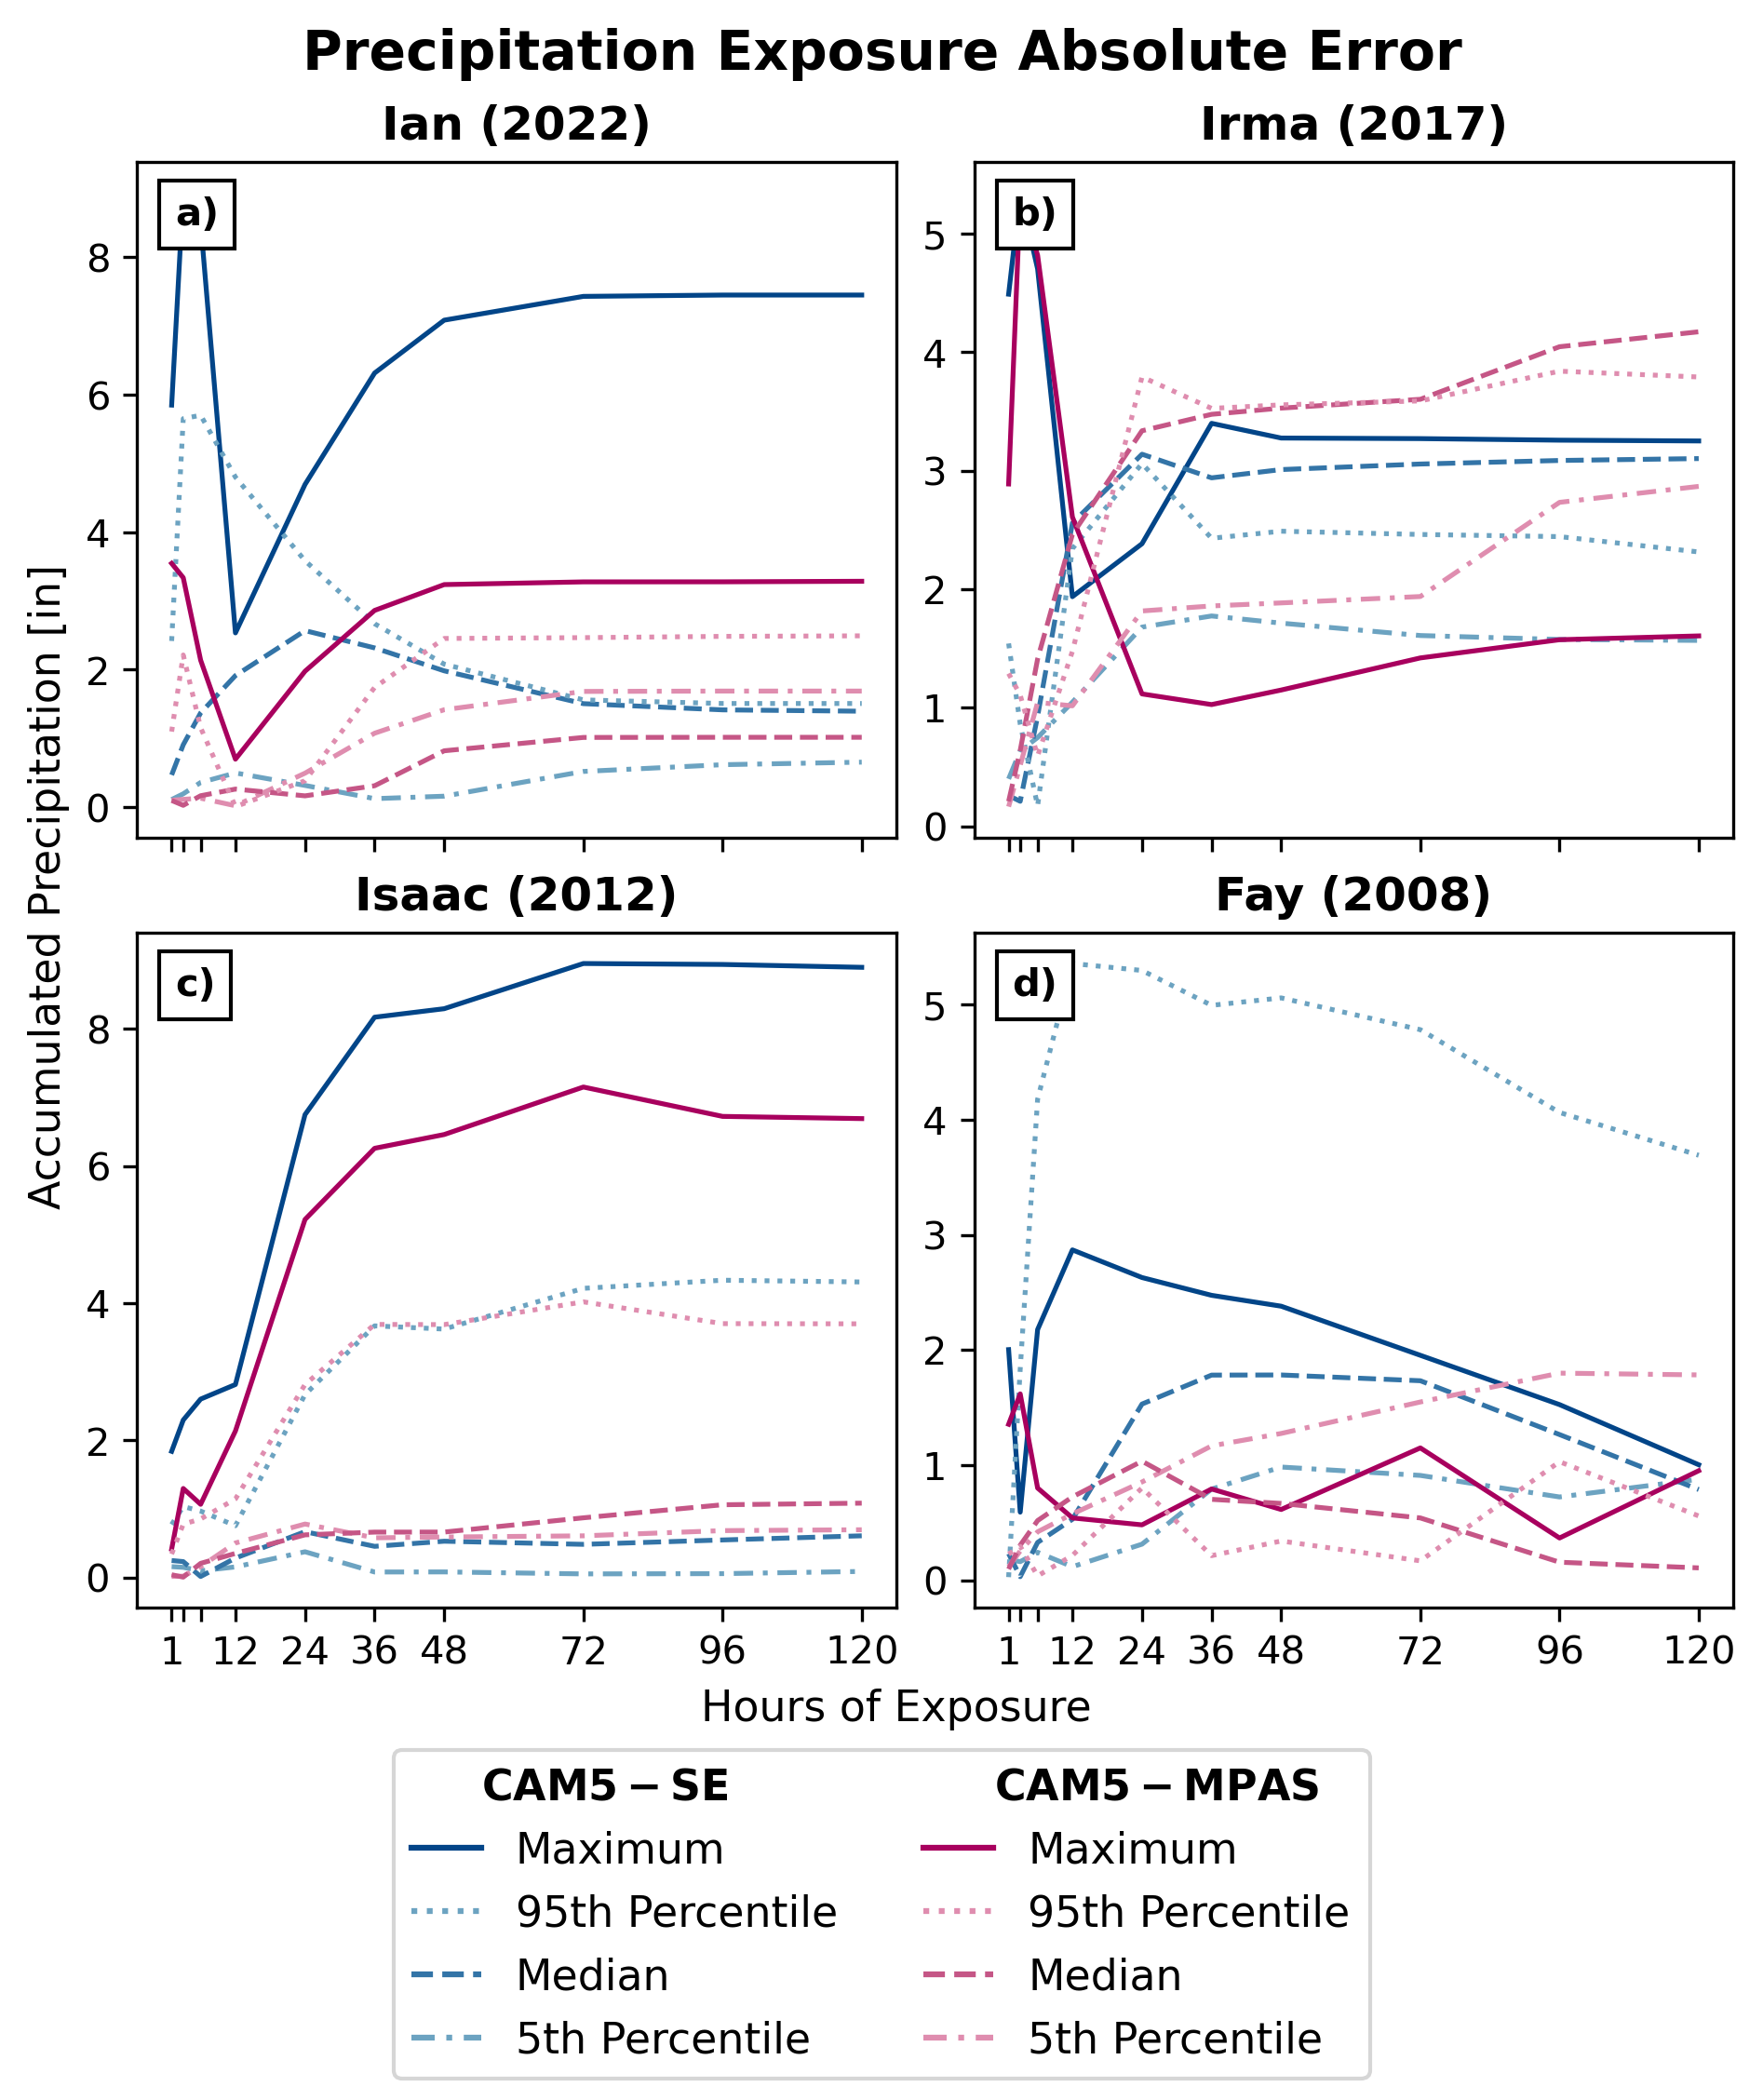

In [64]:
font_kw = {'labels':10, 'titles':12, 'ticks':9, 'legend':10}
plot_kw = {'lw':1.0, 'ylabel':'Accumulated Precipitation [in]', 
           'xlabel':'Hours of Exposure', 'figtitle':'Precipitation Exposure Absolute Error'}
fig_kw = {'ncols': 2, 'nrows': 2, 'figsize': (6.2, 7.44), 'dpi':300, 'layout':'constrained', 'sharex':True}
cam_colors = ['#024588', '#6ca3c1', '#3374a7', '#6ca3c1']
#mpas_colors = ['#bd0086', '#e892c4', '#d45ca5', '#e892c4']
mpas_colors = ['#a8005e', '#df8daf', '#c55686', '#df8daf']
#nexrad_colors = ['#377E22', '#aed09f', '#74a761', '#aed09f']

output = 'paper'

plot_kw = {'lw':1.25, 'ylabel':'Accumulated Precipitation [in]', 
           'xlabel':'Hours of Exposure', 'figtitle':'Precipitation Exposure Absolute Error'}

if output == 'paper':
    font_kw = {'labels':11, 'titles':12, 'ticks':10, 'legend':11, 'figtitle':14}
elif output == 'presentation':
    font_kw = {'labels':14, 'titles':14, 'ticks':13, 'legend':13, 'figtitle':20}
    plot_kw['lw'] = 1.5

storm_yrs = [2022, 2017, 2012, 2008]

labs = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)']
labs = labs[:len(storm_name)]
labs_dict = dict(facecolor='white', edgecolor='k')

# Fishes out number of storms and number of ds based on max_arrs dims
nstorms = max_arrs.shape[0]
nds = max_arrs.shape[1]

# Packs nexrad max_arrs and percs_arrs into lists
max_arrs_nexrad = [ian_max_arr, irma_max_arr, isaac_max_arr, fay_max_arr]
percs_5_arrs_nexrad = [ian_percs[0].flatten(), irma_percs[0].flatten(), 
                       isaac_percs[0].flatten(), fay_percs[0].flatten()]
percs_med_arrs_nexrad = [ian_percs[1].flatten(), irma_percs[1].flatten(), 
                       isaac_percs[1].flatten(), fay_percs[1].flatten()]
percs_95_arrs_nexrad = [ian_percs[2].flatten(), irma_percs[2].flatten(), 
                       isaac_percs[2].flatten(), fay_percs[2].flatten()]

# Plots output
fig, axs = plt.subplots(**fig_kw)

for i, ax in enumerate(axs.ravel()):
    
    x_axis = rolling_windows
    
    lcolor = [cam_colors, mpas_colors]
    try:
        if nds == 2:
            for j in range(nds):
                max_err = np.abs(max_arrs[i][j].flatten()-max_arrs_nexrad[i])
                p5_err = np.abs(p5[i][j].flatten()-percs_5_arrs_nexrad[i])
                median_err = np.abs(medians[i][j].flatten()-percs_med_arrs_nexrad[i])
                p95_err = np.abs(p95[i][j].flatten()-percs_95_arrs_nexrad[i])
                
                ax.plot(x_axis, max_err, label='Maximum Error', c=lcolor[j][0], lw=plot_kw['lw'])
                ax.plot(x_axis, p5_err, label='5th Percentile Error', ls=(0, (4, 2, 1, 2)), c=lcolor[j][1], lw=plot_kw['lw'])
                ax.plot(x_axis, median_err, label='Median Error', ls='--', c=lcolor[j][2], lw=plot_kw['lw'])
                ax.plot(x_axis, p95_err, label='95th Percentile Error', ls=':', c=lcolor[j][3], lw=plot_kw['lw'])

        ax.set_title(f'{storm_name[i]} ({storm_yrs[i]})', fontsize=font_kw['titles'], fontweight='heavy')

        #ax.tick_params(axis='both', labelsize=font_kw['ticks'])
        
        if output == 'paper':
            # if i in [0, 2]:
            #     ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'])
            # if i in [2, 3]:
            #     ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'])
            if i == 2:
                ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'], y=1.07)
                ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'], x=1.0)
            xlabs = [1, '', '', 12, 24, 36, 48, 72, 96, 120]
            ax.set_xticks(x_axis, xlabs)
            #ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

        elif output == 'presentation':
            if i == 2:
                ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'], y=1.07)
                ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'], x=1.07)
            xlabs = [1, '', '', '', 24, '', 48, 72, 96, 120]

            ax.set_xticks(x_axis, xlabs)
        #ax.set_xticklabels(xlabs, rotation = 30, ha="center")
        ax.tick_params(axis='both', labelsize=font_kw['ticks'])

        # Adds labels
        ax.text(0.05, 0.95, labs[i], verticalalignment='top', transform=ax.transAxes, fontsize=10, fontweight='bold', bbox=labs_dict, zorder=100)


#         if i in [0, 1, 2, 3]:
#             if len(x_axis) == 10:
#                 xlabs = [1, '', '', 12, 24, 36, 48, 72, 96, 120]
#             elif len(x_axis) == 9:
#                 xlabs = [3, '', 12, 24, 36, 48, 72, 96, 120]
#             ax.set_xticks(x_axis, xlabs)

#         if i in [2, 3]:
#             ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'])

#         if i in [0, 2]:
#             ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'])
    except:
        continue

                
if output == 'paper':
    figtitle_x = 0.5
elif output == 'presentation':
    figtitle_x = 0.4
    
fig.suptitle(plot_kw['figtitle'], fontsize=font_kw['figtitle'], fontweight='bold')
#fig.suptitle(plot_kw['figtitle'], fontsize=font_kw['titles']+4, fontweight='bold')
        
llabels = [r'$\bf{CAM5-SE}$', 'Maximum', '95th Percentile', 'Median', '5th Percentile', 
           r'$\bf{CAM5-MPAS}$', 'Maximum', '95th Percentile', 'Median', '5th Percentile']
lcolors = ['none', *cam_colors, 'none', *mpas_colors, 'none', *nexrad_colors]
lstyles = ['none', '-', ':', '--', (0, (4, 2, 1, 2)), 'none', '-', ':', '--', (0, (4, 2, 1, 2))]
style_dict = {'xdata': [], 'ydata': [], 'lw': 1.5}
handles = [mlines.Line2D(label=l, color=c, ls=ls, **style_dict) for (l, c, ls) in 
           zip(llabels, lcolors, lstyles)]
leg = fig.legend(handles=handles, fontsize=font_kw['legend'], loc='outside lower center', 
          ncols=2, handlelength=1.65)

for i, (item, label) in enumerate(zip(leg.legend_handles, leg.get_texts())):
    if label._text in [llabels[0], llabels[5]]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha('left')
        label.set_position((-2*width, 0))

plt.show()
plt.close()

## Histograms

In [12]:
from scipy.stats import gaussian_kde, skew
from sklearn.neighbors import KernelDensity

class Statistics():

    def calc_gauss(self, arr, eval_pts, method='scipy', **kwargs):
        """
        Function to manually calculate Gaussian PDF
        for plotting histograms with MPL. Default 
        method is 'scipy', which is what seaborn uses.
        
        Parameters
        -----------------
        data     :: np.ndarray, 1-D array of values
        eval_pts :: np.ndarray, 1-D array of values 
        method   :: str (opt), default='scipy', method
                        of calculating gaussians.
                        Options are 'scipy' or 'sklearn'.
                        
        Optional kwargs
        ------------------
        kde_kw   :: kwargs to pass to scipy.gaussian_kde or
                        sklearn.neighbors.KernelDensity
        """
        
        # Converts to array
        if isinstance(arr, list):
            arr = np.array(arr)

        # Retrieves KDE calculation kwargs
        kde_kw = kwargs.get('kde_kw', {})

        if method == 'scipy':
            # Calculates KDE
            kde = gaussian_kde(arr, **kde_kw)
            
            # Fits KDE to Gaussian PDF
            gauss = kde.pdf(eval_pts)

        elif method == 'sklearn':
            # Unpacks kwargs
            kde_kw = {'bandwidth':1, 'kernel':'gaussian', **kde_kw}
            
            # Calculates KDE
            kde = KernelDensity(**kde_kw).fit(arr.reshape([-1, 1]))
            
            # Fits KDE to Gaussian PDF
            gauss = np.exp(kde.score_samples(eval_pts.reshape([-1, 1])))
            
        else:
            raise ValueError("`method` not in acceptable values: 'scipy', 'sklearn'.")

        return gauss
    
    def fit_gauss(self, x):
        # x = np.sort(x)
        # k, loc, scale = scipy.stats.exponnorm.fit(np.sort(x))
        # gauss_pdf = scipy.stats.exponnorm.pdf(np.sort(x), k, loc, scale)
        gauss_pdf = scipy.stats.gaussian_kde(x).pdf(np.sort(x))

        return gauss_pdf

    def get_hist_metrics(self, ds, variable, bbox):

        subset_idx = get_subset_idx(ds, bbox)
        subset_ds = ds.isel(ncol=subset_idx)
        arr = subset_ds[variable].values.flatten()
        bins = np.histogram_bin_edges(arr, bins='auto')
        gauss = self.fit_gauss(np.sort(arr))

        return arr, bins, gauss

    def nexrad_hist_metrics(self, ds, variable, bbox):

        # Converts longitude to [0, 360]
        ds['lon'] = np.mod(ds['lon'] + 180, 360) + 180
        subset_ds = spatial_subset(ds, bbox, False)
        arr = subset_ds['rain_hourly'].values
        arr = arr[:, ~np.isnan(arr).all(axis=0)]

        if variable == 'PRECT_TOT':
            arr = np.nansum(arr, axis=0)
        elif variable == 'PRECT_MAX':
            arr = np.nanmax(arr, axis=0)

        bins = np.histogram_bin_edges(arr, bins='auto')
        gauss = self.fit_gauss(np.sort(arr))

        return arr, bins, gauss

In [13]:
def fit_gauss(x):
    # x = np.sort(x)
    # k, loc, scale = scipy.stats.exponnorm.fit(np.sort(x))
    # gauss_pdf = scipy.stats.exponnorm.pdf(np.sort(x), k, loc, scale)
    gauss_pdf = scipy.stats.gaussian_kde(x).pdf(np.sort(x))
    
    return gauss_pdf

def get_hist_metrics(ds, variable, bbox):
    
    subset_idx = get_subset_idx(ds, bbox)
    subset_ds = ds.isel(ncol=subset_idx)
    arr = subset_ds[variable].values.flatten()
    bins = np.histogram_bin_edges(arr, bins='auto')
    gauss = fit_gauss(np.sort(arr))
    
    return arr, bins, gauss

def nexrad_hist_metrics(ds, variable, bbox):
    
    # Converts longitude to [0, 360]
    ds['lon'] = np.mod(ds['lon'] + 180, 360) + 180
    subset_ds = spatial_subset(ds, bbox, False)
    arr = subset_ds['rain_hourly'].values
    arr = arr[:, ~np.isnan(arr).all(axis=0)]
    
    if variable == 'PRECT_TOT':
        arr = np.nansum(arr, axis=0)
    elif variable == 'PRECT_MAX':
        arr = np.nanmax(arr, axis=0)
    
    bins = np.histogram_bin_edges(arr, bins='auto')
    gauss = fit_gauss(np.sort(arr))
    
    return arr, bins, gauss

def yule_kendall(q_025, q_050, q_075):
    """
    Function to compute Yule-Kendall Index. 
    
    Parameters:
    -------------
    q_025 :: float, 25th quantile value
    q_050 :: float, median quantile value
    q_075 :: float, 75th quantile value
    iqr   :: float, inter-quantile value
    """
    iqr = q_075 - q_025
    yki = ((q_075 - q_050) - (q_050 - q_025))/iqr
    
    return yki

def skew_metrics(arr, var):
    skewness = skew(arr)
    
    df = pd.DataFrame({f'{var}':arr})
    metrics_df = df.describe()
    
    # Calculates the IQR from the 75th and 25th quartiles
    metrics_df.loc['IQR'] = metrics_df.loc['75%'] - metrics_df.loc['25%']
    
    yki = yule_kendall(metrics_df.loc['25%'], metrics_df.loc['50%'], metrics_df.loc['75%'])
    
    skew_df = pd.DataFrame({'skewness':skewness, 'yki':yki})
    
    return skewness, yki.values[0]

In [66]:
%%time
ds_arr=['h4pn_ds', 'h4cn_ds']
storm_name = ['Ian', 'Irma', 'Isaac', 'Fay']
variable = 'PRECT_TOT'
bboxes = [ian_bbox, irma_bbox, isaac_bbox, fay_bbox]

# Packs target datasets into list
storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_name))
cam_ds_list = [x[0] for x in storm_list]
mpas_ds_list = [x[1] for x in storm_list]

cam_arr, cam_bins, cam_gauss = zip(*map(get_hist_metrics, cam_ds_list, [variable]*len(cam_ds_list), bboxes))
mpas_arr, mpas_bins, mpas_gauss = zip(*map(get_hist_metrics, mpas_ds_list, [variable]*len(mpas_ds_list), bboxes))

nexrad_ds_list = [ian_ds, irma_ds, isaac_ds, fay_ds]
nexrad_arr, nexrad_bins, nexrad_gauss = zip(*map(nexrad_hist_metrics, nexrad_ds_list, [variable]*len(nexrad_ds_list), bboxes))

CPU times: user 29.4 s, sys: 5.28 s, total: 34.7 s
Wall time: 35.6 s


In [67]:
cam_skew = [skew_metrics(x, variable)[0] for x in cam_arr]
cam_yki = [skew_metrics(x, variable)[1] for x in cam_arr]

mpas_skew = [skew_metrics(x, variable)[0] for x in mpas_arr]
mpas_yki = [skew_metrics(x, variable)[1] for x in mpas_arr]

nexrad_skew = [skew_metrics(x, variable)[0] for x in nexrad_arr]
nexrad_yki = [skew_metrics(x, variable)[1] for x in nexrad_arr]

In [68]:
skew_df = pd.DataFrame({'cam_skew':cam_skew, 'cam_yki':cam_yki, 'mpas_skew':mpas_skew, 
                        'mpas_yki':mpas_yki, 'nexrad_skew':nexrad_skew, 'nexrad_yki':nexrad_yki}, index=['Ian', 'Irma', 'Isaac', 'Fay'])

In [69]:
print('Total Precipitation')
skew_df

Total Precipitation


cam_skew   cam_yki  mpas_skew  mpas_yki  nexrad_skew  nexrad_yki
Ian    2.354759  0.479770   0.908950  0.611962     1.349272    0.142614
Irma  -0.478135 -0.405587  -0.633298  0.053392     0.863160    0.185185
Isaac -0.886686  0.005526  -0.304701 -0.025671     1.540807    0.409449
Fay    0.412004  0.231001  -0.189469  0.036536     0.478016    0.142857

In [70]:
%%time
ds_arr=['h4pn_ds', 'h4cn_ds']
storm_name = ['Ian', 'Irma', 'Isaac', 'Fay']
variable = 'PRECT_MAX'
bboxes = [ian_bbox, irma_bbox, isaac_bbox, fay_bbox]

# Packs target datasets into list
storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_name))
cam_ds_list = [x[0] for x in storm_list]
mpas_ds_list = [x[1] for x in storm_list]

cam_arr, cam_bins, cam_gauss = zip(*map(get_hist_metrics, cam_ds_list, [variable]*len(cam_ds_list), bboxes))
mpas_arr, mpas_bins, mpas_gauss = zip(*map(get_hist_metrics, mpas_ds_list, [variable]*len(mpas_ds_list), bboxes))

nexrad_ds_list = [ian_ds, irma_ds, isaac_ds, fay_ds]
nexrad_arr, nexrad_bins, nexrad_gauss = zip(*map(nexrad_hist_metrics, nexrad_ds_list, [variable]*len(nexrad_ds_list), bboxes))

cam_skew = [skew_metrics(x, variable)[0] for x in cam_arr]
cam_yki = [skew_metrics(x, variable)[1] for x in cam_arr]

mpas_skew = [skew_metrics(x, variable)[0] for x in mpas_arr]
mpas_yki = [skew_metrics(x, variable)[1] for x in mpas_arr]

nexrad_skew = [skew_metrics(x, variable)[0] for x in nexrad_arr]
nexrad_yki = [skew_metrics(x, variable)[1] for x in nexrad_arr]

skew_df = pd.DataFrame({'cam_skew':cam_skew, 'cam_yki':cam_yki, 'mpas_skew':mpas_skew, 
                        'mpas_yki':mpas_yki, 'nexrad_skew':nexrad_skew, 'nexrad_yki':nexrad_yki}, index=['Ian', 'Irma', 'Isaac', 'Fay'])

CPU times: user 26.9 s, sys: 4.75 s, total: 31.6 s
Wall time: 28.9 s


In [71]:
print('Maximum Hourly Precipitation')
skew_df

Maximum Hourly Precipitation


cam_skew   cam_yki  mpas_skew  mpas_yki  nexrad_skew  nexrad_yki
Ian    1.372177  0.684431   1.269511  0.350976     1.883430    0.506673
Irma   0.109784  0.202258   0.379189 -0.001322     2.552448    0.169231
Isaac -0.086355  0.430080   1.186830  0.109037     1.362482    0.359268
Fay    0.614135  0.507370   0.333591  0.052832     1.502231    0.200000

In [82]:
ds_arr=['h4pn_ds', 'h4cn_ds']
storm_name = ['storm_0236']
bboxes = [storm_0236_bbox]
variable = ['PRECT_TOT', 'PRECT_MAX']

cam_ds = all_storms['storm_0236']['h4pn_ds']
mpas_ds = all_storms['storm_0236']['h4cn_ds']

# if variable == 'PRECT_TOT':
#     plot_kw['figtitle'] = 'Total Precipitation'
# elif variable == 'PRECT_MAX':
#     plot_kw['figtitle'] = 'Maximum Hourly Precipitation'
    

storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_names))
cam_ds_list = [x[0] for x in storm_list]
mpas_ds_list = [x[1] for x in storm_list]

cam_arr_t, cam_bins_t, cam_gauss_t = get_hist_metrics(cam_ds, 'PRECT_TOT', storm_0236_bbox)
cam_arr_m, cam_bins_m, cam_gauss_m = get_hist_metrics(cam_ds, 'PRECT_MAX', storm_0236_bbox)

mpas_arr_t, mpas_bins_t, mpas_gauss_t = get_hist_metrics(mpas_ds, 'PRECT_TOT', storm_0236_bbox)
mpas_arr_m, mpas_bins_m, mpas_gauss_m = get_hist_metrics(mpas_ds, 'PRECT_MAX', storm_0236_bbox)

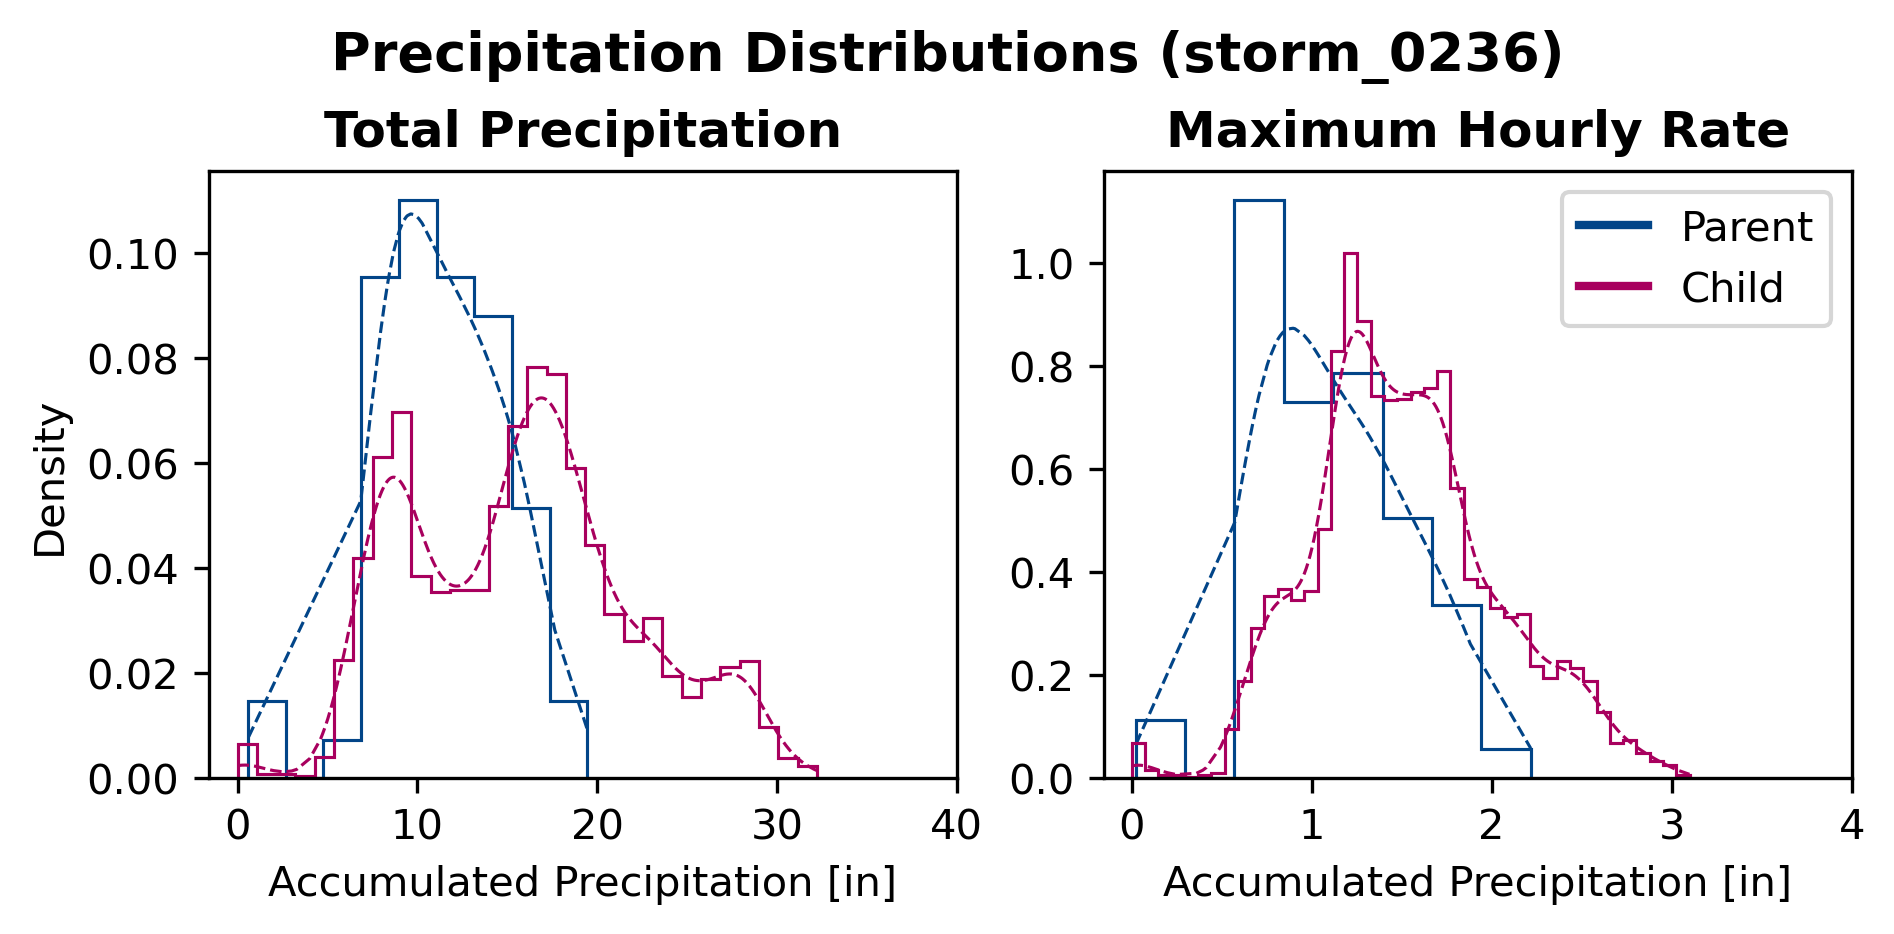

In [83]:
#font_kw = {'labels':15, 'titles':15, 'ticks':14, 'legend':18, 'figtitle':22}
plot_kw = {'lw':1.0, 'ylabel':'Density', 'xlabel':'Accumulated Precipitation [in]', 
           'figtitle':'Precipitation Distributions (storm_0236)'}
fig_kw = {'ncols': 2, 'nrows': 1, 'figsize': (6.2, 3), 'dpi':300, 'layout':'constrained'}
hist_kw = {'histtype':'step', 'density':True, 'lw':0.5}
gauss_kw = {'ls':'--', 'lw':0.5}
    
colors = ['#024588', '#a8005e']

font_kw = {'labels':10, 'titles':12, 'ticks':10, 'legend':10, 'figtitle':13}
hist_kw['lw'] = 0.75
gauss_kw['lw'] = 0.75

# Legend kw
llabels = ['Parent', 'Child']
lcolors = colors
lstyles = ['-', '-']
style_dict = {'xdata': [], 'ydata': [], 'lw': plot_kw['lw']*2}
handles = [mlines.Line2D(label=l, color=c, ls=ls, **style_dict) for (l, c, ls) in 
           zip(llabels, lcolors, lstyles)]
legend_kw = dict(handles=handles, fontsize=font_kw['legend'], loc='upper right', 
              ncols=1, handlelength=1.65)

fig, axs = plt.subplots(**fig_kw)

for i, ax in enumerate(axs.ravel()):
    if i == 0:
        ax.hist(cam_arr_t, color=colors[0], bins=cam_bins_t, **hist_kw)
        ax.plot(np.sort(cam_arr_t), cam_gauss_t, c=colors[0], **gauss_kw)

        ax.hist(mpas_arr_t, color=colors[1], bins=mpas_bins_t, **hist_kw)
        ax.plot(np.sort(mpas_arr_t), mpas_gauss_t, c=colors[1], **gauss_kw)
    elif i == 1:
        ax.hist(cam_arr_m, color=colors[0], bins=cam_bins_m, **hist_kw)
        ax.plot(np.sort(cam_arr_m), cam_gauss_m, c=colors[0], **gauss_kw)

        ax.hist(mpas_arr_m, color=colors[1], bins=mpas_bins_m, **hist_kw)
        ax.plot(np.sort(mpas_arr_m), mpas_gauss_m, c=colors[1], **gauss_kw)
    
    if i == 0:
        ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'])
        ax.xaxis.set_ticks([0, 10, 20, 30, 40], [0, 10, 20, 30, 40])

    elif i == 1:
        ax.xaxis.set_ticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4])
        ax.legend(**legend_kw)
    
    ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'])
    
    ax.set_title(['Total Precipitation', 'Maximum Hourly Rate'][i], fontsize=font_kw['titles'], fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=font_kw['ticks'])

fig.suptitle(plot_kw['figtitle'], fontsize=font_kw['figtitle'], fontweight='bold')
plt.show()
plt.close()

In [98]:
def make_histograms(storm_names, variable, ds_arr, nexrad_ds_list, bboxes, output='presentation', **kwargs):

    font_kw = {'labels':10, 'titles':12, 'ticks':9, 'legend':10, 'figtitle':16}
    plot_kw = {'lw':1.0, 'ylabel':'Density', 
               'xlabel':'Accumulated Precipitation [in]'}
    if variable == 'PRECT_TOT':
        if output == 'paper':
            plot_kw['figtitle'] = 'Total Precipitation Distribution'
        elif output == 'presentation':
            plot_kw['figtitle'] = 'Total Precipitation'
    elif variable == 'PRECT_MAX':
        if output == 'paper':
            plot_kw['figtitle'] = 'Maximum Hourly Precipitation Rate Distribution'
        elif output == 'presentation':
            plot_kw['figtitle'] = 'Maximum Hourly Precipitation Rate'
    else:
        raise ValueError("Only 'PRECT_TOT' and 'PRECT_MAX' are acceptable values for `variable`.")
        
    fig_kw = {'ncols': 2, 'nrows': 2, 'figsize': (6.2, 6.2), 'dpi':300, 'layout':'constrained'}
    hist_kw = {'histtype':'step', 'density':True, 'lw':0.5}
    gauss_kw = {'ls':'--', 'lw':0.75}

    cam_colors = ['#024588', '#6ca3c1', '#3374a7', '#6ca3c1']
    #mpas_colors = ['#bd0086', '#e892c4', '#d45ca5', '#e892c4']
    mpas_colors = ['#a8005e', '#df8daf', '#c55686', '#df8daf']
    nexrad_colors = ['#377E22', '#aed09f', '#74a761', '#aed09f']
    colors = [cam_colors[0], mpas_colors[0], nexrad_colors[0]]
    
    labs = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)']
    labs = labs[:len(storm_names)]
    labs_dict = dict(facecolor='white', edgecolor='k')
    
    # Packs target datasets into list
    storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_names))
    cam_ds_list = [x[0] for x in storm_list]
    mpas_ds_list = [x[1] for x in storm_list]
    storm_yrs = [ds.time[0].dt.year.values for ds in cam_ds_list]

    cam_arr, cam_bins, cam_gauss = zip(*map(get_hist_metrics, cam_ds_list, [variable]*len(cam_ds_list), bboxes))
    mpas_arr, mpas_bins, mpas_gauss = zip(*map(get_hist_metrics, mpas_ds_list, [variable]*len(mpas_ds_list), bboxes))
    nexrad_arr, nexrad_bins, nexrad_gauss = zip(*map(nexrad_hist_metrics, nexrad_ds_list, [variable]*len(nexrad_ds_list), bboxes))
    
    cam_skew = list(map(skew, cam_arr))
    mpas_skew = list(map(skew, mpas_arr))
    nexrad_skew = list(map(skew, nexrad_arr))
    
    cam_skew = ['%.2f' % x for x in cam_skew]
    mpas_skew = ['%.2f' % x for x in mpas_skew]
    nexrad_skew = ['%.2f' % x for x in nexrad_skew]
    
    # Legend kw
    if output == 'paper':
        llabels = ['CAM5-SE', 'CAM5-MPAS', 'NEXRAD']
    elif output == 'presentation':
        llabels = ['Parent', 'Child', 'Observed']
    lcolors = colors
    lstyles = ['-', '-', '-']
    style_dict = {'xdata': [], 'ydata': [], 'lw': plot_kw['lw']*2}
    handles = [mlines.Line2D(label=l, color=c, ls=ls, **style_dict) for (l, c, ls) in 
               zip(llabels, lcolors, lstyles)]
    legend_kw = dict(handles=handles, fontsize=font_kw['legend'], loc='outside lower center', 
                  ncols=3, handlelength=1.65)
    
    if output == 'presentation':
        legend_kw['ncols'] = 1
        legend_kw['loc'] = 'upper right'
        font_kw = {'labels':15, 'titles':15, 'ticks':14, 'legend':18, 'figtitle':22}
        # hist_kw['lw'] = 0.75
        # gauss_kw['lw'] = 1.0
    elif output == 'paper':
        font_kw = {'labels':11, 'titles':12, 'ticks':10, 'legend':11, 'figtitle':14}
        if variable == 'PRECT_MAX':
            fig_kw['figsize'] = (6, 6.2)

    fig, axs = plt.subplots(**fig_kw)
    for i, ax in enumerate(axs.ravel()):
        ax.hist(cam_arr[i], color=cam_colors[0], bins=cam_bins[i], **hist_kw)
        ax.plot(np.sort(cam_arr[i]), cam_gauss[i], c=cam_colors[0], **gauss_kw)

        ax.hist(mpas_arr[i], color=mpas_colors[0], bins=mpas_bins[i], **hist_kw)
        ax.plot(np.sort(mpas_arr[i]), mpas_gauss[i], c=mpas_colors[0], **gauss_kw)

        ax.hist(nexrad_arr[i], color=nexrad_colors[0], bins=nexrad_bins[i], **hist_kw)
        ax.plot(np.sort(nexrad_arr[i]), nexrad_gauss[i], c=nexrad_colors[0], **gauss_kw)

        if output == 'paper':
            if i in [0, 2]:
                ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'])
            if i == 2:
                ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'], x=1.0)
            if variable == 'PRECT_TOT':
                ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
                
            elif variable == 'PRECT_MAX':
                if i == 0:
                    ax.xaxis.set_ticks([0, 2, 4, 6, 8])
                elif i == 2:
                    ax.xaxis.set_ticks([0, 1, 2, 3])
                    
#             # Sets up legend (per ax)
#             llabs = [r'$\gamma$'+f' = {cam_skew[i]}',
#                      r'$\gamma$'+f' = {mpas_skew[i]}',
#                      r'$\gamma$'+f' = {nexrad_skew[i]}']

#             lcs = colors
#             lss = ['-', '-', '-']
#             ldict = {'xdata': [], 'ydata': [], 'lw': 1.5}
#             lhands = [mlines.Line2D(label=l, color=c, ls=ls, **ldict) for (l, c, ls) in 
#                zip(llabs, lcs, lss)]
#             ax.legend(handles=lhands, fontsize=font_kw['legend']-3, loc='upper right', handlelength=1.65)
        elif output == 'presentation':
            # if i == 0:
            #     ax.legend(**legend_kw)
            if i == 2:
                ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'], x=1.0)
            if i in [0, 2]:
                ax.set_ylabel(plot_kw['ylabel'], fontsize=font_kw['labels'])
                
            start, end = ax.get_xlim()

            if variable == 'PRECT_TOT':
                # Formats x-labels to stop being annoying
                if i == 0:
                    ax.xaxis.set_ticks([0, 10, 20, 30], [0, 10, 20, 30])
                elif i == 1:
                    ax.xaxis.set_ticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20])
                elif i in [2, 3]:
                    ax.xaxis.set_ticks([0, 5, 10, 15])
                if i == 2:
                    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
            elif variable == 'PRECT_MAX':
                if i == 0:
                    ax.xaxis.set_ticks([0, 2, 4, 6, 8])
                elif i == 1:
                    ax.xaxis.set_ticks([0, 2, 4, 6])
                elif i == 2:
                    ax.xaxis.set_ticks([0, 1, 2, 3])
                elif i == 3:
                    ax.xaxis.set_ticks([0, 1, 2, 3, 4])
                
        ax.set_title(f'{storm_names[i]} ({storm_yrs[i]})', fontsize=font_kw['titles'], fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=font_kw['ticks'])
        
        # Adds labels
        text_kw = dict(verticalalignment='top', transform=ax.transAxes, fontsize=10, fontweight='bold', bbox=labs_dict, zorder=100)
        if output == 'presentation':
            text_kw['fontsize'] = 14
            ax.text(0.85, 0.95, labs[i], **text_kw)
        elif output == 'paper':
            ax.text(0.05, 0.95, labs[i], **text_kw)

    if output == 'paper':
        figtitle_x = 0.55
    elif output == 'presentation':
        figtitle_x = 0.5
        
    fig.suptitle(plot_kw['figtitle'], fontsize=font_kw['figtitle'], fontweight='bold')
    
    if output == 'paper':
        leg = fig.legend(**legend_kw)

    plt.show()
    plt.close()

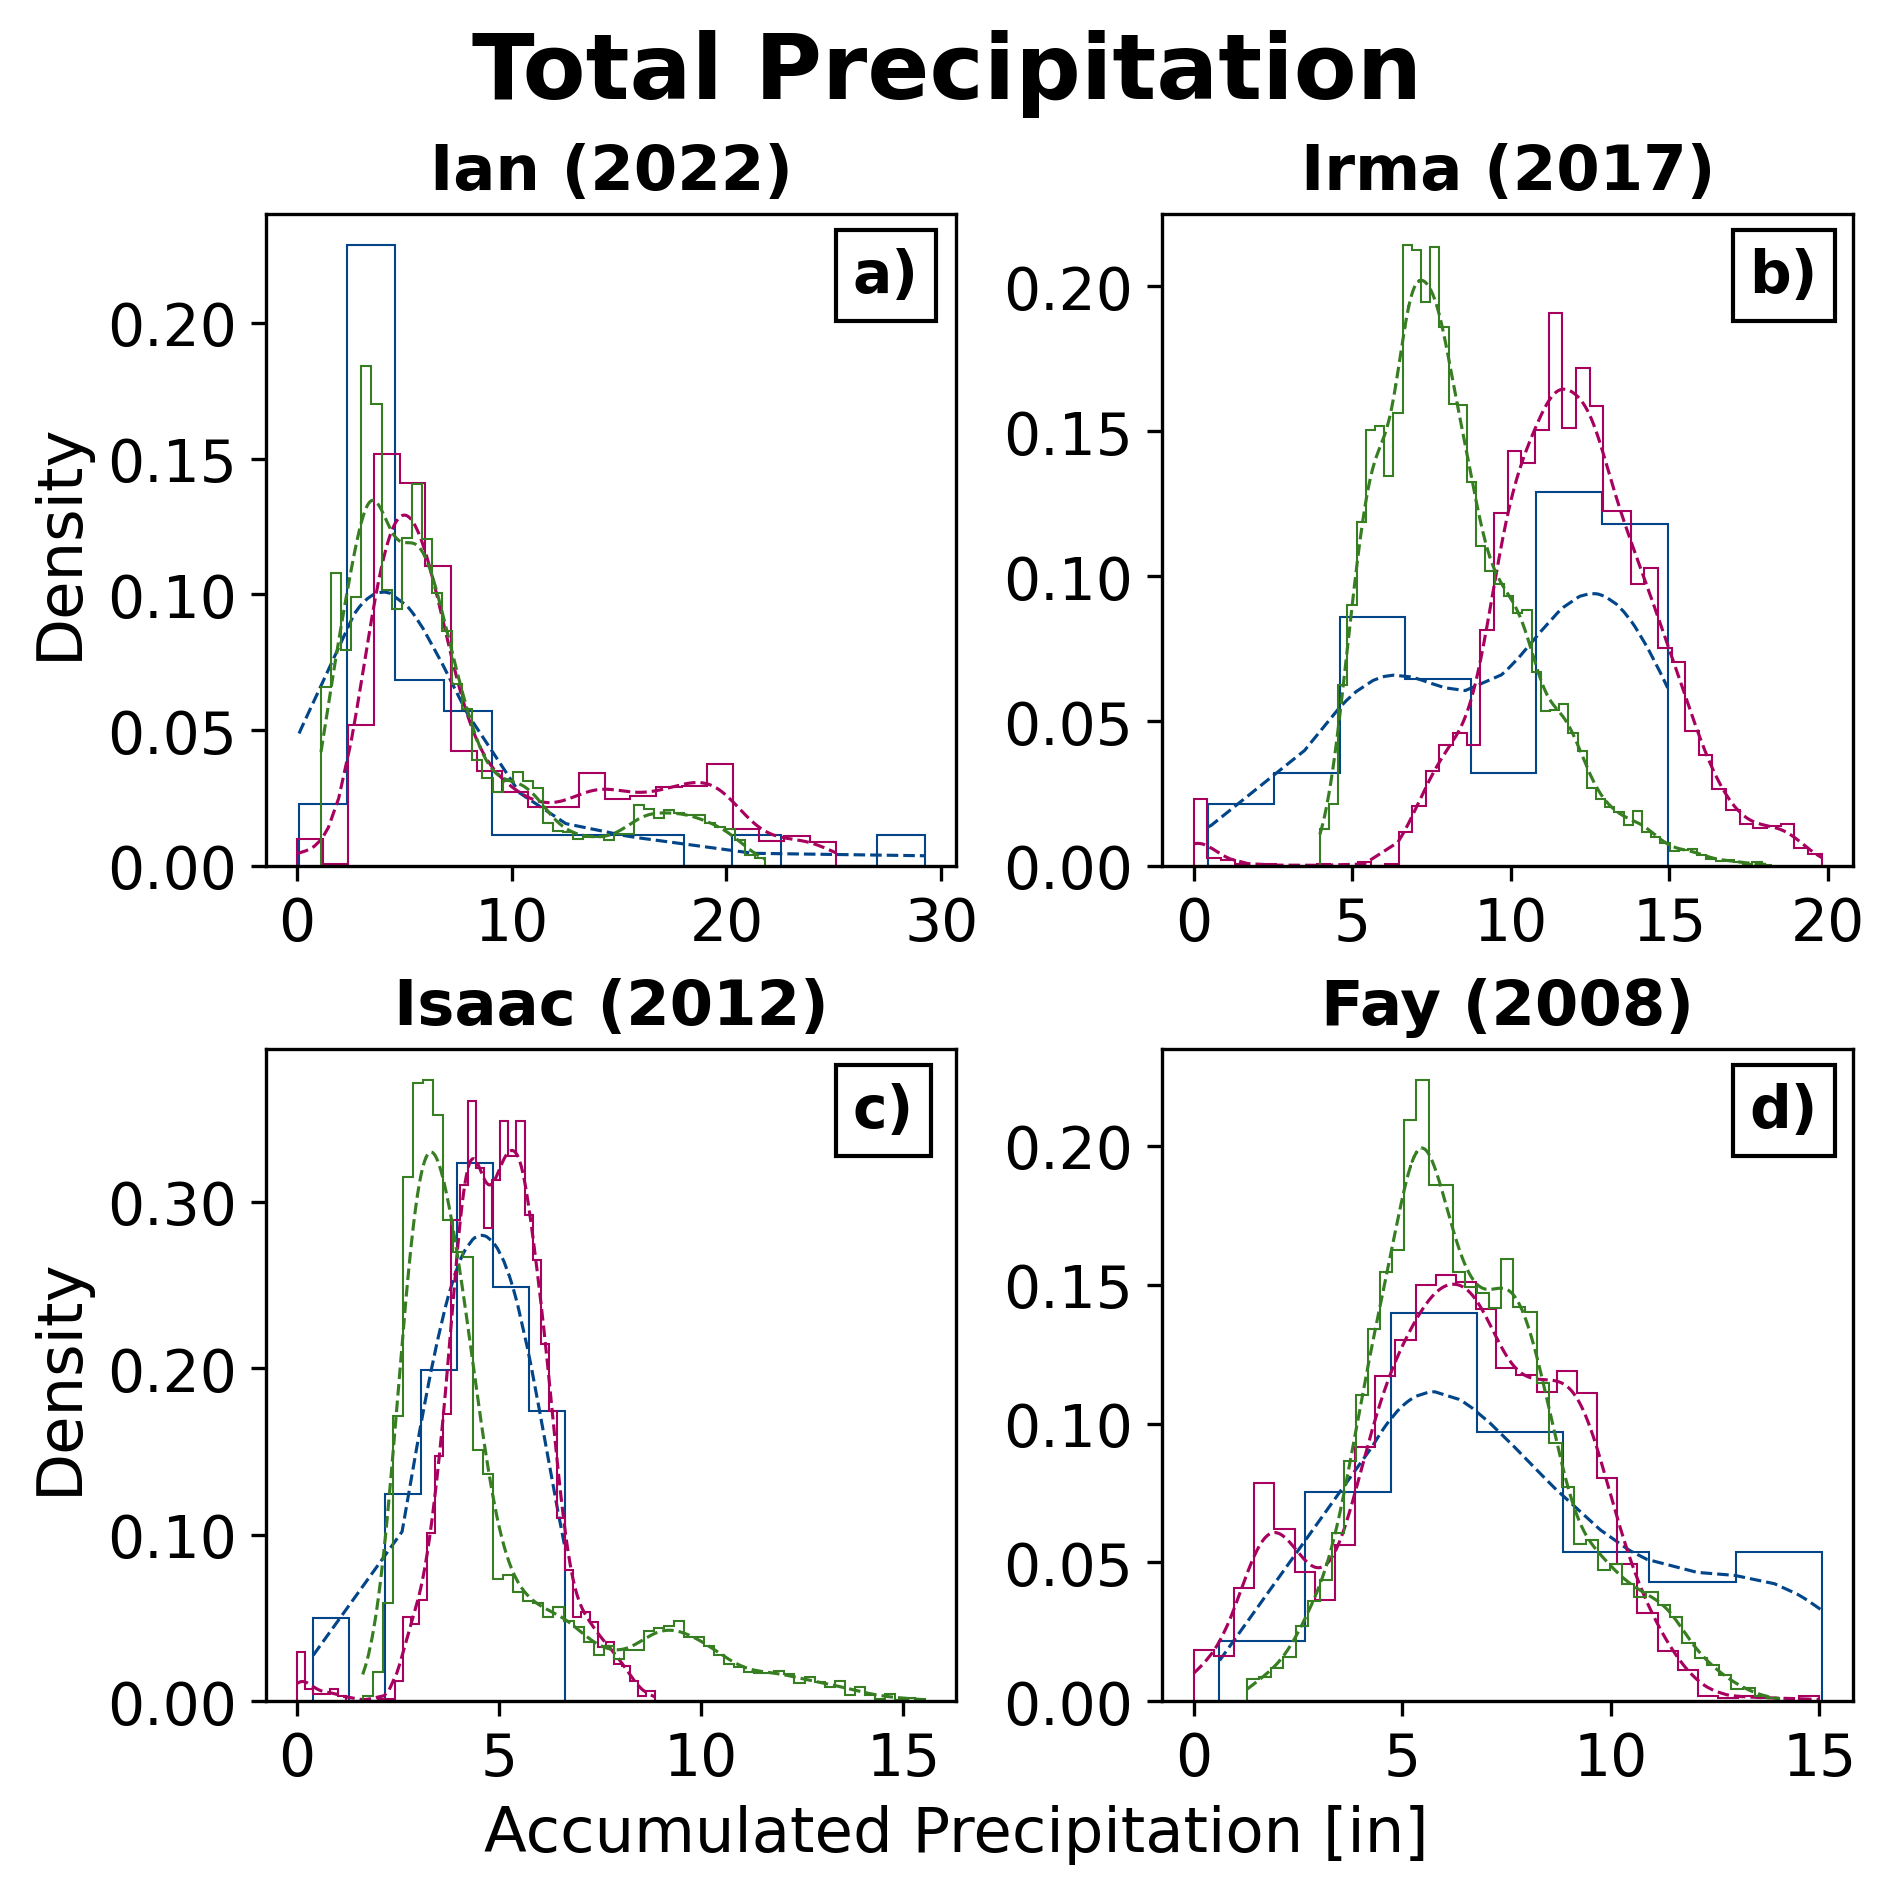

In [96]:
ds_arr=['h4pn_ds', 'h4cn_ds']
storm_names = ['Ian', 'Irma', 'Isaac', 'Fay']
variable = 'PRECT_TOT'
bboxes = [ian_bbox, irma_bbox, isaac_bbox, fay_bbox]
nexrad_ds_list = [ian_ds, irma_ds, isaac_ds, fay_ds]

make_histograms(storm_names, variable, ds_arr, nexrad_ds_list, bboxes, 'presentation')

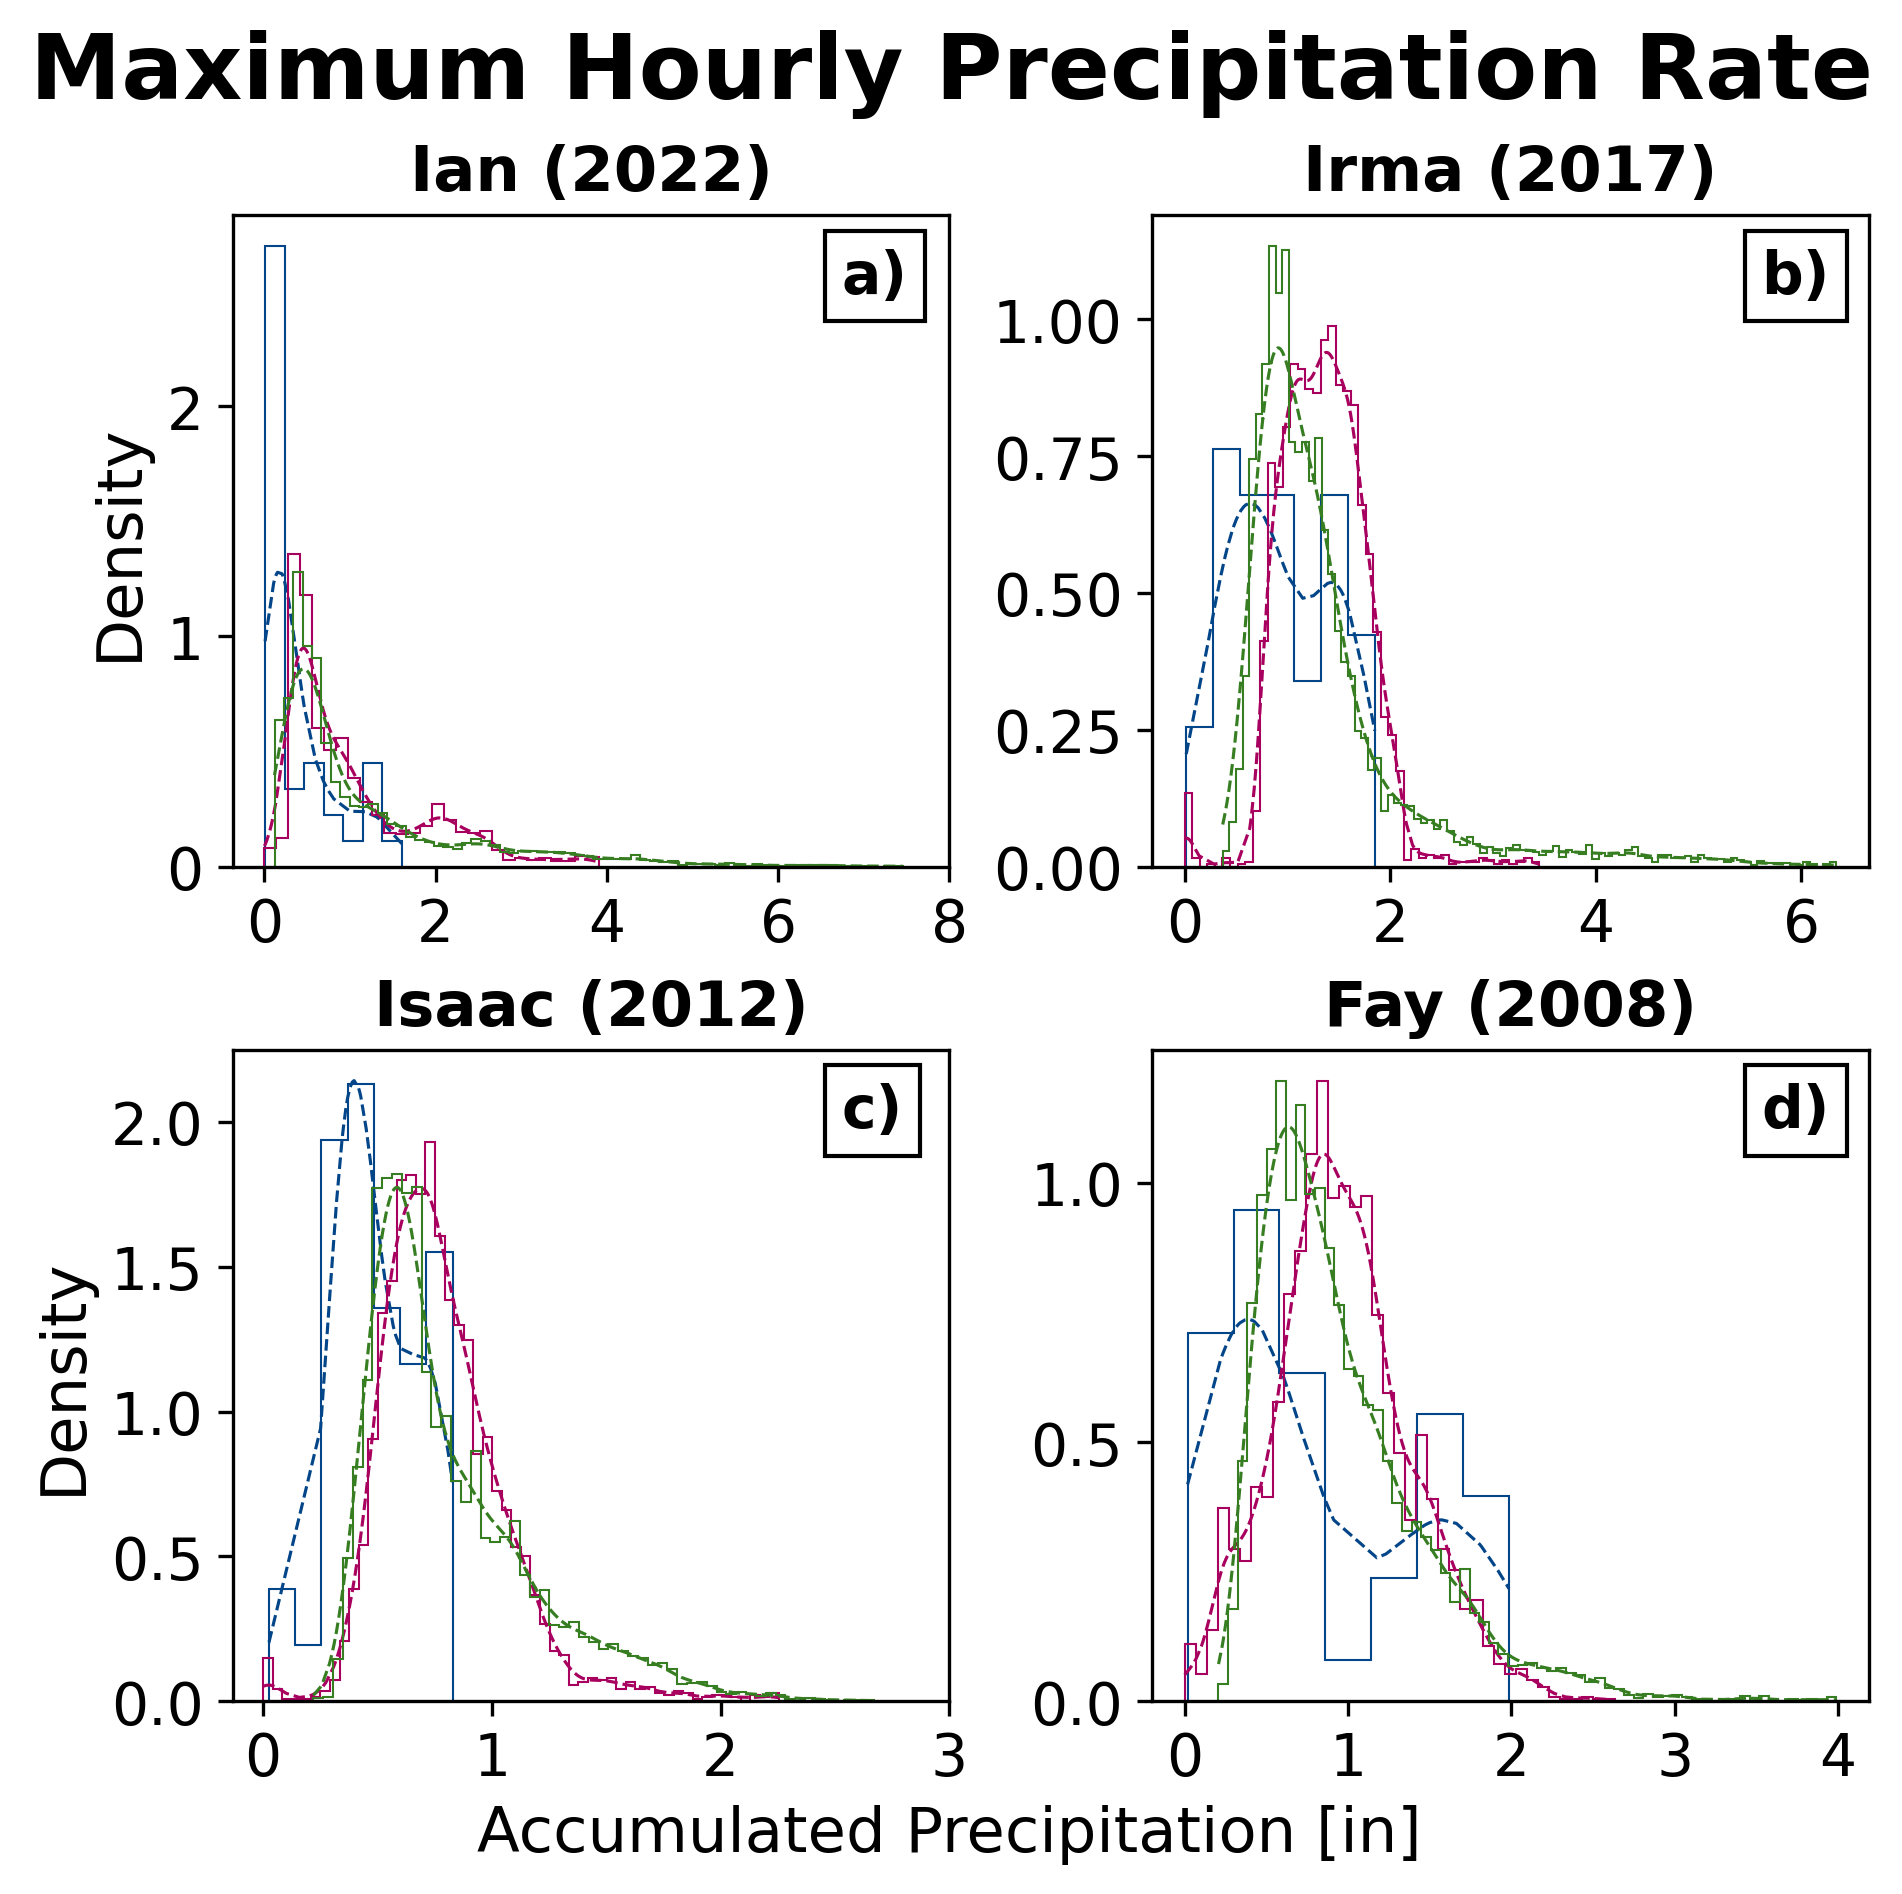

In [100]:
ds_arr=['h4pn_ds', 'h4cn_ds']
storm_names = ['Ian', 'Irma', 'Isaac', 'Fay']
variable = 'PRECT_MAX'
bboxes = [ian_bbox, irma_bbox, isaac_bbox, fay_bbox]
nexrad_ds_list = [ian_ds, irma_ds, isaac_ds, fay_ds]

make_histograms(storm_names, variable, ds_arr, nexrad_ds_list, bboxes, 'presentation')

In [128]:
def calc_cdf(x):
    x = np.sort(x)
    cdf = 1*(np.arange(x.shape[0])/(x.shape[0]-1))
    
    return cdf

def lognorm_cdf(x):
    x = np.sort(x)
    shape, loc, scale = scipy.stats.lognorm.fit(x)
    cdf = scipy.stats.lognorm.cdf(x, shape, loc, scale)
    
    return cdf

def plot_cdf(storm_names, variable, ds_arr, nexrad_ds_list, bboxes, method=2, output='presentation'):
    
    # Sets up plot
    font_kw = {'labels':11, 'titles':12, 'ticks':10, 'legend':11, 'figtitle':14}
    plot_kw = {'lw':1.0, 'xlabel':'Accumulated Precipitation [in]'}
    fig_kw = {'ncols': 2, 'nrows': 2, 'figsize': (6.2, 6.2), 'dpi':300, 'layout':'constrained', 'sharey':True}
    line_kw = {'ls':'-', 'lw':1.25}
    
    if output == 'presentation':
        font_kw = {'labels':17, 'titles':17, 'ticks':15, 'legend':15, 'figtitle':24}
        fig_kw['figsize'] = (6.5, 6.2)
        line_kw['lw'] = 1.5
    elif output == 'paper':
        fig_kw['figsize'] = (6.2, 6.8)
    
    if variable == 'PRECT_TOT':
        if output == 'paper':
            plot_kw['figtitle'] = 'Total Precipitation Cumulative Distribution'
        elif output == 'presentation':
            plot_kw['figtitle'] = 'Total Precipitation CDF'
    elif variable == 'PRECT_MAX':
        #font_kw['figtitle'] = 13
        font_kw['figtitle'] = 20
        if output == 'paper':
            plot_kw['figtitle'] = 'Maximum Hourly Precipitation Rate Cumulative Distribution'
        elif output == 'presentation':
            plot_kw['figtitle'] = 'Maximum Hourly Precipitation Rate CDF'
    else:
        raise ValueError("Only 'PRECT_TOT' and 'PRECT_MAX' are acceptable values for `variable`.")

    cam_colors = ['#024588', '#6ca3c1', '#3374a7', '#6ca3c1']
    #mpas_colors = ['#bd0086', '#e892c4', '#d45ca5', '#e892c4']
    mpas_colors = ['#a8005e', '#df8daf', '#c55686', '#df8daf']
    nexrad_colors = ['#377E22', '#aed09f', '#74a761', '#aed09f']
    colors = [cam_colors[0], mpas_colors[0], nexrad_colors[0]]
    
    labs = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)']
    labs = labs[:len(storm_names)]
    labs_dict = dict(facecolor='white', edgecolor='k')
    
    # Packs target datasets into list
    storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_names))
    cam_ds_list = [x[0] for x in storm_list]
    mpas_ds_list = [x[1] for x in storm_list]
    storm_yrs = [ds.time[0].dt.year.values for ds in cam_ds_list]

    cam_arr = [get_hist_metrics(x, variable, bboxes[i])[0] for i, x in enumerate(cam_ds_list)]
    mpas_arr = [get_hist_metrics(x, variable, bboxes[i])[0] for i, x in enumerate(mpas_ds_list)]
    nexrad_arr = [nexrad_hist_metrics(x, variable, bboxes[i])[0] for i, x in enumerate(nexrad_ds_list)]
    
    # Calculates mean and std
    cam_xbar = ['%.2f' % x.mean() for x in cam_arr]
    cam_s = ['%.2f' % x.std() for x in cam_arr]
    mpas_xbar = ['%.2f' % x.mean() for x in mpas_arr]
    mpas_s = ['%.2f' % x.std() for x in mpas_arr]
    nexrad_xbar = ['%.2f' % x.mean() for x in nexrad_arr]
    nexrad_s = ['%.2f' % x.std() for x in nexrad_arr]
    
    # Calculates cdfs
    if method == 1:
        cam_cdfs = [scipy.stats.norm(loc=x.mean(), scale=x.std()).cdf(np.sort(x)) for x in cam_arr]
        mpas_cdfs = [scipy.stats.norm(loc=x.mean(), scale=x.std()).cdf(np.sort(x)) for x in mpas_arr]
        nexrad_cdfs = [scipy.stats.norm(loc=x.mean(), scale=x.std()).cdf(np.sort(x)) for x in nexrad_arr]
    elif method == 2:
        cam_cdfs = [calc_cdf(x) for x in cam_arr]
        mpas_cdfs = [calc_cdf(x) for x in mpas_arr]
        nexrad_cdfs = [calc_cdf(x) for x in nexrad_arr]
    elif method == 3:
        cam_cdfs = [scipy.stats.norm(loc=x.mean()).cdf(np.sort(x)) for x in cam_arr]
        mpas_cdfs = [scipy.stats.norm(loc=x.mean()).cdf(np.sort(x)) for x in mpas_arr]
        nexrad_cdfs = [scipy.stats.norm(loc=x.mean()).cdf(np.sort(x)) for x in nexrad_arr]
    elif method == 4:
        cam_cdfs = [lognorm_cdf(x) for x in cam_arr]
        mpas_cdfs = [lognorm_cdf(x) for x in mpas_arr]
        nexrad_cdfs = [lognorm_cdf(x) for x in nexrad_arr]
    
    # Plots results
    fig, axs = plt.subplots(**fig_kw)
    
    for i, ax in enumerate(axs.ravel()):
        ax.plot(np.sort(cam_arr[i]), cam_cdfs[i], c=colors[0], **line_kw)
        ax.plot(np.sort(mpas_arr[i]), mpas_cdfs[i], c=colors[1], **line_kw)
        ax.plot(np.sort(nexrad_arr[i]), nexrad_cdfs[i], c=colors[2], **line_kw)
        
        if output == 'paper':
            if i == 2:
                ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'], x=1.0)
            if variable == 'PRECT_MAX':
                if i == 0:
                    ax.xaxis.set_ticks([0, 2, 4, 6, 8])
                elif i == 2:
                    ax.xaxis.set_ticks([0, 1, 2, 3])
        elif output == 'presentation':
            if i == 2:
                ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'], x=1.07)
            
            start, end = ax.get_xlim()
            if variable == 'PRECT_TOT':
                # Formats x-labels to stop being annoying
                if i == 0:
                    ax.xaxis.set_ticks([0, 10, 20, 30], [0, 10, 20, 30])
                elif i == 1:
                    ax.xaxis.set_ticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20])
                elif i in [2, 3]:
                    ax.xaxis.set_ticks([0, 5, 10, 15])
                if i == 2:
                    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
            elif variable == 'PRECT_MAX':
                if i == 0:
                    ax.xaxis.set_ticks([0, 2, 4, 6, 8])
                elif i == 1:
                    ax.xaxis.set_ticks([0, 2, 4, 6])
                elif i == 2:
                    ax.xaxis.set_ticks([0, 1, 2, 3])
                elif i == 3:
                    ax.xaxis.set_ticks([0, 1, 2, 3, 4])
        
        ax.tick_params(axis='both', which='major', labelsize=font_kw['ticks'])
        
        ax.set_title(f'{storm_names[i]} ({storm_yrs[i]})', fontsize=font_kw['titles'], fontweight='bold')
        
        # Adds labels
        text_kw = dict(verticalalignment='top', transform=ax.transAxes, fontsize=10, fontweight='bold', bbox=labs_dict, zorder=100)
        if output == 'presentation':
            text_kw['fontsize'] = 14
        ax.text(0.05, 0.95, labs[i], **text_kw)
        
#         # Sets up legend (per ax)
#         llabs = [r'$\bar{x}$'+f' = {cam_xbar[i]}, $s$ = {cam_s[i]}',
#                  r'$\bar{x}$'+f' = {mpas_xbar[i]}, $s$ = {mpas_s[i]}',
#                  r'$\bar{x}$'+f' = {nexrad_xbar[i]}, $s$ = {nexrad_s[i]}']
        
#         lcs = colors
#         lss = ['-', '-', '-']
#         ldict = {'xdata': [], 'ydata': [], 'lw': 1.5}
#         lhands = [mlines.Line2D(label=l, color=c, ls=ls, **ldict) for (l, c, ls) in 
#            zip(llabs, lcs, lss)]
#         ax.legend(handles=lhands, fontsize=font_kw['legend']-4, loc='lower right', handlelength=1.65)

        # Sets up legend (per ax)
        llabs = [r'$\bar{x}$'+f' = {cam_xbar[i]}',
                 r'$\bar{x}$'+f' = {mpas_xbar[i]}',
                 r'$\bar{x}$'+f' = {nexrad_xbar[i]}']
        
        lcs = colors
        lss = ['-', '-', '-']
        ldict = {'xdata': [], 'ydata': [], 'lw': 1.5}
        lhands = [mlines.Line2D(label=l, color=c, ls=ls, **ldict) for (l, c, ls) in 
           zip(llabs, lcs, lss)]
        if output == 'paper':
            ax.legend(handles=lhands, fontsize=font_kw['legend']-2, loc='lower right', handlelength=1.65)
        
    fig.suptitle(plot_kw['figtitle'], fontsize=font_kw['figtitle'], fontweight='bold')

    if output == 'paper':
        llabels = ['CAM5-SE', 'CAM5-MPAS', 'NEXRAD']
    elif output == 'presentation':
        llabels = ['Parent', 'Child', 'Observed']
    lcolors = colors
    lstyles = ['-', '-', '-']
    style_dict = {'xdata': [], 'ydata': [], 'lw': 2.0}
    handles = [mlines.Line2D(label=l, color=c, ls=ls, **style_dict) for (l, c, ls) in 
               zip(llabels, lcolors, lstyles)]
    leg_kw = dict(handles=handles, fontsize=font_kw['legend'], loc='outside lower center', 
              ncols=3, handlelength=1.65)
    if output == 'presentation':
        leg_kw['bbox_to_anchor'] = (0.55, -0.08)
    leg = fig.legend(**leg_kw)

    plt.show()
    plt.close()

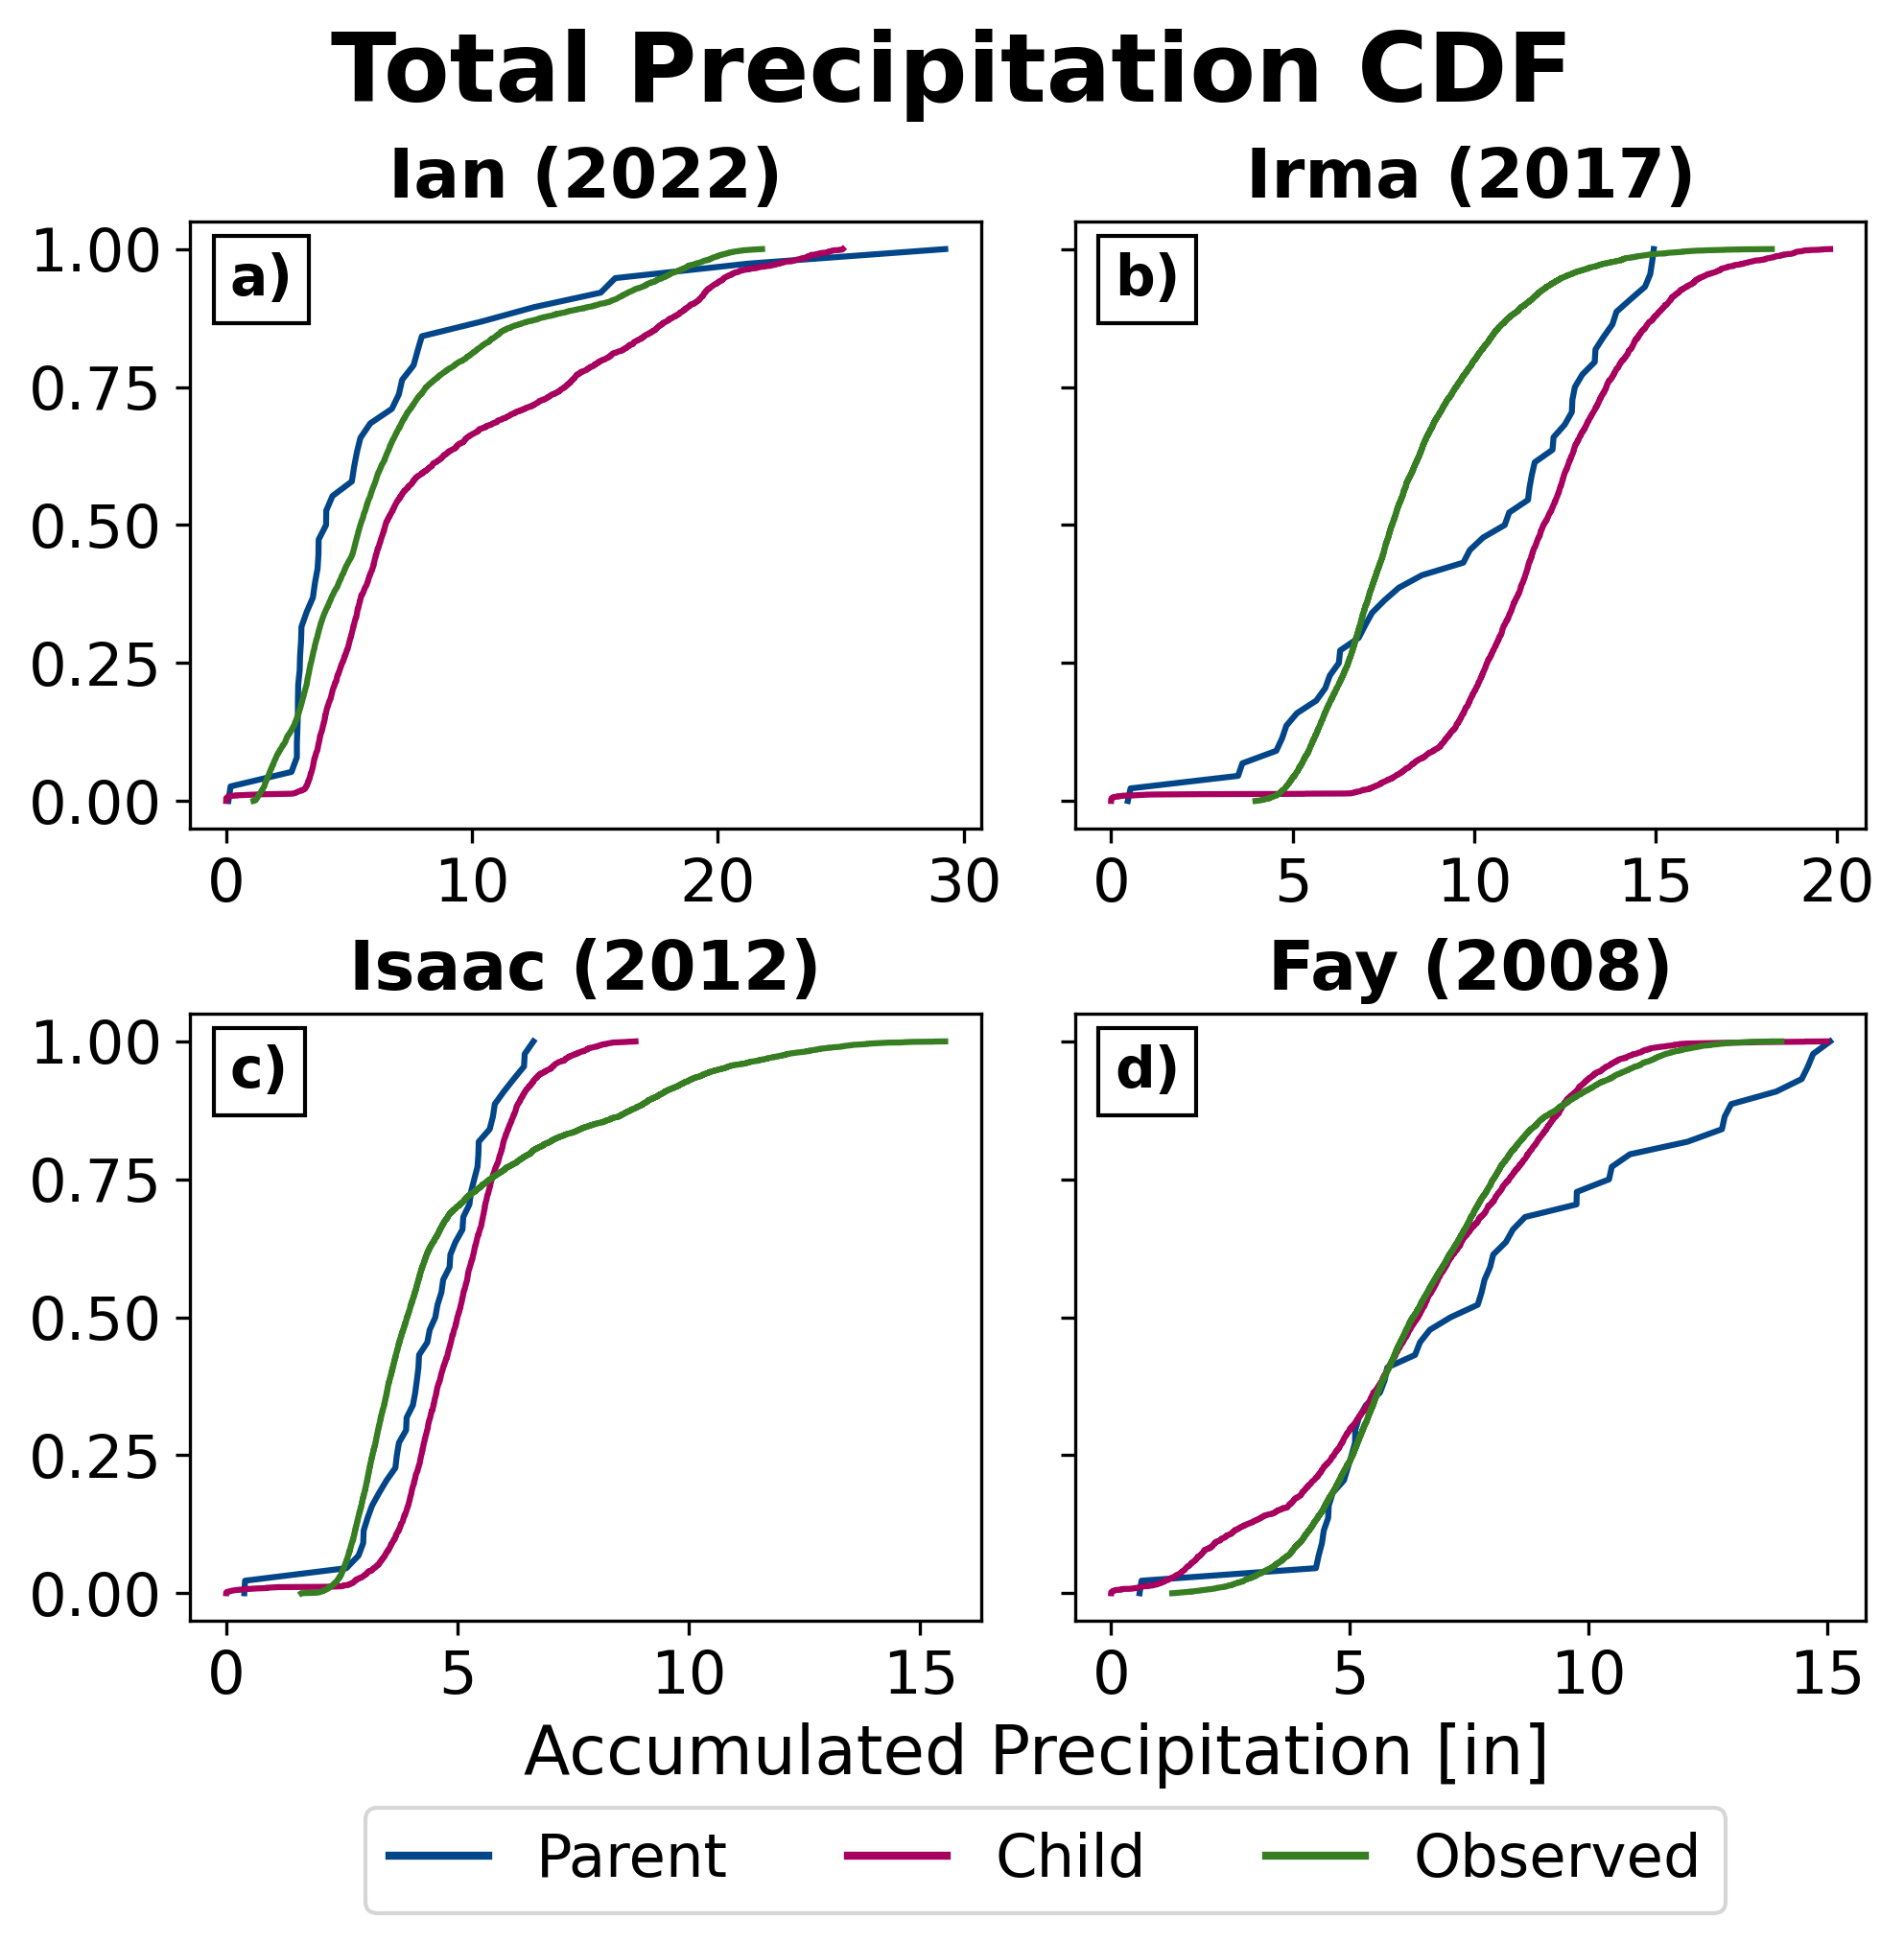

In [123]:
ds_arr=['h4pn_ds', 'h4cn_ds']
storm_names = ['Ian', 'Irma', 'Isaac', 'Fay']
variable = 'PRECT_TOT'
bboxes = [ian_bbox, irma_bbox, isaac_bbox, fay_bbox]
nexrad_ds_list = [ian_ds, irma_ds, isaac_ds, fay_ds]

plot_cdf(storm_names, variable, ds_arr, nexrad_ds_list, bboxes, output='presentation')

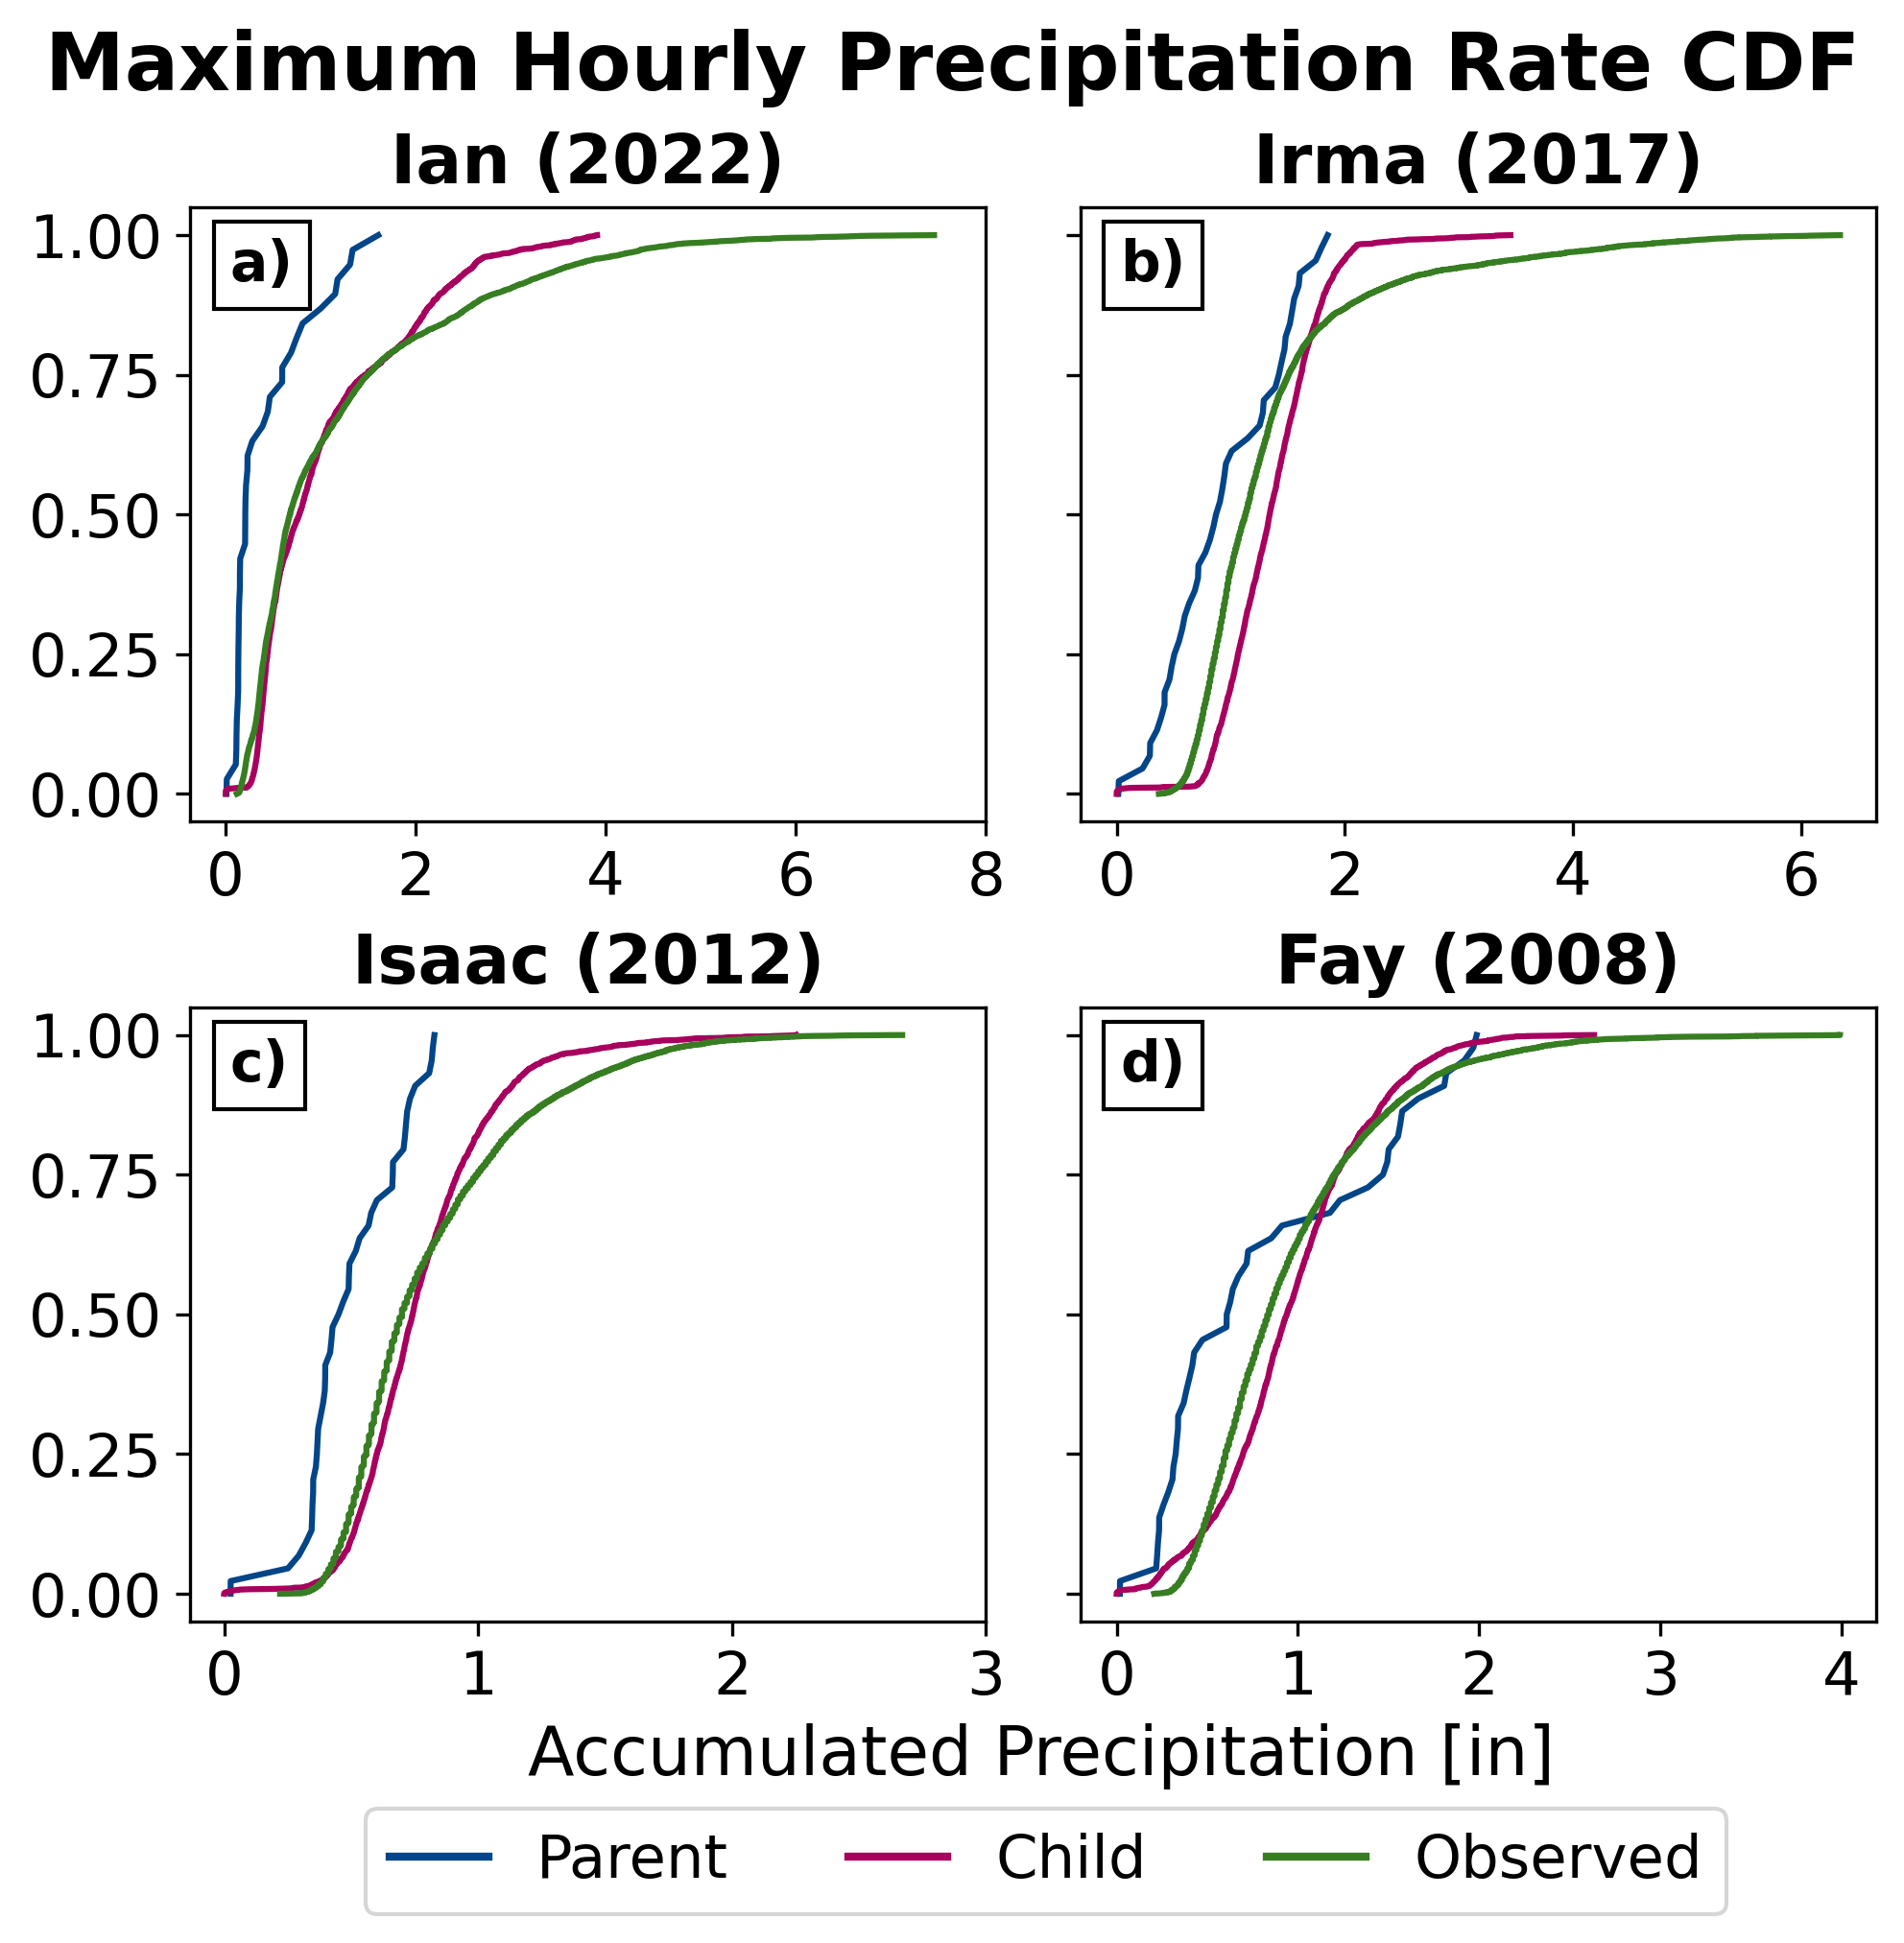

In [129]:
ds_arr=['h4pn_ds', 'h4cn_ds']
storm_names = ['Ian', 'Irma', 'Isaac', 'Fay']
variable = 'PRECT_MAX'
bboxes = [ian_bbox, irma_bbox, isaac_bbox, fay_bbox]
nexrad_ds_list = [ian_ds, irma_ds, isaac_ds, fay_ds]

plot_cdf(storm_names, variable, ds_arr, nexrad_ds_list, bboxes, output='presentation')

In [17]:
def calc_ks_rolling(data, variable, bbox, rolling_windows, overland=True):
    
    """
    Parameters
    ---------------------
    data            :: xr.Dataset
    variable        :: str, target variable from data. 
                        Only 'PRECT' or 'U10' allowed.
    bbox            :: str or dict, feed to basin_bboxes
    rolling_windows :: list of rolling windows
    percentiles     :: list (int), list of percentiles to calculate.
    """
    
    # Gets indices to subset data by based on bbox and overland params
    sub_idx = get_subset_idx(data, bbox, overland)
    
    # Subsets data by above indices
    subset = data.isel(ncol=sub_idx)
        
    # Converts units
    if variable == 'PRECT':
        units = 'in/hour'
    elif variable == 'U10':
        units = 'mph'
        rolling_windows = [int(round(x/3, 0)) for x in rolling_windows] 
    else:
        raise ValueError("Only 'PRECT' or 'U10' allowed as options.")
        
    # Creates DataFrame from array of values
    da = subset[variable].metpy.convert_units(units)
    arr = da.values
    df = pd.DataFrame(arr)

    # Creates new DataFrame for maximum sums or minimum maxima
    if variable == 'PRECT':
        metric_df = pd.DataFrame({f'sum_{i}': df.rolling(i).sum().max() for i in rolling_windows}).T
    elif variable == 'U10':
        metric_df = pd.DataFrame({f'max_{i*3}': df.rolling(i).min().max() for i in rolling_windows}).T
    
    return metric_df

ds_arr=['h4pn_ds', 'h4cn_ds']
storm_name = ['Ian', 'Irma', 'Isaac', 'Fay']
variable = 'PRECT'
rolling_windows = [1, 3, 6, 12, 24, 36, 48, 72, 96, 120]
bboxes = [ian_bbox, irma_bbox, isaac_bbox, fay_bbox]

# Packs target datasets into list
storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_name))
cam_ds_list = [x[0] for x in storm_list]
mpas_ds_list = [x[1] for x in storm_list]
nexrad_ds_list = [ian_ds, irma_ds, isaac_ds, fay_ds]

cam_df_list = list(map(calc_ks_rolling, cam_ds_list, [variable]*4, bboxes, [rolling_windows]*4))
mpas_df_list = list(map(calc_ks_rolling, mpas_ds_list, [variable]*4, bboxes, [rolling_windows]*4))

In [139]:
def nexrad_ks(ds, bbox, rolling_windows):
    
    # Converts longitude to [0, 360]
    ds['lon'] = np.mod(ds['lon'] + 180, 360) + 180
    
    # Subsets data by bbox
    subset = spatial_subset(ds, bbox)
    
    # Converts to numpy array for easier calculations
    arr = subset['rain_hourly'].values
    
    # Drops all nan grid boxes
    arr = arr[:, ~np.isnan(arr).all(axis=0)]
    
    # Creates DataFrame from array of values
    df = pd.DataFrame(arr)
    
    # Creates new DataFrame for maximum sums
    metric_df = pd.DataFrame({f'sum_{i}': df.rolling(i, min_periods=1).sum().max() for i in rolling_windows}).T
    
    return metric_df

In [107]:
%%time
nexrad_df_list = list(map(nexrad_ks, nexrad_ds_list, bboxes, [rolling_windows]*4))

CPU times: user 39.6 s, sys: 73.6 ms, total: 39.7 s
Wall time: 39.7 s


In [108]:
def get_ks_vals(sim_df, real_df):
    
    x_hourly_sums_sim = sim_df.values
    x_hourly_sums_real = real_df.values
    
    ks_results = []
    for i in range(x_hourly_sums_sim.shape[0]):
        
        # Drops nans
        sums_real = x_hourly_sums_real[i][~np.isnan(x_hourly_sums_real[i])]
        ks_stat = ks_2samp(x_hourly_sums_sim[i], sums_real).statistic
        ks_results.append(ks_stat)
        
    ks_results = np.array(ks_results)
    
    # ks_results = list(map(ks_2samp(x_hourly_sums_sim, x_hourly_sums_real)))
    # ks_results = [x.statistic for x in ks_results]
    
    return ks_results

In [109]:
x_hourly_ks_cam = np.array(list(map(get_ks_vals, cam_df_list, nexrad_df_list)))
x_hourly_ks_mpas = np.array(list(map(get_ks_vals, mpas_df_list, nexrad_df_list)))

In [131]:
#cols = ['1_hour', '3_hour', '6_hour', '12_hour', '24_hour', '36_hour', '48_hour', '72_hour', '96_hour', '120_hour']
cols = rolling_windows
ks_df_cam = pd.DataFrame(x_hourly_ks_cam, index=['Ian', 'Irma', 'Isaac', 'Fay'], columns=cols)
print('CAM Total Precip KS')
ks_df_cam

CAM Total Precip KS


1         3         6         12        24        36        48   \
Ian    0.544115  0.536550  0.516794  0.489322  0.401947  0.327127  0.259639   
Irma   0.317055  0.205464  0.262082  0.404234  0.434526  0.377240  0.381638   
Isaac  0.458312  0.264517  0.127031  0.181133  0.291161  0.212377  0.195521   
Fay    0.376043  0.252115  0.303766  0.325972  0.328895  0.312145  0.327536   

            72        96        120  
Ian    0.195582  0.191407  0.191407  
Irma   0.382248  0.383958  0.379928  
Isaac  0.196531  0.198974  0.205041  
Fay    0.319230  0.272570  0.211074

In [132]:
ks_df_mpas = pd.DataFrame(x_hourly_ks_mpas, index=['Ian', 'Irma', 'Isaac', 'Fay'], columns=cols)
print('MPAS Total Precip KS')
ks_df_mpas

MPAS Total Precip KS


1         3         6         12        24        36        48   \
Ian    0.075190  0.070549  0.164228  0.112665  0.121742  0.148493  0.158143   
Irma   0.215141  0.290993  0.427019  0.476895  0.581221  0.512133  0.519373   
Isaac  0.099070  0.136787  0.153787  0.234192  0.331779  0.319742  0.301966   
Fay    0.127411  0.193919  0.202017  0.192826  0.216045  0.147716  0.144370   

            72        96        120  
Ian    0.205502  0.205959  0.205959  
Irma   0.527111  0.608161  0.616085  
Isaac  0.327709  0.343723  0.348739  
Fay    0.122247  0.101648  0.101552

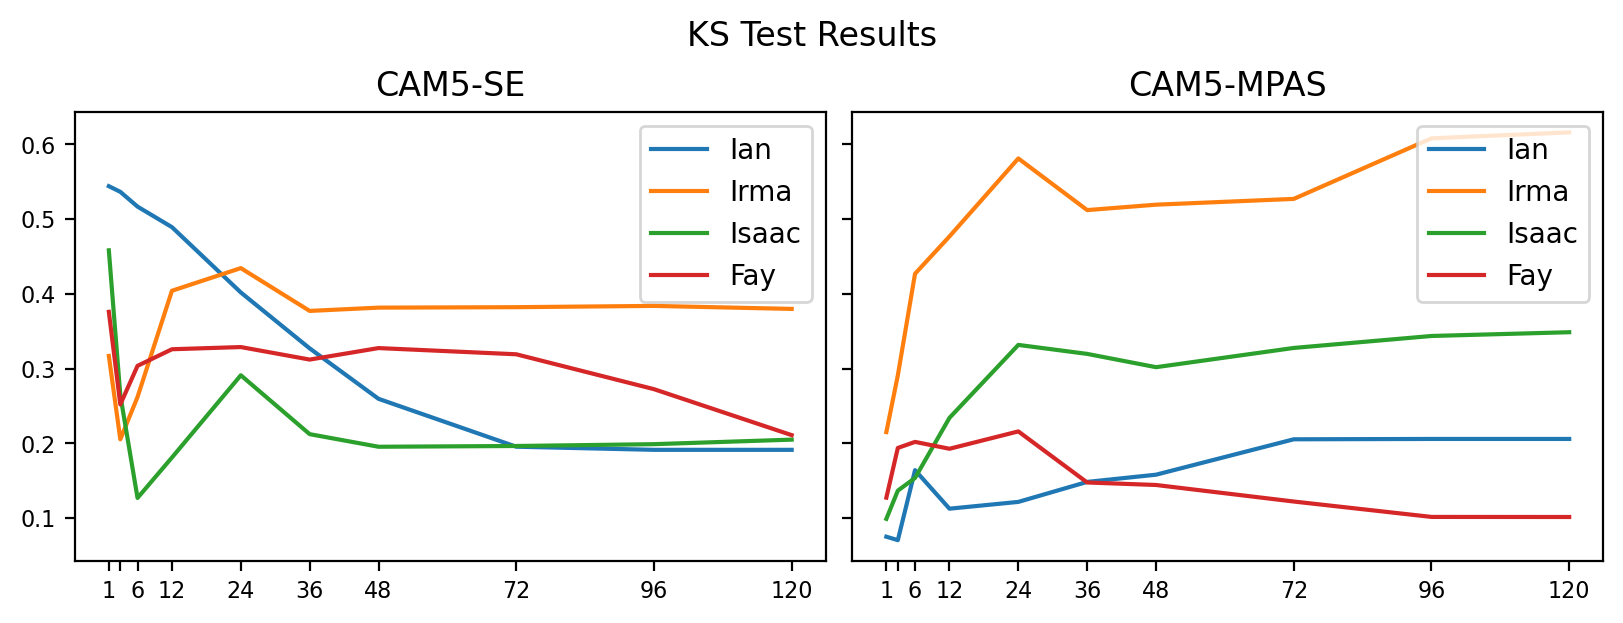

In [138]:
fig, axs = plt.subplots(ncols=2, dpi=200, figsize=(8, 3), layout='constrained', sharey=True)

ks_df_cam.T.plot(ax=axs[0])
ks_df_mpas.T.plot(ax=axs[1])

for i, ax in enumerate(axs.ravel()):
    xlabs = [1, '', 6, 12, 24, 36, 48, 72, 96, 120]
    ax.set_xticks(cols, xlabs)
    ax.set_title(['CAM5-SE', 'CAM5-MPAS'][i])
    ax.tick_params(axis='both', which='major', labelsize=8)
    
fig.suptitle('KS Test Results')

plt.show()

In [150]:
def calc_cdf(x):
    x = np.sort(x)
    cdf = 1*(np.arange(x.shape[0])/(x.shape[0]-1))
    
    return cdf

def plot_cdf_hourly(cam_df_list, mpas_df_list, nexrad_df_list, hour):
    
    # Sets up plot
    font_kw = {'labels':8, 'titles':10, 'ticks':7, 'legend':8}
    plot_kw = {'lw':1.0, 'xlabel':'Accumulated Precipitation [in]', 
               'figtitle':f'{hour}-Hourly Total Precipitation Cumulative Distribution'}
    fig_kw = {'ncols': 2, 'nrows': 2, 'figsize': (6, 6), 'dpi':300, 'layout':'constrained', 'sharey':True}
    line_kw = {'ls':'-', 'lw':1.0}

    cam_colors = ['#024588', '#6ca3c1', '#3374a7', '#6ca3c1']
    mpas_colors = ['#bd0086', '#e892c4', '#d45ca5', '#e892c4']
    nexrad_colors = ['#377E22', '#aed09f', '#74a761', '#aed09f']
    colors = [cam_colors[0], mpas_colors[0], nexrad_colors[0]]
    
    # Gets values
    cam_arr = [x.loc[f'sum_{hour}'].values for x in cam_df_list]
    mpas_arr = [x.loc[f'sum_{hour}'].values for x in mpas_df_list]
    nexrad_arr = [x.loc[f'sum_{hour}'].values for x in nexrad_df_list]
    
    # Calculates mean and std
    cam_xbar = ['%.2f' % x.mean() for x in cam_arr]
    cam_s = ['%.2f' % x.std() for x in cam_arr]
    mpas_xbar = ['%.2f' % x.mean() for x in mpas_arr]
    mpas_s = ['%.2f' % x.std() for x in mpas_arr]
    nexrad_xbar = ['%.2f' % x.mean() for x in nexrad_arr]
    nexrad_s = ['%.2f' % x.std() for x in nexrad_arr]
    
    # Calculates cdfs
    cam_cdfs = [calc_cdf(x) for x in cam_arr]
    mpas_cdfs = [calc_cdf(x) for x in mpas_arr]
    nexrad_cdfs = [calc_cdf(x) for x in nexrad_arr]
    
    # Plots results
    fig, axs = plt.subplots(**fig_kw)
    
    for i, ax in enumerate(axs.ravel()):
        ax.plot(np.sort(cam_arr[i]), cam_cdfs[i], c=colors[0], **line_kw)
        ax.plot(np.sort(mpas_arr[i]), mpas_cdfs[i], c=colors[1], **line_kw)
        ax.plot(np.sort(nexrad_arr[i]), nexrad_cdfs[i], c=colors[2], **line_kw)
        
        if i in [2, 3]:
            ax.set_xlabel(plot_kw['xlabel'], fontsize=font_kw['labels'])
        ax.tick_params(axis='both', which='major', labelsize=font_kw['ticks'])
        ax.set_title(f'{storm_name[i]} ({storm_yrs[i]})', fontsize=font_kw['titles'], fontweight='bold')
        
        # Sets up legend (per ax)
        llabs = [r'$\bar{x}$'+f' = {cam_xbar[i]}, $s$ = {cam_s[i]}',
                 r'$\bar{x}$'+f' = {mpas_xbar[i]}, $s$ = {mpas_s[i]}',
                 r'$\bar{x}$'+f' = {nexrad_xbar[i]}, $s$ = {nexrad_s[i]}']
        
        lcs = colors
        lss = ['-', '-', '-']
        ldict = {'xdata': [], 'ydata': [], 'lw': 1.5}
        lhands = [mlines.Line2D(label=l, color=c, ls=ls, **ldict) for (l, c, ls) in 
           zip(llabs, lcs, lss)]
        ax.legend(handles=lhands, fontsize=font_kw['legend'], loc='lower right', handlelength=1.65)
    
    fig.suptitle(plot_kw['figtitle'], fontsize=font_kw['titles']+4, fontweight='bold')

    llabels = ['CAM5-SE', 'CAM5-MPAS', 'NEXRAD']
    lcolors = colors
    lstyles = ['-', '-', '-']
    style_dict = {'xdata': [], 'ydata': [], 'lw': 1.5}
    handles = [mlines.Line2D(label=l, color=c, ls=ls, **style_dict) for (l, c, ls) in 
               zip(llabels, lcolors, lstyles)]
    leg = fig.legend(handles=handles, fontsize=font_kw['legend'], loc='outside lower center', 
              ncols=3, handlelength=1.65)

    plt.show()
    plt.close()      

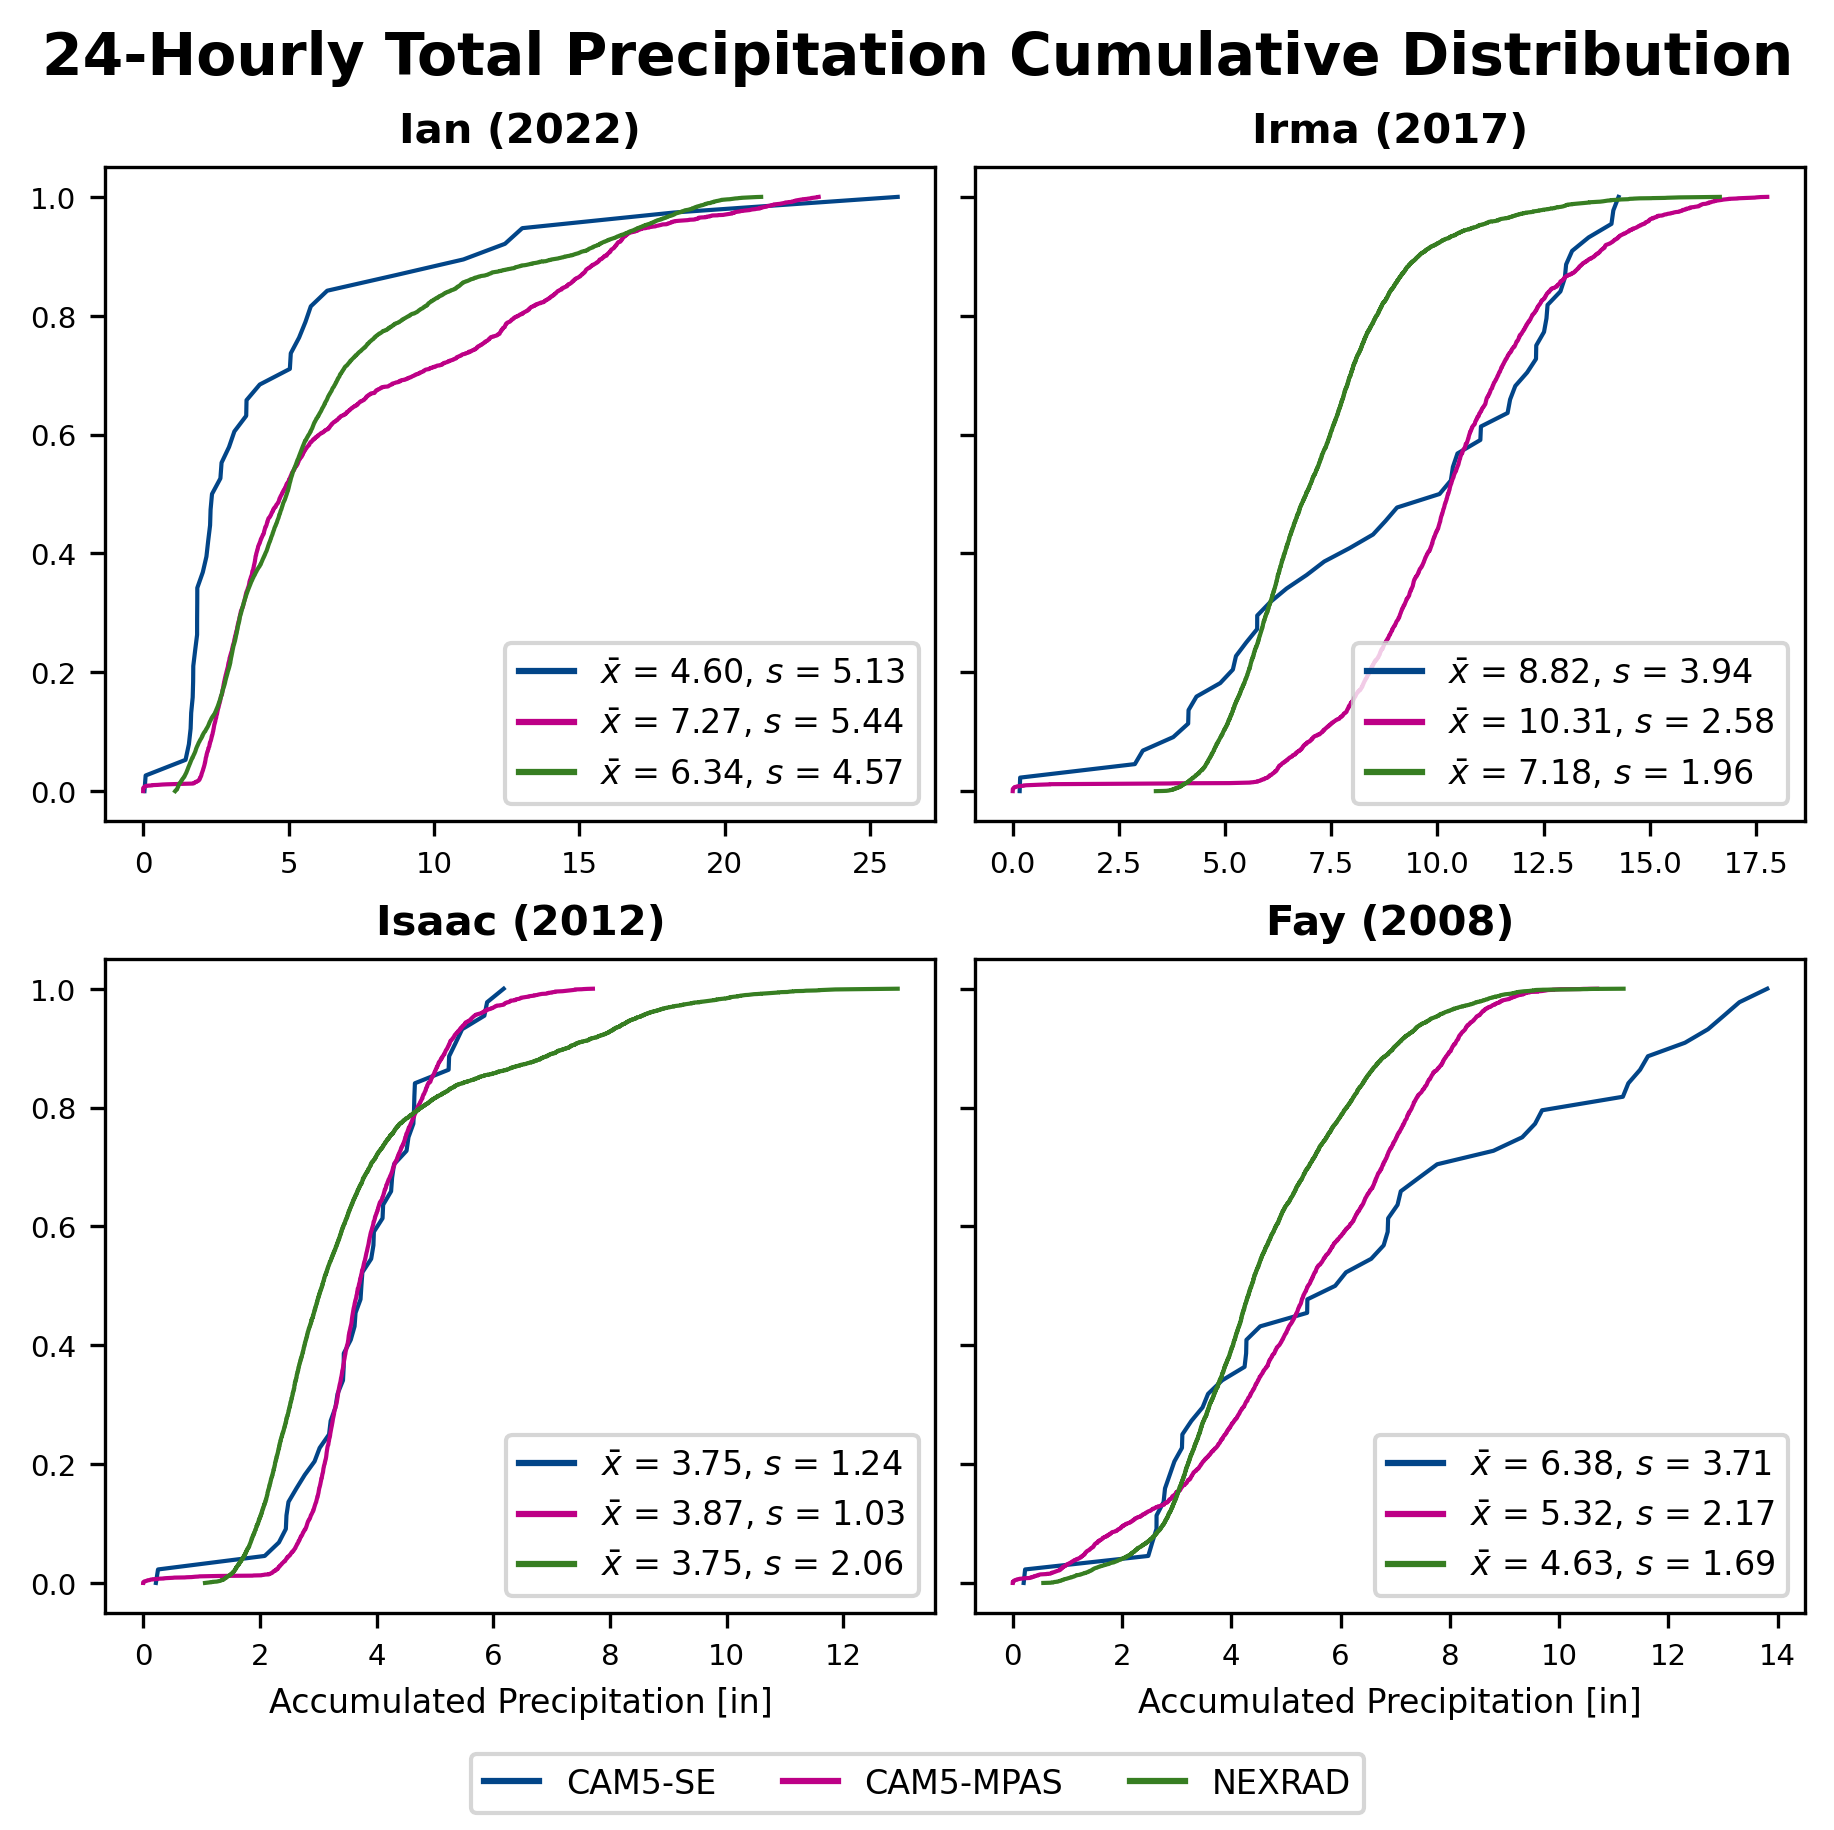

In [155]:
hour = 24
plot_cdf_hourly(cam_df_list, mpas_df_list, nexrad_df_list, hour)

In [ ]:
ds_arr=['h4pn_ds', 'h4cn_ds']
storm_names = ['Ian', 'Irma', 'Isaac', 'Fay']
variable = 'PRECT_TOT'
bboxes = [ian_bbox, irma_bbox, isaac_bbox, fay_bbox]
nexrad_ds_list = [ian_ds, irma_ds, isaac_ds, fay_ds]

# Packs target datasets into list
storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_names))
cam_ds_list = [x[0] for x in storm_list]
mpas_ds_list = [x[1] for x in storm_list]
storm_yrs = [ds.time[0].dt.year.values for ds in cam_ds_list]

cam_arr_tot = [get_hist_metrics(x, variable, bboxes[i])[0] for i, x in enumerate(cam_ds_list)]
mpas_arr_tot = [get_hist_metrics(x, variable, bboxes[i])[0] for i, x in enumerate(mpas_ds_list)]
nexrad_arr_tot = [nexrad_hist_metrics(x, variable, bboxes[i])[0] for i, x in enumerate(nexrad_ds_list)]

cam_ks_tot = [ks_2samp(samp1, samp2).statistic for samp1, samp2 in zip(nexrad_arr_tot, cam_arr_tot)]
cam_pvalue_tot = [ks_2samp(samp1, samp2).pvalue for samp1, samp2 in zip(nexrad_arr_tot, cam_arr_tot)]
mpas_ks_tot = [ks_2samp(samp1, samp2).statistic for samp1, samp2 in zip(nexrad_arr_tot, mpas_arr_tot)]
mpas_pvalue_tot = [ks_2samp(samp1, samp2).pvalue for samp1, samp2 in zip(nexrad_arr_tot, mpas_arr_tot)]

print('Total Precipitation')
pd.DataFrame({'KS_CAM':cam_ks_tot, 'pvalue_CAM':cam_pvalue_tot, 
              'KS_MPAS':mpas_ks_tot, 'pvalue_MPAS':mpas_pvalue_tot}, 
             index=['Ian', 'Irma', 'Isaac', 'Fay'])

Total Precipitation


KS_CAM  pvalue_CAM   KS_MPAS    pvalue_MPAS
Ian    0.191407    0.101648  0.205959   1.005538e-81
Irma   0.379928    0.000003  0.616085  2.776649e-321
Isaac  0.205041    0.039743  0.348739  9.612299e-257
Fay    0.211074    0.031508  0.101552   9.620298e-22

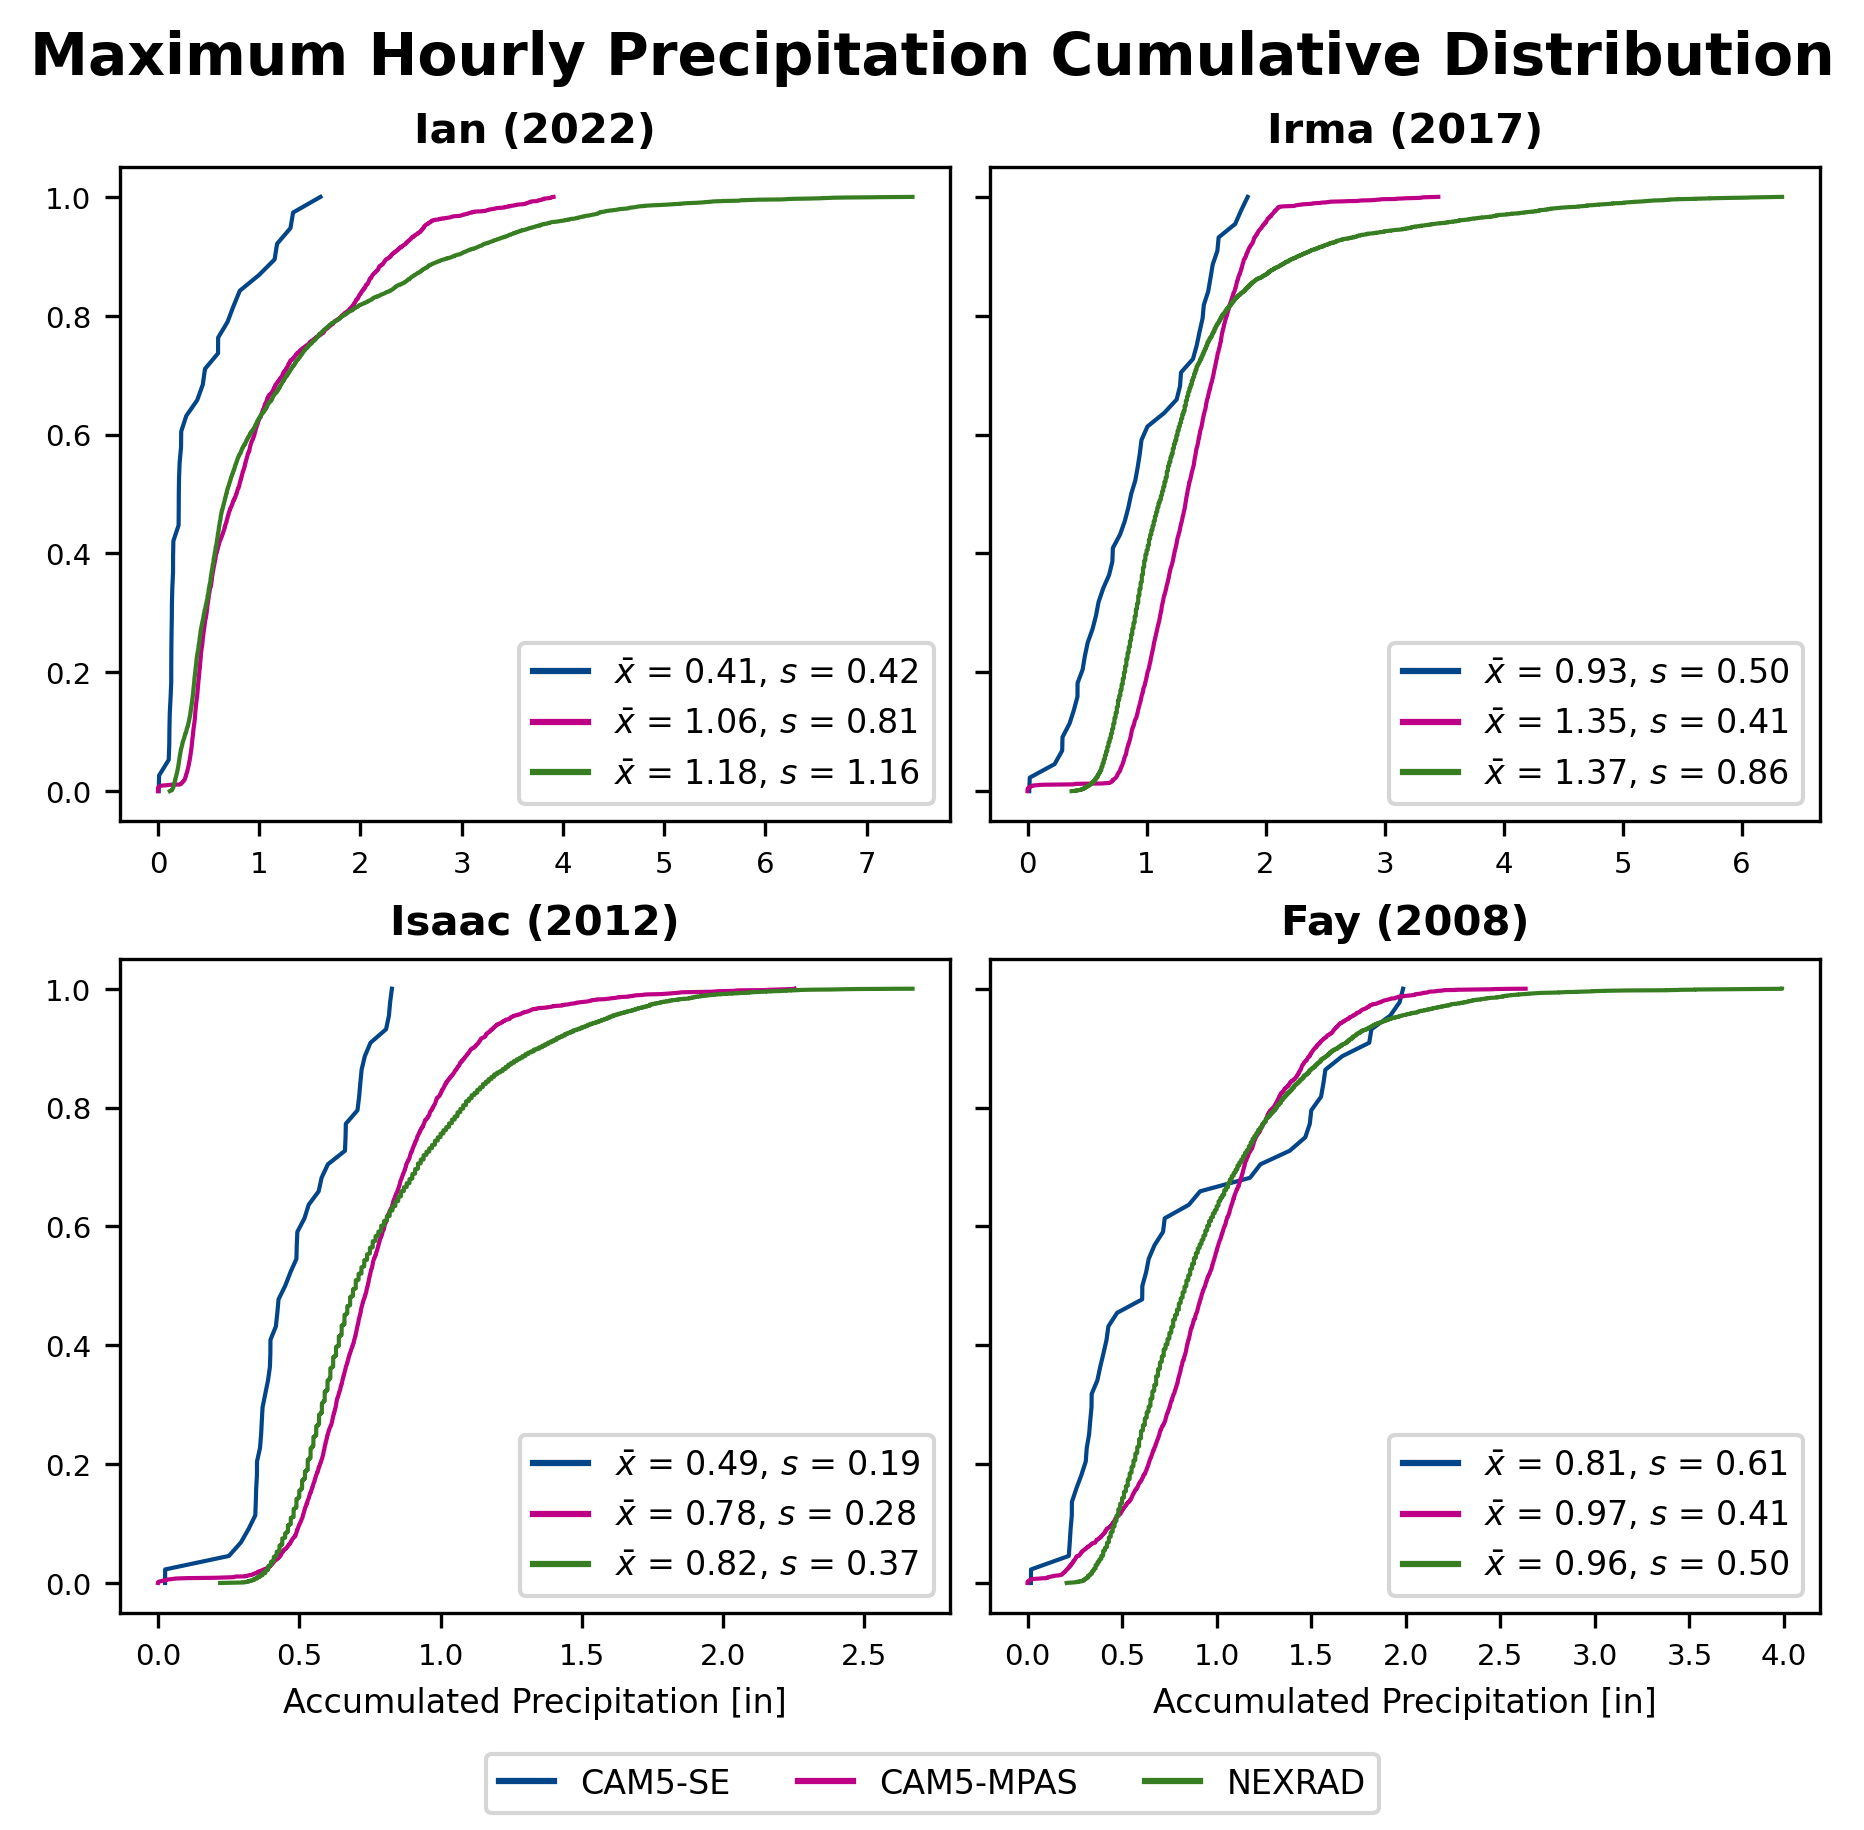

In [133]:
ds_arr=['h4pn_ds', 'h4cn_ds']
storm_names = ['Ian', 'Irma', 'Isaac', 'Fay']
variable = 'PRECT_MAX'
bboxes = [ian_bbox, irma_bbox, isaac_bbox, fay_bbox]
nexrad_ds_list = [ian_ds, irma_ds, isaac_ds, fay_ds]

plot_cdf(storm_names, variable, ds_arr, nexrad_ds_list, bboxes)

In [46]:
import csv 

with open("/gpfs/scratch/cnd5285/prect_data.txt", mode="w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['cam_ian_tot', *cam_list[0]])
    writer.writerow(['cam_irma_tot', *cam_list[1]])
    writer.writerow(['cam_isaac_tot', *cam_list[2]])
    writer.writerow(['cam_fay_tot', *cam_list[3]])
    writer.writerow(['mpas_ian_tot', *mpas_list[0]])
    writer.writerow(['mpas_irma_tot', *mpas_list[1]])
    writer.writerow(['mpas_isaac_tot', *mpas_list[2]])
    writer.writerow(['mpas_fay_tot', *mpas_list[3]])
    writer.writerow(['nexrad_ian_tot', *nexrad_var_list[0]])
    writer.writerow(['nexrad_irma_tot', *nexrad_var_list[1]])
    writer.writerow(['nexrad_isaac_tot', *nexrad_var_list[2]])
    writer.writerow(['nexrad_fay_tot', *nexrad_var_list[3]])
    writer.writerow(['cam_ian_max', *cam_list2[0]])
    writer.writerow(['cam_irma_max', *cam_list2[1]])
    writer.writerow(['cam_isaac_max', *cam_list2[2]])
    writer.writerow(['cam_fay_max', *cam_list2[3]])
    writer.writerow(['mpas_ian_max', *mpas_list2[0]])
    writer.writerow(['mpas_irma_max', *mpas_list2[1]])
    writer.writerow(['mpas_isaac_max', *mpas_list2[2]])
    writer.writerow(['mpas_fay_max', *mpas_list2[3]])
    writer.writerow(['nexrad_ian_max', *nexrad_var_list2[0]])
    writer.writerow(['nexrad_irma_max', *nexrad_var_list2[1]])
    writer.writerow(['nexrad_isaac_max', *nexrad_var_list2[2]])
    writer.writerow(['nexrad_fay_max', *nexrad_var_list2[3]])

In [136]:
ds_arr=['h4pn_ds', 'h4cn_ds']
storm_names = ['Ian', 'Irma', 'Isaac', 'Fay']
variable = 'PRECT_MAX'
bboxes = [ian_bbox, irma_bbox, isaac_bbox, fay_bbox]
nexrad_ds_list = [ian_ds, irma_ds, isaac_ds, fay_ds]

# Packs target datasets into list
storm_list = list(map(lambda x: [all_storms.get(x).get(y) for y in ds_arr], storm_names))
cam_ds_list = [x[0] for x in storm_list]
mpas_ds_list = [x[1] for x in storm_list]
storm_yrs = [ds.time[0].dt.year.values for ds in cam_ds_list]

cam_arr_max = [get_hist_metrics(x, variable, bboxes[i])[0] for i, x in enumerate(cam_ds_list)]
mpas_arr_max = [get_hist_metrics(x, variable, bboxes[i])[0] for i, x in enumerate(mpas_ds_list)]
nexrad_arr_max = [nexrad_hist_metrics(x, variable, bboxes[i])[0] for i, x in enumerate(nexrad_ds_list)]

cam_ks_max = [ks_2samp(samp1, samp2).statistic for samp1, samp2 in zip(nexrad_arr_max, cam_arr_max)]
cam_pvalue_max = [ks_2samp(samp1, samp2).pvalue for samp1, samp2 in zip(nexrad_arr_max, cam_arr_max)]
mpas_ks_max = [ks_2samp(samp1, samp2).statistic for samp1, samp2 in zip(nexrad_arr_max, mpas_arr_max)]
mpas_pvalue_max = [ks_2samp(samp1, samp2).pvalue for samp1, samp2 in zip(nexrad_arr_max, mpas_arr_max)]

print('Maximum Hourly Precipitation')
pd.DataFrame({'KS_CAM':cam_ks_max, 'pvalue_CAM':cam_pvalue_max, 
              'KS_MPAS':mpas_ks_max, 'pvalue_MPAS':mpas_pvalue_max}, 
             index=['Ian', 'Irma', 'Isaac', 'Fay'])

Maximum Hourly Precipitation


KS_CAM    pvalue_CAM   KS_MPAS   pvalue_MPAS
Ian    0.544115  2.719430e-11  0.075190  3.310208e-11
Irma   0.317055  1.688067e-04  0.215141  1.224936e-96
Isaac  0.458312  4.089771e-09  0.099070  1.031097e-20
Fay    0.376043  3.419336e-06  0.127411  5.250579e-34